In [1]:
import centralized as CP
import davisyin as DY
import admm as admm
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib as plt
from matplotlib import rc
# Configura el tipo de letra globalmente
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import proyecciones as pro
import time
import briceno as BA
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

In [2]:
np.__version__

'1.26.4'

In [3]:
# Caso 1: Caso base
    
# Cambiar criterio de parada por errores relativos.

# Seteamos los parámetros:
N, M = 3, 5  # Son 3 tecnologías, 5 escenarios

# Probabilidades:
inv_, mc_, voll_, d_ = [50.0,  1000.0, 10000.0, 1000.0]
                       #[10.0, 2000.0, 10000.0, 1000.0]
                       #[50.0,  1000.0, 10000.0, 1000.0]
Sigma = np.ones((1,M))
#Sigma = np.random.rand(1,M)
Sigma /= Sigma.sum()
Sigma

array([[0.2, 0.2, 0.2, 0.2, 0.2]])

In [4]:
Times = {}
r_ = 1


# Parámetros funciones:
I    = inv_ * np.ones((N, 1)) + r_*np.array([[-45], [0], [45]])
print("I\n",I)
aux  = np.array([1 + r_*20*i for i in range(N)])

mc_11 = 100
mc_22 = 500
mc_33 = 1000
MC   = np.array([np.diag(mc_*aux + r_*np.array([((-1)**m)*mc_11*m, ((-1)**m)*mc_22*m, ((-1)**(m+1))*mc_33*m])) for m in range(M)])
print("MC\n",MC)
VOLL = voll_
print("VOLL\n",VOLL)
D    = d_*np.ones((1,M)) + r_*np.array([-800, -250, 0, 250, 500])[np.newaxis]
print("D\n",D)

e_ = 0

e1  = e_
e2  = e_
e31 = e_*1e2/2
e32 = e_

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))


frobenius_norm = (e1+e2)*np.sqrt(N)+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()
#frobenius_norm = max([e1*np.sqrt(N),e31+e32,e2*np.sqrt(N)+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()])
print("frobenius_norm:",frobenius_norm)

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
       return np.dot(Q_1,x1)+B_1# - e1*np.dot(np.identity(N),np.maximum(-x1,0))


def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):

    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2# - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))


def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 #- e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))


def Grad_Phi(x1,x2,x3, P = Sigma):
    return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Grad_Phi_NA(x1,x2,x3, P = Sigma):
    return P*Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0, e1 = e1):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1 + e1/2*LA.norm(np.maximum(-x1.flatten(),0))**2

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2 + e2/2*LA.norm(np.maximum(-x2.flatten(),0))**2

def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), C_3 = -VOLL*D ):
    return (0.5*x3*Q_3*x3+B_3*x3+C_3).T + e31/2*LA.norm(np.maximum(-x3.flatten(),0))**2 + e32/2*LA.norm(np.maximum((D-x3).flatten(),0))**2


def objective_function(x1, x2, x3, P = Sigma, NA = True):

# NA = True, cumple la funcion que si se impuso 
#      la condición de no anticipatividad para x1
#      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))

I
 [[5.0]
 [50.0]
 [95.0]]
MC
 [[[1000.0 0.0 0.0]
  [0.0 21000.0 0.0]
  [0.0 0.0 41000.0]]

 [[900.0 0.0 0.0]
  [0.0 20500.0 0.0]
  [0.0 0.0 42000.0]]

 [[1200.0 0.0 0.0]
  [0.0 22000.0 0.0]
  [0.0 0.0 39000.0]]

 [[700.0 0.0 0.0]
  [0.0 19500.0 0.0]
  [0.0 0.0 44000.0]]

 [[1400.0 0.0 0.0]
  [0.0 23000.0 0.0]
  [0.0 0.0 37000.0]]]
VOLL
 10000.0
D
 [[200.0 750.0 1000.0 1250.0 1500.0]]
frobenius_norm: 458.6700171031756


In [5]:
cp = time.time()
x1, x2, x3, rho, mu = map(np.array, CP.modelo(Sigma, N, M, \
                                              parametros = [I.T[0].tolist(),\
                                                            np.array([mc_*aux + r_*np.array([((-1)**m)*mc_11*m, ((-1)**m)*mc_22*m, ((-1)**(m+1))*mc_33*m]) for m in range(M)]).T.tolist(),\
                                                            VOLL,\
                                                            D[0]] , show = 0))
fin = time.time()


Times["CP"] = fin - cp

x1 = x1[:,np.newaxis]
x2 = x2.T
x3 = x3[np.newaxis,:][0]
rho = rho[np.newaxis]

In [6]:
print(f"primal:\n{x1}\n{x2}\n{x3}")
print(f"Dual:\n{mu}\n{rho}")

primal:
[[1188.3]
 [44.3]
 [25.7]]
[[186.6 704.0 833.3 1188.3 714.3]
 [8.9 30.9 44.3 42.8 43.5]
 [4.6 15.1 25.6 19.0 25.7]]
[[0.0 0.0 96.7 0.0 716.5]]
Dual:
[[0.0 0.0 0.0 25.0 0.0]
 [0.0 0.0 250.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 475.0]]
[[1865.7 6336.1 10000.0 8342.8 10000.0]]


In [7]:
# DY
    
dy = time.time()
DY_list, DY_f_list, DY_z_list, Dual_DY_list, iterations_DY   = DY.Davis_Yin(N, M, frobenius_norm, Grad_Phi, D, (x1,x2,x3), Sigma)
fin = time.time()

Times["DY"] = fin - dy

Beta: 0.002180216632244036
Gamma: 0.004013225500591509
Lambda_k: 1
Iteration: 1 lambda_k: 1 Loss: 0.9458180938529576
Iteration: 2 lambda_k: 1 Loss: 0.8660472506762181
Iteration: 3 lambda_k: 1 Loss: 0.8301219872743254
Iteration: 4 lambda_k: 1 Loss: 0.8399072147388666
Iteration: 5 lambda_k: 1 Loss: 0.8315818810768336
Iteration: 6 lambda_k: 1 Loss: 0.8207532590858538
Iteration: 7 lambda_k: 1 Loss: 0.8136064251562316
Iteration: 8 lambda_k: 1 Loss: 0.8085830631187111
Iteration: 9 lambda_k: 1 Loss: 0.8045489670980089
Iteration: 10 lambda_k: 1 Loss: 0.8013920832043254
Iteration: 11 lambda_k: 1 Loss: 0.7983607508912482
Iteration: 12 lambda_k: 1 Loss: 0.7953903846603333
Iteration: 13 lambda_k: 1 Loss: 0.7925009314650064
Iteration: 14 lambda_k: 1 Loss: 0.7897015871482305
Iteration: 15 lambda_k: 1 Loss: 0.7869810970028334
Iteration: 16 lambda_k: 1 Loss: 0.7843155071203574
Iteration: 17 lambda_k: 1 Loss: 0.7816984115104484
Iteration: 18 lambda_k: 1 Loss: 0.7791149007539367
Iteration: 19 lambda_k: 

Iteration: 160 lambda_k: 1 Loss: 0.5525125615335608
Iteration: 161 lambda_k: 1 Loss: 0.5512222161504191
Iteration: 162 lambda_k: 1 Loss: 0.5499349958793874
Iteration: 163 lambda_k: 1 Loss: 0.5486508910459943
Iteration: 164 lambda_k: 1 Loss: 0.5473698920239709
Iteration: 165 lambda_k: 1 Loss: 0.5460919892344103
Iteration: 166 lambda_k: 1 Loss: 0.5448171731450056
Iteration: 167 lambda_k: 1 Loss: 0.543545434269356
Iteration: 168 lambda_k: 1 Loss: 0.5422767631663351
Iteration: 169 lambda_k: 1 Loss: 0.5410111504395132
Iteration: 170 lambda_k: 1 Loss: 0.5397485867366303
Iteration: 171 lambda_k: 1 Loss: 0.5384890627491122
Iteration: 172 lambda_k: 1 Loss: 0.5372325692116282
Iteration: 173 lambda_k: 1 Loss: 0.5359790969016829
Iteration: 174 lambda_k: 1 Loss: 0.534728636639243
Iteration: 175 lambda_k: 1 Loss: 0.5334811792863919
Iteration: 176 lambda_k: 1 Loss: 0.53223671574696
Iteration: 177 lambda_k: 1 Loss: 0.5309952369664445
Iteration: 178 lambda_k: 1 Loss: 0.5297567339313933
Iteration: 179 l

Iteration: 317 lambda_k: 1 Loss: 0.3831876121651565
Iteration: 318 lambda_k: 1 Loss: 0.38232995302809164
Iteration: 319 lambda_k: 1 Loss: 0.38152682059616444
Iteration: 320 lambda_k: 1 Loss: 0.38073245392455063
Iteration: 321 lambda_k: 1 Loss: 0.37994737852875565
Iteration: 322 lambda_k: 1 Loss: 0.37917112799422087
Iteration: 323 lambda_k: 1 Loss: 0.3784032618019073
Iteration: 324 lambda_k: 1 Loss: 0.37764356609718386
Iteration: 325 lambda_k: 1 Loss: 0.37689193892274675
Iteration: 326 lambda_k: 1 Loss: 0.3761482926138226
Iteration: 327 lambda_k: 1 Loss: 0.3754125266420608
Iteration: 328 lambda_k: 1 Loss: 0.37468453345453845
Iteration: 329 lambda_k: 1 Loss: 0.3739642067882024
Iteration: 330 lambda_k: 1 Loss: 0.37325144439856084
Iteration: 331 lambda_k: 1 Loss: 0.37254614742560316
Iteration: 332 lambda_k: 1 Loss: 0.371848219345301
Iteration: 333 lambda_k: 1 Loss: 0.37115756543778056
Iteration: 334 lambda_k: 1 Loss: 0.37047409267831616
Iteration: 335 lambda_k: 1 Loss: 0.3697977098095406
I

Iteration: 474 lambda_k: 1 Loss: 0.2959704847215729
Iteration: 475 lambda_k: 1 Loss: 0.29551235845590074
Iteration: 476 lambda_k: 1 Loss: 0.29505505670127785
Iteration: 477 lambda_k: 1 Loss: 0.2945985773485262
Iteration: 478 lambda_k: 1 Loss: 0.29414291830288347
Iteration: 479 lambda_k: 1 Loss: 0.29368807748390424
Iteration: 480 lambda_k: 1 Loss: 0.29323405282536436
Iteration: 481 lambda_k: 1 Loss: 0.29278084227516904
Iteration: 482 lambda_k: 1 Loss: 0.2923284437952639
Iteration: 483 lambda_k: 1 Loss: 0.2918768553615499
Iteration: 484 lambda_k: 1 Loss: 0.29142607496379924
Iteration: 485 lambda_k: 1 Loss: 0.2909761006055761
Iteration: 486 lambda_k: 1 Loss: 0.2905269303041576
Iteration: 487 lambda_k: 1 Loss: 0.29007856209045885
Iteration: 488 lambda_k: 1 Loss: 0.28963099400895886
Iteration: 489 lambda_k: 1 Loss: 0.28918422411762906
Iteration: 490 lambda_k: 1 Loss: 0.28873825048786333
Iteration: 491 lambda_k: 1 Loss: 0.2882930712044101
Iteration: 492 lambda_k: 1 Loss: 0.2878486843653061
I

Iteration: 631 lambda_k: 1 Loss: 0.2331259590491161
Iteration: 632 lambda_k: 1 Loss: 0.23277966775097442
Iteration: 633 lambda_k: 1 Loss: 0.23243381837514354
Iteration: 634 lambda_k: 1 Loss: 0.2320884033089699
Iteration: 635 lambda_k: 1 Loss: 0.2317434161587077
Iteration: 636 lambda_k: 1 Loss: 0.23139885155434936
Iteration: 637 lambda_k: 1 Loss: 0.23105470498089362
Iteration: 638 lambda_k: 1 Loss: 0.2307109726372428
Iteration: 639 lambda_k: 1 Loss: 0.23036765131933631
Iteration: 640 lambda_k: 1 Loss: 0.23002473832250314
Iteration: 641 lambda_k: 1 Loss: 0.22968223135911925
Iteration: 642 lambda_k: 1 Loss: 0.22934012848896596
Iteration: 643 lambda_k: 1 Loss: 0.22899842806035628
Iteration: 644 lambda_k: 1 Loss: 0.2286571286603861
Iteration: 645 lambda_k: 1 Loss: 0.22831622907288504
Iteration: 646 lambda_k: 1 Loss: 0.22797572824286952
Iteration: 647 lambda_k: 1 Loss: 0.22763562524650505
Iteration: 648 lambda_k: 1 Loss: 0.22729591926575224
Iteration: 649 lambda_k: 1 Loss: 0.2269566095670002

Iteration: 787 lambda_k: 1 Loss: 0.18363326678828482
Iteration: 788 lambda_k: 1 Loss: 0.1833424415764834
Iteration: 789 lambda_k: 1 Loss: 0.18305191965422127
Iteration: 790 lambda_k: 1 Loss: 0.1827617004949612
Iteration: 791 lambda_k: 1 Loss: 0.18247178357494565
Iteration: 792 lambda_k: 1 Loss: 0.18218216837318815
Iteration: 793 lambda_k: 1 Loss: 0.18189285437146457
Iteration: 794 lambda_k: 1 Loss: 0.1816038410543043
Iteration: 795 lambda_k: 1 Loss: 0.18131512790898174
Iteration: 796 lambda_k: 1 Loss: 0.1810267144255077
Iteration: 797 lambda_k: 1 Loss: 0.18073860009662068
Iteration: 798 lambda_k: 1 Loss: 0.1804507844177788
Iteration: 799 lambda_k: 1 Loss: 0.180163266887151
Iteration: 800 lambda_k: 1 Loss: 0.17987604700560908
Iteration: 801 lambda_k: 1 Loss: 0.17958912427671908
Iteration: 802 lambda_k: 1 Loss: 0.1793024982067332
Iteration: 803 lambda_k: 1 Loss: 0.17901616830458147
Iteration: 804 lambda_k: 1 Loss: 0.17873013408186417
Iteration: 805 lambda_k: 1 Loss: 0.17844439505284312
I

Iteration: 943 lambda_k: 1 Loss: 0.14166540047417234
Iteration: 944 lambda_k: 1 Loss: 0.14141708897281322
Iteration: 945 lambda_k: 1 Loss: 0.14116902844855533
Iteration: 946 lambda_k: 1 Loss: 0.14092121874702557
Iteration: 947 lambda_k: 1 Loss: 0.14067365971615012
Iteration: 948 lambda_k: 1 Loss: 0.14042635120615732
Iteration: 949 lambda_k: 1 Loss: 0.14017929306958035
Iteration: 950 lambda_k: 1 Loss: 0.13993248516126033
Iteration: 951 lambda_k: 1 Loss: 0.13968592733834942
Iteration: 952 lambda_k: 1 Loss: 0.13943961946031344
Iteration: 953 lambda_k: 1 Loss: 0.1391935613889354
Iteration: 954 lambda_k: 1 Loss: 0.13894775298831838
Iteration: 955 lambda_k: 1 Loss: 0.138702194124889
Iteration: 956 lambda_k: 1 Loss: 0.1384568846674006
Iteration: 957 lambda_k: 1 Loss: 0.13821182448693667
Iteration: 958 lambda_k: 1 Loss: 0.13796701345691423
Iteration: 959 lambda_k: 1 Loss: 0.1377224514530892
Iteration: 960 lambda_k: 1 Loss: 0.13747813835355455
Iteration: 961 lambda_k: 1 Loss: 0.1372340740387486

Iteration: 1097 lambda_k: 1 Loss: 0.10634488078972329
Iteration: 1098 lambda_k: 1 Loss: 0.10613488279523872
Iteration: 1099 lambda_k: 1 Loss: 0.10592514232849466
Iteration: 1100 lambda_k: 1 Loss: 0.10571565966478949
Iteration: 1101 lambda_k: 1 Loss: 0.10550643508303315
Iteration: 1102 lambda_k: 1 Loss: 0.10529746886576238
Iteration: 1103 lambda_k: 1 Loss: 0.10508876129915629
Iteration: 1104 lambda_k: 1 Loss: 0.10488031267305138
Iteration: 1105 lambda_k: 1 Loss: 0.1046721232809578
Iteration: 1106 lambda_k: 1 Loss: 0.10446419342007478
Iteration: 1107 lambda_k: 1 Loss: 0.10425652339130626
Iteration: 1108 lambda_k: 1 Loss: 0.1040491134992771
Iteration: 1109 lambda_k: 1 Loss: 0.10384196405235964
Iteration: 1110 lambda_k: 1 Loss: 0.10363507536275361
Iteration: 1111 lambda_k: 1 Loss: 0.10342844774624127
Iteration: 1112 lambda_k: 1 Loss: 0.10322208152247128
Iteration: 1113 lambda_k: 1 Loss: 0.10301597701491531
Iteration: 1114 lambda_k: 1 Loss: 0.10281013455086681
Iteration: 1115 lambda_k: 1 Lo

Iteration: 1250 lambda_k: 1 Loss: 0.07708672662470739
Iteration: 1251 lambda_k: 1 Loss: 0.07691067429142512
Iteration: 1252 lambda_k: 1 Loss: 0.07673476773761777
Iteration: 1253 lambda_k: 1 Loss: 0.0765590067238105
Iteration: 1254 lambda_k: 1 Loss: 0.07638339102329766
Iteration: 1255 lambda_k: 1 Loss: 0.0762079204210256
Iteration: 1256 lambda_k: 1 Loss: 0.076032594712563
Iteration: 1257 lambda_k: 1 Loss: 0.07585741370315284
Iteration: 1258 lambda_k: 1 Loss: 0.0756823772068386
Iteration: 1259 lambda_k: 1 Loss: 0.07550748504566093
Iteration: 1260 lambda_k: 1 Loss: 0.0753327370489184
Iteration: 1261 lambda_k: 1 Loss: 0.07515813305248786
Iteration: 1262 lambda_k: 1 Loss: 0.07498367289820025
Iteration: 1263 lambda_k: 1 Loss: 0.07480935643326736
Iteration: 1264 lambda_k: 1 Loss: 0.07463518350975624
Iteration: 1265 lambda_k: 1 Loss: 0.07446115398410665
Iteration: 1266 lambda_k: 1 Loss: 0.07428726771668913
Iteration: 1267 lambda_k: 1 Loss: 0.0741135245714007
Iteration: 1268 lambda_k: 1 Loss: 0

Iteration: 1402 lambda_k: 1 Loss: 0.051922815022072244
Iteration: 1403 lambda_k: 1 Loss: 0.0517674436485631
Iteration: 1404 lambda_k: 1 Loss: 0.05161219943299544
Iteration: 1405 lambda_k: 1 Loss: 0.051457082265128275
Iteration: 1406 lambda_k: 1 Loss: 0.05130209203490742
Iteration: 1407 lambda_k: 1 Loss: 0.05114722863246619
Iteration: 1408 lambda_k: 1 Loss: 0.05099249194812568
Iteration: 1409 lambda_k: 1 Loss: 0.05083788187239523
Iteration: 1410 lambda_k: 1 Loss: 0.05068339829597302
Iteration: 1411 lambda_k: 1 Loss: 0.050529041109746424
Iteration: 1412 lambda_k: 1 Loss: 0.050374810204792425
Iteration: 1413 lambda_k: 1 Loss: 0.050220705472378085
Iteration: 1414 lambda_k: 1 Loss: 0.05006672680396109
Iteration: 1415 lambda_k: 1 Loss: 0.04991287409118984
Iteration: 1416 lambda_k: 1 Loss: 0.04975914722590416
Iteration: 1417 lambda_k: 1 Loss: 0.0496055461001356
Iteration: 1418 lambda_k: 1 Loss: 0.04945207060610766
Iteration: 1419 lambda_k: 1 Loss: 0.04929872063623635
Iteration: 1420 lambda_k:

Iteration: 1553 lambda_k: 1 Loss: 0.029843997355022838
Iteration: 1554 lambda_k: 1 Loss: 0.029706695675681093
Iteration: 1555 lambda_k: 1 Loss: 0.029569507038026726
Iteration: 1556 lambda_k: 1 Loss: 0.029432431372419614
Iteration: 1557 lambda_k: 1 Loss: 0.029295468609743774
Iteration: 1558 lambda_k: 1 Loss: 0.02915861868141598
Iteration: 1559 lambda_k: 1 Loss: 0.02902188151939519
Iteration: 1560 lambda_k: 1 Loss: 0.028885257056191604
Iteration: 1561 lambda_k: 1 Loss: 0.028748745224876193
Iteration: 1562 lambda_k: 1 Loss: 0.02861234595909068
Iteration: 1563 lambda_k: 1 Loss: 0.02847605919305753
Iteration: 1564 lambda_k: 1 Loss: 0.02833988486159023
Iteration: 1565 lambda_k: 1 Loss: 0.02820382290010418
Iteration: 1566 lambda_k: 1 Loss: 0.028067873244627242
Iteration: 1567 lambda_k: 1 Loss: 0.027932035831811315
Iteration: 1568 lambda_k: 1 Loss: 0.027796310598943743
Iteration: 1569 lambda_k: 1 Loss: 0.027660697483959207
Iteration: 1570 lambda_k: 1 Loss: 0.02752519642545202
Iteration: 1571 l

Iteration: 1703 lambda_k: 1 Loss: 0.010498433900990116
Iteration: 1704 lambda_k: 1 Loss: 0.01037825854991512
Iteration: 1705 lambda_k: 1 Loss: 0.010258220761566093
Iteration: 1706 lambda_k: 1 Loss: 0.010138321856951245
Iteration: 1707 lambda_k: 1 Loss: 0.010018563223651343
Iteration: 1708 lambda_k: 1 Loss: 0.00989894631976697
Iteration: 1709 lambda_k: 1 Loss: 0.009779472678147381
Iteration: 1710 lambda_k: 1 Loss: 0.009660143910924046
Iteration: 1711 lambda_k: 1 Loss: 0.009540961714374714
Iteration: 1712 lambda_k: 1 Loss: 0.009421927874145737
Iteration: 1713 lambda_k: 1 Loss: 0.009303044270863967
Iteration: 1714 lambda_k: 1 Loss: 0.009184312886171263
Iteration: 1715 lambda_k: 1 Loss: 0.009065735809219879
Iteration: 1716 lambda_k: 1 Loss: 0.008947315243668302
Iteration: 1717 lambda_k: 1 Loss: 0.008829053515223818
Iteration: 1718 lambda_k: 1 Loss: 0.008710953079780457
Iteration: 1719 lambda_k: 1 Loss: 0.008593016532207757
Iteration: 1720 lambda_k: 1 Loss: 0.008475246615850801
Iteration: 1

Iteration: 1852 lambda_k: 1 Loss: 0.002651437888302902
Iteration: 1853 lambda_k: 1 Loss: 0.00265482295513739
Iteration: 1854 lambda_k: 1 Loss: 0.0026581876716962162
Iteration: 1855 lambda_k: 1 Loss: 0.002661529667451411
Iteration: 1856 lambda_k: 1 Loss: 0.0026648467330069006
Iteration: 1857 lambda_k: 1 Loss: 0.002668136818678295
Iteration: 1858 lambda_k: 1 Loss: 0.002671398032329008
Iteration: 1859 lambda_k: 1 Loss: 0.0026746286364849035
Iteration: 1860 lambda_k: 1 Loss: 0.002677827044772586
Iteration: 1861 lambda_k: 1 Loss: 0.002680991817744057
Iteration: 1862 lambda_k: 1 Loss: 0.002684121658162196
Iteration: 1863 lambda_k: 1 Loss: 0.0026872154058283915
Iteration: 1864 lambda_k: 1 Loss: 0.0026902720320365406
Iteration: 1865 lambda_k: 1 Loss: 0.002693290633737416
Iteration: 1866 lambda_k: 1 Loss: 0.0026962704274936748
Iteration: 1867 lambda_k: 1 Loss: 0.002699210743301172
Iteration: 1868 lambda_k: 1 Loss: 0.0027021110183454503
Iteration: 1869 lambda_k: 1 Loss: 0.002704970790755283
Iter

Iteration: 2000 lambda_k: 1 Loss: 0.002857567833060738
Iteration: 2001 lambda_k: 1 Loss: 0.00285797983827038
Iteration: 2002 lambda_k: 1 Loss: 0.0028583881097486107
Iteration: 2003 lambda_k: 1 Loss: 0.0028587927126150436
Iteration: 2004 lambda_k: 1 Loss: 0.0028591937104358897
Iteration: 2005 lambda_k: 1 Loss: 0.002859591165262899
Iteration: 2006 lambda_k: 1 Loss: 0.002859985137671456
Iteration: 2007 lambda_k: 1 Loss: 0.0028603756867976587
Iteration: 2008 lambda_k: 1 Loss: 0.0028607628703745573
Iteration: 2009 lambda_k: 1 Loss: 0.0028611467447674835
Iteration: 2010 lambda_k: 1 Loss: 0.002861527365008498
Iteration: 2011 lambda_k: 1 Loss: 0.0028619047848300857
Iteration: 2012 lambda_k: 1 Loss: 0.002862279056697939
Iteration: 2013 lambda_k: 1 Loss: 0.0028626502318429897
Iteration: 2014 lambda_k: 1 Loss: 0.002863018360292564
Iteration: 2015 lambda_k: 1 Loss: 0.0028633834909009195
Iteration: 2016 lambda_k: 1 Loss: 0.002863745671378891
Iteration: 2017 lambda_k: 1 Loss: 0.0028641049483228613
I

Iteration: 2148 lambda_k: 1 Loss: 0.002895800052950956
Iteration: 2149 lambda_k: 1 Loss: 0.0028959650630341486
Iteration: 2150 lambda_k: 1 Loss: 0.0028961292501281885
Iteration: 2151 lambda_k: 1 Loss: 0.0028962926189147887
Iteration: 2152 lambda_k: 1 Loss: 0.002896455174031428
Iteration: 2153 lambda_k: 1 Loss: 0.0028966169200721633
Iteration: 2154 lambda_k: 1 Loss: 0.0028967778615884643
Iteration: 2155 lambda_k: 1 Loss: 0.002896938003090003
Iteration: 2156 lambda_k: 1 Loss: 0.0028970973490453837
Iteration: 2157 lambda_k: 1 Loss: 0.002897255903882919
Iteration: 2158 lambda_k: 1 Loss: 0.0028974136719914024
Iteration: 2159 lambda_k: 1 Loss: 0.0028975706577207654
Iteration: 2160 lambda_k: 1 Loss: 0.0028977268653828043
Iteration: 2161 lambda_k: 1 Loss: 0.002897882299251802
Iteration: 2162 lambda_k: 1 Loss: 0.0028980369635652876
Iteration: 2163 lambda_k: 1 Loss: 0.0028981908625246365
Iteration: 2164 lambda_k: 1 Loss: 0.0028983440002956643
Iteration: 2165 lambda_k: 1 Loss: 0.00289849638100926

Iteration: 2296 lambda_k: 1 Loss: 0.0029131820439275186
Iteration: 2297 lambda_k: 1 Loss: 0.0029132618091146224
Iteration: 2298 lambda_k: 1 Loss: 0.0029133411842481214
Iteration: 2299 lambda_k: 1 Loss: 0.002913420171214914
Iteration: 2300 lambda_k: 1 Loss: 0.002913498771892783
Iteration: 2301 lambda_k: 1 Loss: 0.0029135769881504293
Iteration: 2302 lambda_k: 1 Loss: 0.002913654821847558
Iteration: 2303 lambda_k: 1 Loss: 0.002913732274834929
Iteration: 2304 lambda_k: 1 Loss: 0.0029138093489544
Iteration: 2305 lambda_k: 1 Loss: 0.002913886046038916
Iteration: 2306 lambda_k: 1 Loss: 0.002913962367912647
Iteration: 2307 lambda_k: 1 Loss: 0.0029140383163909793
Iteration: 2308 lambda_k: 1 Loss: 0.0029141138932805726
Iteration: 2309 lambda_k: 1 Loss: 0.0029141891003794072
Iteration: 2310 lambda_k: 1 Loss: 0.0029142639394768408
Iteration: 2311 lambda_k: 1 Loss: 0.002914338412353652
Iteration: 2312 lambda_k: 1 Loss: 0.002914412520782047
Iteration: 2313 lambda_k: 1 Loss: 0.0029144862665257806
Ite

Iteration: 2444 lambda_k: 1 Loss: 0.0029215912744231867
Iteration: 2445 lambda_k: 1 Loss: 0.0029216297849871927
Iteration: 2446 lambda_k: 1 Loss: 0.0029216681059828524
Iteration: 2447 lambda_k: 1 Loss: 0.00292170623833801
Iteration: 2448 lambda_k: 1 Loss: 0.0029217441829760523
Iteration: 2449 lambda_k: 1 Loss: 0.0029217819408159005
Iteration: 2450 lambda_k: 1 Loss: 0.0029218195127720236
Iteration: 2451 lambda_k: 1 Loss: 0.0029218568997545365
Iteration: 2452 lambda_k: 1 Loss: 0.002921894102669123
Iteration: 2453 lambda_k: 1 Loss: 0.0029219311224171155
Iteration: 2454 lambda_k: 1 Loss: 0.002921967959895519
Iteration: 2455 lambda_k: 1 Loss: 0.002922004615996947
Iteration: 2456 lambda_k: 1 Loss: 0.0029220410916097595
Iteration: 2457 lambda_k: 1 Loss: 0.0029220773876180266
Iteration: 2458 lambda_k: 1 Loss: 0.0029221135049015325
Iteration: 2459 lambda_k: 1 Loss: 0.002922149444335843
Iteration: 2460 lambda_k: 1 Loss: 0.0029221852067922416
Iteration: 2461 lambda_k: 1 Loss: 0.002922220793137842

Iteration: 2592 lambda_k: 1 Loss: 0.002925644504711217
Iteration: 2593 lambda_k: 1 Loss: 0.0029256630389320904
Iteration: 2594 lambda_k: 1 Loss: 0.0029256814817288563
Iteration: 2595 lambda_k: 1 Loss: 0.002925699833552218
Iteration: 2596 lambda_k: 1 Loss: 0.0029257180948507296
Iteration: 2597 lambda_k: 1 Loss: 0.002925736266070678
Iteration: 2598 lambda_k: 1 Loss: 0.002925754347656215
Iteration: 2599 lambda_k: 1 Loss: 0.002925772340049274
Iteration: 2600 lambda_k: 1 Loss: 0.0029257902436896598
Iteration: 2601 lambda_k: 1 Loss: 0.002925808059014985
Iteration: 2602 lambda_k: 1 Loss: 0.0029258257864607506
Iteration: 2603 lambda_k: 1 Loss: 0.0029258434264602625
Iteration: 2604 lambda_k: 1 Loss: 0.0029258609794447538
Iteration: 2605 lambda_k: 1 Loss: 0.002925878445843336
Iteration: 2606 lambda_k: 1 Loss: 0.0029258958260829897
Iteration: 2607 lambda_k: 1 Loss: 0.0029259131205886272
Iteration: 2608 lambda_k: 1 Loss: 0.0029259303297830396
Iteration: 2609 lambda_k: 1 Loss: 0.0029259474540869967

Iteration: 2740 lambda_k: 1 Loss: 0.00292759455246758
Iteration: 2741 lambda_k: 1 Loss: 0.0029276034687882174
Iteration: 2742 lambda_k: 1 Loss: 0.002927612341153805
Iteration: 2743 lambda_k: 1 Loss: 0.0029276211697814502
Iteration: 2744 lambda_k: 1 Loss: 0.0029276299548871673
Iteration: 2745 lambda_k: 1 Loss: 0.0029276386966859114
Iteration: 2746 lambda_k: 1 Loss: 0.002927647395391588
Iteration: 2747 lambda_k: 1 Loss: 0.0029276560512170257
Iteration: 2748 lambda_k: 1 Loss: 0.0029276646643740167
Iteration: 2749 lambda_k: 1 Loss: 0.0029276732350733093
Iteration: 2750 lambda_k: 1 Loss: 0.0029276817635245735
Iteration: 2751 lambda_k: 1 Loss: 0.00292769024993649
Iteration: 2752 lambda_k: 1 Loss: 0.002927698694516699
Iteration: 2753 lambda_k: 1 Loss: 0.002927707097471801
Iteration: 2754 lambda_k: 1 Loss: 0.0029277154590073877
Iteration: 2755 lambda_k: 1 Loss: 0.0029277237793280163
Iteration: 2756 lambda_k: 1 Loss: 0.0029277320586372753
Iteration: 2757 lambda_k: 1 Loss: 0.0029277402971376954


Iteration: 2888 lambda_k: 1 Loss: 0.002928532986753601
Iteration: 2889 lambda_k: 1 Loss: 0.0029285372802102744
Iteration: 2890 lambda_k: 1 Loss: 0.002928541552539648
Iteration: 2891 lambda_k: 1 Loss: 0.002928545803845963
Iteration: 2892 lambda_k: 1 Loss: 0.002928550034232988
Iteration: 2893 lambda_k: 1 Loss: 0.0029285542438039426
Iteration: 2894 lambda_k: 1 Loss: 0.0029285584326615723
Iteration: 2895 lambda_k: 1 Loss: 0.0029285626009080946
Iteration: 2896 lambda_k: 1 Loss: 0.002928566748645223
Iteration: 2897 lambda_k: 1 Loss: 0.0029285708759741553
Iteration: 2898 lambda_k: 1 Loss: 0.0029285749829956174
Iteration: 2899 lambda_k: 1 Loss: 0.0029285790698098065
Iteration: 2900 lambda_k: 1 Loss: 0.0029285831365164577
Iteration: 2901 lambda_k: 1 Loss: 0.0029285871832147817
Iteration: 2902 lambda_k: 1 Loss: 0.0029285912100035175
Iteration: 2903 lambda_k: 1 Loss: 0.0029285952169808994
Iteration: 2904 lambda_k: 1 Loss: 0.002928599204244684
Iteration: 2905 lambda_k: 1 Loss: 0.002928603171892163

Iteration: 3036 lambda_k: 1 Loss: 0.002928985157413914
Iteration: 3037 lambda_k: 1 Loss: 0.00292898722799515
Iteration: 3038 lambda_k: 1 Loss: 0.0029289892884107396
Iteration: 3039 lambda_k: 1 Loss: 0.002928991338710766
Iteration: 3040 lambda_k: 1 Loss: 0.002928993378945042
Iteration: 3041 lambda_k: 1 Loss: 0.002928995409163144
Iteration: 3042 lambda_k: 1 Loss: 0.0029289974294144164
Iteration: 3043 lambda_k: 1 Loss: 0.0029289994397479467
Iteration: 3044 lambda_k: 1 Loss: 0.002929001440212582
Iteration: 3045 lambda_k: 1 Loss: 0.0029290034308569347
Iteration: 3046 lambda_k: 1 Loss: 0.0029290054117293413
Iteration: 3047 lambda_k: 1 Loss: 0.002929007382877968
Iteration: 3048 lambda_k: 1 Loss: 0.002929009344350693
Iteration: 3049 lambda_k: 1 Loss: 0.002929011296195167
Iteration: 3050 lambda_k: 1 Loss: 0.002929013238458805
Iteration: 3051 lambda_k: 1 Loss: 0.002929015171188788
Iteration: 3052 lambda_k: 1 Loss: 0.0029290170944320814
Iteration: 3053 lambda_k: 1 Loss: 0.0029290190082353904
Iter

Iteration: 3184 lambda_k: 1 Loss: 0.002929203386683562
Iteration: 3185 lambda_k: 1 Loss: 0.0029292043869846925
Iteration: 3186 lambda_k: 1 Loss: 0.0029292053823866634
Iteration: 3187 lambda_k: 1 Loss: 0.00292920637291356
Iteration: 3188 lambda_k: 1 Loss: 0.0029292073585893232
Iteration: 3189 lambda_k: 1 Loss: 0.002929208339437812
Iteration: 3190 lambda_k: 1 Loss: 0.002929209315482723
Iteration: 3191 lambda_k: 1 Loss: 0.0029292102867476823
Iteration: 3192 lambda_k: 1 Loss: 0.0029292112532561514
Iteration: 3193 lambda_k: 1 Loss: 0.0029292122150315182
Iteration: 3194 lambda_k: 1 Loss: 0.0029292131720970254
Iteration: 3195 lambda_k: 1 Loss: 0.002929214124475836
Iteration: 3196 lambda_k: 1 Loss: 0.0029292150721909643
Iteration: 3197 lambda_k: 1 Loss: 0.002929216015265305
Iteration: 3198 lambda_k: 1 Loss: 0.0029292169537216903
Iteration: 3199 lambda_k: 1 Loss: 0.0029292178875827946
Iteration: 3200 lambda_k: 1 Loss: 0.0029292188168712004
Iteration: 3201 lambda_k: 1 Loss: 0.0029292197416093645

Iteration: 3332 lambda_k: 1 Loss: 0.00292930889485568
Iteration: 3333 lambda_k: 1 Loss: 0.002929309378953693
Iteration: 3334 lambda_k: 1 Loss: 0.0029293098606864177
Iteration: 3335 lambda_k: 1 Loss: 0.0029293103400654307
Iteration: 3336 lambda_k: 1 Loss: 0.0029293108171022666
Iteration: 3337 lambda_k: 1 Loss: 0.0029293112918084233
Iteration: 3338 lambda_k: 1 Loss: 0.002929311764195308
Iteration: 3339 lambda_k: 1 Loss: 0.002929312234274284
Iteration: 3340 lambda_k: 1 Loss: 0.00292931270205668
Iteration: 3341 lambda_k: 1 Loss: 0.0029293131675537493
Iteration: 3342 lambda_k: 1 Loss: 0.0029293136307766924
Iteration: 3343 lambda_k: 1 Loss: 0.002929314091736641
Iteration: 3344 lambda_k: 1 Loss: 0.0029293145504447
Iteration: 3345 lambda_k: 1 Loss: 0.0029293150069119086
Iteration: 3346 lambda_k: 1 Loss: 0.00292931546114923
Iteration: 3347 lambda_k: 1 Loss: 0.002929315913167617
Iteration: 3348 lambda_k: 1 Loss: 0.0029293163629779406
Iteration: 3349 lambda_k: 1 Loss: 0.0029293168105910036
Iterat

Iteration: 3480 lambda_k: 1 Loss: 0.0029293599940227654
Iteration: 3481 lambda_k: 1 Loss: 0.0029293602287013103
Iteration: 3482 lambda_k: 1 Loss: 0.0029293604622358358
Iteration: 3483 lambda_k: 1 Loss: 0.0029293606946319164
Iteration: 3484 lambda_k: 1 Loss: 0.0029293609258951225
Iteration: 3485 lambda_k: 1 Loss: 0.0029293611560310038
Iteration: 3486 lambda_k: 1 Loss: 0.0029293613850450467
Iteration: 3487 lambda_k: 1 Loss: 0.0029293616129427652
Iteration: 3488 lambda_k: 1 Loss: 0.0029293618397296163
Iteration: 3489 lambda_k: 1 Loss: 0.0029293620654110247
Iteration: 3490 lambda_k: 1 Loss: 0.0029293622899923925
Iteration: 3491 lambda_k: 1 Loss: 0.0029293625134790948
Iteration: 3492 lambda_k: 1 Loss: 0.0029293627358764848
Iteration: 3493 lambda_k: 1 Loss: 0.0029293629571898777
Iteration: 3494 lambda_k: 1 Loss: 0.0029293631774246014
Iteration: 3495 lambda_k: 1 Loss: 0.0029293633965859116
Iteration: 3496 lambda_k: 1 Loss: 0.0029293636146790606
Iteration: 3497 lambda_k: 1 Loss: 0.002929363831

Iteration: 3628 lambda_k: 1 Loss: 0.002929384783143733
Iteration: 3629 lambda_k: 1 Loss: 0.002929384897091987
Iteration: 3630 lambda_k: 1 Loss: 0.00292938501048593
Iteration: 3631 lambda_k: 1 Loss: 0.0029293851233282617
Iteration: 3632 lambda_k: 1 Loss: 0.0029293852356216937
Iteration: 3633 lambda_k: 1 Loss: 0.0029293853473688933
Iteration: 3634 lambda_k: 1 Loss: 0.0029293854585725303
Iteration: 3635 lambda_k: 1 Loss: 0.002929385569235258
Iteration: 3636 lambda_k: 1 Loss: 0.0029293856793597
Iteration: 3637 lambda_k: 1 Loss: 0.002929385788948497
Iteration: 3638 lambda_k: 1 Loss: 0.0029293858980042565
Iteration: 3639 lambda_k: 1 Loss: 0.002929386006529579
Iteration: 3640 lambda_k: 1 Loss: 0.0029293861145270584
Iteration: 3641 lambda_k: 1 Loss: 0.002929386221999249
Iteration: 3642 lambda_k: 1 Loss: 0.002929386328948725
Iteration: 3643 lambda_k: 1 Loss: 0.002929386435378035
Iteration: 3644 lambda_k: 1 Loss: 0.002929386541289715
Iteration: 3645 lambda_k: 1 Loss: 0.0029293866466863095
Iterat

Iteration: 3776 lambda_k: 1 Loss: 0.0029293968274317324
Iteration: 3777 lambda_k: 1 Loss: 0.0029293968828414817
Iteration: 3778 lambda_k: 1 Loss: 0.002929396937982212
Iteration: 3779 lambda_k: 1 Loss: 0.002929396992855225
Iteration: 3780 lambda_k: 1 Loss: 0.002929397047461847
Iteration: 3781 lambda_k: 1 Loss: 0.002929397101803362
Iteration: 3782 lambda_k: 1 Loss: 0.002929397155881064
Iteration: 3783 lambda_k: 1 Loss: 0.002929397209696249
Iteration: 3784 lambda_k: 1 Loss: 0.0029293972632501762
Iteration: 3785 lambda_k: 1 Loss: 0.002929397316544129
Iteration: 3786 lambda_k: 1 Loss: 0.002929397369579379
Iteration: 3787 lambda_k: 1 Loss: 0.002929397422357177
Iteration: 3788 lambda_k: 1 Loss: 0.00292939747487877
Iteration: 3789 lambda_k: 1 Loss: 0.002929397527145407
Iteration: 3790 lambda_k: 1 Loss: 0.0029293975791583188
Iteration: 3791 lambda_k: 1 Loss: 0.002929397630918767
Iteration: 3792 lambda_k: 1 Loss: 0.002929397682427949
Iteration: 3793 lambda_k: 1 Loss: 0.002929397733687101
Iterati

Iteration: 3924 lambda_k: 1 Loss: 0.00292940268777136
Iteration: 3925 lambda_k: 1 Loss: 0.0029294027147522862
Iteration: 3926 lambda_k: 1 Loss: 0.0029294027416024663
Iteration: 3927 lambda_k: 1 Loss: 0.002929402768322537
Iteration: 3928 lambda_k: 1 Loss: 0.002929402794913104
Iteration: 3929 lambda_k: 1 Loss: 0.0029294028213748234
Iteration: 3930 lambda_k: 1 Loss: 0.0029294028477083065
Iteration: 3931 lambda_k: 1 Loss: 0.0029294028739141886
Iteration: 3932 lambda_k: 1 Loss: 0.0029294028999930703
Iteration: 3933 lambda_k: 1 Loss: 0.002929402925945595
Iteration: 3934 lambda_k: 1 Loss: 0.002929402951772354
Iteration: 3935 lambda_k: 1 Loss: 0.0029294029774739644
Iteration: 3936 lambda_k: 1 Loss: 0.002929403003051049
Iteration: 3937 lambda_k: 1 Loss: 0.002929403028504194
Iteration: 3938 lambda_k: 1 Loss: 0.002929403053834002
Iteration: 3939 lambda_k: 1 Loss: 0.0029294030790410763
Iteration: 3940 lambda_k: 1 Loss: 0.002929403104126009
Iteration: 3941 lambda_k: 1 Loss: 0.0029294031290893895
It

Iteration: 4072 lambda_k: 1 Loss: 0.0029294055429597617
Iteration: 4073 lambda_k: 1 Loss: 0.002929405556114129
Iteration: 4074 lambda_k: 1 Loss: 0.0029294055692048494
Iteration: 4075 lambda_k: 1 Loss: 0.002929405582232229
Iteration: 4076 lambda_k: 1 Loss: 0.002929405595196593
Iteration: 4077 lambda_k: 1 Loss: 0.002929405608098238
Iteration: 4078 lambda_k: 1 Loss: 0.0029294056209374446
Iteration: 4079 lambda_k: 1 Loss: 0.002929405633714552
Iteration: 4080 lambda_k: 1 Loss: 0.0029294056464298384
Iteration: 4081 lambda_k: 1 Loss: 0.002929405659083608
Iteration: 4082 lambda_k: 1 Loss: 0.0029294056716761634
Iteration: 4083 lambda_k: 1 Loss: 0.002929405684207807
Iteration: 4084 lambda_k: 1 Loss: 0.002929405696678812
Iteration: 4085 lambda_k: 1 Loss: 0.002929405709089494
Iteration: 4086 lambda_k: 1 Loss: 0.0029294057214401432
Iteration: 4087 lambda_k: 1 Loss: 0.0029294057337310485
Iteration: 4088 lambda_k: 1 Loss: 0.0029294057459624996
Iteration: 4089 lambda_k: 1 Loss: 0.0029294057581347884
I

Iteration: 4220 lambda_k: 1 Loss: 0.0029294069356906715
Iteration: 4221 lambda_k: 1 Loss: 0.0029294069421112877
Iteration: 4222 lambda_k: 1 Loss: 0.0029294069485008736
Iteration: 4223 lambda_k: 1 Loss: 0.0029294069548595997
Iteration: 4224 lambda_k: 1 Loss: 0.0029294069611876016
Iteration: 4225 lambda_k: 1 Loss: 0.002929406967485038
Iteration: 4226 lambda_k: 1 Loss: 0.002929406973752035
Iteration: 4227 lambda_k: 1 Loss: 0.002929406979988779
Iteration: 4228 lambda_k: 1 Loss: 0.0029294069861953895
Iteration: 4229 lambda_k: 1 Loss: 0.002929406992372024
Iteration: 4230 lambda_k: 1 Loss: 0.002929406998518812
Iteration: 4231 lambda_k: 1 Loss: 0.002929407004635916
Iteration: 4232 lambda_k: 1 Loss: 0.002929407010723472
Iteration: 4233 lambda_k: 1 Loss: 0.0029294070167816258
Iteration: 4234 lambda_k: 1 Loss: 0.0029294070228105176
Iteration: 4235 lambda_k: 1 Loss: 0.0029294070288102773
Iteration: 4236 lambda_k: 1 Loss: 0.002929407034781074
Iteration: 4237 lambda_k: 1 Loss: 0.002929407040723034
I

Iteration: 4368 lambda_k: 1 Loss: 0.002929407615791773
Iteration: 4369 lambda_k: 1 Loss: 0.0029294076189288823
Iteration: 4370 lambda_k: 1 Loss: 0.0029294076220508667
Iteration: 4371 lambda_k: 1 Loss: 0.00292940762515779
Iteration: 4372 lambda_k: 1 Loss: 0.002929407628249715
Iteration: 4373 lambda_k: 1 Loss: 0.0029294076313267354
Iteration: 4374 lambda_k: 1 Loss: 0.0029294076343889092
Iteration: 4375 lambda_k: 1 Loss: 0.0029294076374363175
Iteration: 4376 lambda_k: 1 Loss: 0.002929407640469016
Iteration: 4377 lambda_k: 1 Loss: 0.0029294076434870763
Iteration: 4378 lambda_k: 1 Loss: 0.0029294076464905856
Iteration: 4379 lambda_k: 1 Loss: 0.0029294076494796118
Iteration: 4380 lambda_k: 1 Loss: 0.0029294076524542124
Iteration: 4381 lambda_k: 1 Loss: 0.002929407655414477
Iteration: 4382 lambda_k: 1 Loss: 0.002929407658360444
Iteration: 4383 lambda_k: 1 Loss: 0.0029294076612922174
Iteration: 4384 lambda_k: 1 Loss: 0.0029294076642098375
Iteration: 4385 lambda_k: 1 Loss: 0.002929407667113371


Iteration: 4516 lambda_k: 1 Loss: 0.0029294079482281065
Iteration: 4517 lambda_k: 1 Loss: 0.002929407949762347
Iteration: 4518 lambda_k: 1 Loss: 0.0029294079512891926
Iteration: 4519 lambda_k: 1 Loss: 0.0029294079528086737
Iteration: 4520 lambda_k: 1 Loss: 0.00292940795432084
Iteration: 4521 lambda_k: 1 Loss: 0.002929407955825714
Iteration: 4522 lambda_k: 1 Loss: 0.0029294079573233328
Iteration: 4523 lambda_k: 1 Loss: 0.0029294079588137426
Iteration: 4524 lambda_k: 1 Loss: 0.002929407960296957
Iteration: 4525 lambda_k: 1 Loss: 0.0029294079617730494
Iteration: 4526 lambda_k: 1 Loss: 0.002929407963242013
Iteration: 4527 lambda_k: 1 Loss: 0.002929407964703912
Iteration: 4528 lambda_k: 1 Loss: 0.002929407966158754
Iteration: 4529 lambda_k: 1 Loss: 0.0029294079676065905
Iteration: 4530 lambda_k: 1 Loss: 0.0029294079690474453
Iteration: 4531 lambda_k: 1 Loss: 0.002929407970481366
Iteration: 4532 lambda_k: 1 Loss: 0.002929407971908386
Iteration: 4533 lambda_k: 1 Loss: 0.002929407973328518
Ite

Iteration: 4664 lambda_k: 1 Loss: 0.0029294081108698126
Iteration: 4665 lambda_k: 1 Loss: 0.002929408111620774
Iteration: 4666 lambda_k: 1 Loss: 0.0029294081123681266
Iteration: 4667 lambda_k: 1 Loss: 0.002929408113111868
Iteration: 4668 lambda_k: 1 Loss: 0.0029294081138520342
Iteration: 4669 lambda_k: 1 Loss: 0.002929408114588647
Iteration: 4670 lambda_k: 1 Loss: 0.002929408115321708
Iteration: 4671 lambda_k: 1 Loss: 0.002929408116051237
Iteration: 4672 lambda_k: 1 Loss: 0.0029294081167772833
Iteration: 4673 lambda_k: 1 Loss: 0.002929408117499817
Iteration: 4674 lambda_k: 1 Loss: 0.0029294081182188797
Iteration: 4675 lambda_k: 1 Loss: 0.0029294081189344657
Iteration: 4676 lambda_k: 1 Loss: 0.0029294081196466256
Iteration: 4677 lambda_k: 1 Loss: 0.0029294081203553464
Iteration: 4678 lambda_k: 1 Loss: 0.002929408121060658
Iteration: 4679 lambda_k: 1 Loss: 0.0029294081217625845
Iteration: 4680 lambda_k: 1 Loss: 0.0029294081224611255
Iteration: 4681 lambda_k: 1 Loss: 0.0029294081231562943

Iteration: 4812 lambda_k: 1 Loss: 0.0029294081905055515
Iteration: 4813 lambda_k: 1 Loss: 0.0029294081908733944
Iteration: 4814 lambda_k: 1 Loss: 0.002929408191239479
Iteration: 4815 lambda_k: 1 Loss: 0.002929408191603805
Iteration: 4816 lambda_k: 1 Loss: 0.0029294081919663834
Iteration: 4817 lambda_k: 1 Loss: 0.002929408192327224
Iteration: 4818 lambda_k: 1 Loss: 0.0029294081926863145
Iteration: 4819 lambda_k: 1 Loss: 0.0029294081930436784
Iteration: 4820 lambda_k: 1 Loss: 0.002929408193399319
Iteration: 4821 lambda_k: 1 Loss: 0.002929408193753247
Iteration: 4822 lambda_k: 1 Loss: 0.0029294081941054913
Iteration: 4823 lambda_k: 1 Loss: 0.002929408194456033
Iteration: 4824 lambda_k: 1 Loss: 0.002929408194804896
Iteration: 4825 lambda_k: 1 Loss: 0.0029294081951520778
Iteration: 4826 lambda_k: 1 Loss: 0.0029294081954975835
Iteration: 4827 lambda_k: 1 Loss: 0.002929408195841424
Iteration: 4828 lambda_k: 1 Loss: 0.002929408196183626
Iteration: 4829 lambda_k: 1 Loss: 0.002929408196524186
It

Iteration: 4960 lambda_k: 1 Loss: 0.00292940822952633
Iteration: 4961 lambda_k: 1 Loss: 0.0029294082297066557
Iteration: 4962 lambda_k: 1 Loss: 0.002929408229886093
Iteration: 4963 lambda_k: 1 Loss: 0.002929408230064673
Iteration: 4964 lambda_k: 1 Loss: 0.0029294082302424125
Iteration: 4965 lambda_k: 1 Loss: 0.002929408230419291
Iteration: 4966 lambda_k: 1 Loss: 0.0029294082305953185
Iteration: 4967 lambda_k: 1 Loss: 0.0029294082307704914
Iteration: 4968 lambda_k: 1 Loss: 0.002929408230944837
Iteration: 4969 lambda_k: 1 Loss: 0.002929408231118336
Iteration: 4970 lambda_k: 1 Loss: 0.0029294082312909964
Iteration: 4971 lambda_k: 1 Loss: 0.002929408231462833
Iteration: 4972 lambda_k: 1 Loss: 0.002929408231633844
Iteration: 4973 lambda_k: 1 Loss: 0.002929408231804033
Iteration: 4974 lambda_k: 1 Loss: 0.0029294082319734007
Iteration: 4975 lambda_k: 1 Loss: 0.00292940823214196
Iteration: 4976 lambda_k: 1 Loss: 0.0029294082323097145
Iteration: 4977 lambda_k: 1 Loss: 0.0029294082324766556
Iter

Iteration: 5108 lambda_k: 1 Loss: 0.002929408248658861
Iteration: 5109 lambda_k: 1 Loss: 0.002929408248747319
Iteration: 5110 lambda_k: 1 Loss: 0.002929408248835327
Iteration: 5111 lambda_k: 1 Loss: 0.002929408248922928
Iteration: 5112 lambda_k: 1 Loss: 0.0029294082490101034
Iteration: 5113 lambda_k: 1 Loss: 0.0029294082490968648
Iteration: 5114 lambda_k: 1 Loss: 0.002929408249183196
Iteration: 5115 lambda_k: 1 Loss: 0.0029294082492691094
Iteration: 5116 lambda_k: 1 Loss: 0.0029294082493546178
Iteration: 5117 lambda_k: 1 Loss: 0.0029294082494397172
Iteration: 5118 lambda_k: 1 Loss: 0.0029294082495244103
Iteration: 5119 lambda_k: 1 Loss: 0.0029294082496087045
Iteration: 5120 lambda_k: 1 Loss: 0.0029294082496925822
Iteration: 5121 lambda_k: 1 Loss: 0.0029294082497760545
Iteration: 5122 lambda_k: 1 Loss: 0.0029294082498591296
Iteration: 5123 lambda_k: 1 Loss: 0.0029294082499418113
Iteration: 5124 lambda_k: 1 Loss: 0.0029294082500241144
Iteration: 5125 lambda_k: 1 Loss: 0.00292940825010600

Iteration: 5256 lambda_k: 1 Loss: 0.0029294082580453066
Iteration: 5257 lambda_k: 1 Loss: 0.0029294082580887033
Iteration: 5258 lambda_k: 1 Loss: 0.0029294082581318866
Iteration: 5259 lambda_k: 1 Loss: 0.0029294082581748705
Iteration: 5260 lambda_k: 1 Loss: 0.0029294082582176453
Iteration: 5261 lambda_k: 1 Loss: 0.0029294082582602223
Iteration: 5262 lambda_k: 1 Loss: 0.0029294082583026034
Iteration: 5263 lambda_k: 1 Loss: 0.0029294082583447806
Iteration: 5264 lambda_k: 1 Loss: 0.002929408258386746
Iteration: 5265 lambda_k: 1 Loss: 0.0029294082584284988
Iteration: 5266 lambda_k: 1 Loss: 0.002929408258470057
Iteration: 5267 lambda_k: 1 Loss: 0.0029294082585114185
Iteration: 5268 lambda_k: 1 Loss: 0.002929408258552572
Iteration: 5269 lambda_k: 1 Loss: 0.0029294082585935256
Iteration: 5270 lambda_k: 1 Loss: 0.0029294082586342925
Iteration: 5271 lambda_k: 1 Loss: 0.0029294082586748633
Iteration: 5272 lambda_k: 1 Loss: 0.002929408258715246
Iteration: 5273 lambda_k: 1 Loss: 0.0029294082587554

Iteration: 5404 lambda_k: 1 Loss: 0.0029294082626528176
Iteration: 5405 lambda_k: 1 Loss: 0.002929408262674147
Iteration: 5406 lambda_k: 1 Loss: 0.0029294082626953565
Iteration: 5407 lambda_k: 1 Loss: 0.002929408262716458
Iteration: 5408 lambda_k: 1 Loss: 0.002929408262737455
Iteration: 5409 lambda_k: 1 Loss: 0.0029294082627583542
Iteration: 5410 lambda_k: 1 Loss: 0.0029294082627791627
Iteration: 5411 lambda_k: 1 Loss: 0.0029294082627998597
Iteration: 5412 lambda_k: 1 Loss: 0.0029294082628204547
Iteration: 5413 lambda_k: 1 Loss: 0.002929408262840952
Iteration: 5414 lambda_k: 1 Loss: 0.00292940826286136
Iteration: 5415 lambda_k: 1 Loss: 0.0029294082628816684
Iteration: 5416 lambda_k: 1 Loss: 0.002929408262901877
Iteration: 5417 lambda_k: 1 Loss: 0.002929408262921991
Iteration: 5418 lambda_k: 1 Loss: 0.0029294082629420155
Iteration: 5419 lambda_k: 1 Loss: 0.002929408262961945
Iteration: 5420 lambda_k: 1 Loss: 0.002929408262981774
Iteration: 5421 lambda_k: 1 Loss: 0.002929408263001514
Ite

Iteration: 5552 lambda_k: 1 Loss: 0.0029294082649154295
Iteration: 5553 lambda_k: 1 Loss: 0.002929408264925885
Iteration: 5554 lambda_k: 1 Loss: 0.002929408264936299
Iteration: 5555 lambda_k: 1 Loss: 0.002929408264946671
Iteration: 5556 lambda_k: 1 Loss: 0.00292940826495698
Iteration: 5557 lambda_k: 1 Loss: 0.0029294082649672384
Iteration: 5558 lambda_k: 1 Loss: 0.0029294082649774455
Iteration: 5559 lambda_k: 1 Loss: 0.002929408264987616
Iteration: 5560 lambda_k: 1 Loss: 0.002929408264997745
Iteration: 5561 lambda_k: 1 Loss: 0.0029294082650078135
Iteration: 5562 lambda_k: 1 Loss: 0.002929408265017836
Iteration: 5563 lambda_k: 1 Loss: 0.002929408265027817
Iteration: 5564 lambda_k: 1 Loss: 0.0029294082650377397
Iteration: 5565 lambda_k: 1 Loss: 0.002929408265047633
Iteration: 5566 lambda_k: 1 Loss: 0.002929408265057474
Iteration: 5567 lambda_k: 1 Loss: 0.002929408265067262
Iteration: 5568 lambda_k: 1 Loss: 0.0029294082650770134
Iteration: 5569 lambda_k: 1 Loss: 0.002929408265086722
Itera

Iteration: 5700 lambda_k: 1 Loss: 0.0029294082660271084
Iteration: 5701 lambda_k: 1 Loss: 0.0029294082660322436
Iteration: 5702 lambda_k: 1 Loss: 0.002929408266037374
Iteration: 5703 lambda_k: 1 Loss: 0.002929408266042453
Iteration: 5704 lambda_k: 1 Loss: 0.002929408266047533
Iteration: 5705 lambda_k: 1 Loss: 0.0029294082660525733
Iteration: 5706 lambda_k: 1 Loss: 0.002929408266057586
Iteration: 5707 lambda_k: 1 Loss: 0.002929408266062592
Iteration: 5708 lambda_k: 1 Loss: 0.002929408266067566
Iteration: 5709 lambda_k: 1 Loss: 0.0029294082660725044
Iteration: 5710 lambda_k: 1 Loss: 0.0029294082660774245
Iteration: 5711 lambda_k: 1 Loss: 0.002929408266082321
Iteration: 5712 lambda_k: 1 Loss: 0.002929408266087216
Iteration: 5713 lambda_k: 1 Loss: 0.0029294082660920673
Iteration: 5714 lambda_k: 1 Loss: 0.002929408266096886
Iteration: 5715 lambda_k: 1 Loss: 0.00292940826610168
Iteration: 5716 lambda_k: 1 Loss: 0.0029294082661064738
Iteration: 5717 lambda_k: 1 Loss: 0.002929408266111237
Iter

Iteration: 5848 lambda_k: 1 Loss: 0.002929408266573326
Iteration: 5849 lambda_k: 1 Loss: 0.0029294082665758453
Iteration: 5850 lambda_k: 1 Loss: 0.0029294082665783793
Iteration: 5851 lambda_k: 1 Loss: 0.0029294082665808794
Iteration: 5852 lambda_k: 1 Loss: 0.002929408266583362
Iteration: 5853 lambda_k: 1 Loss: 0.0029294082665858373
Iteration: 5854 lambda_k: 1 Loss: 0.0029294082665883257
Iteration: 5855 lambda_k: 1 Loss: 0.002929408266590778
Iteration: 5856 lambda_k: 1 Loss: 0.0029294082665932194
Iteration: 5857 lambda_k: 1 Loss: 0.002929408266595637
Iteration: 5858 lambda_k: 1 Loss: 0.00292940826659805
Iteration: 5859 lambda_k: 1 Loss: 0.0029294082666004514
Iteration: 5860 lambda_k: 1 Loss: 0.002929408266602848
Iteration: 5861 lambda_k: 1 Loss: 0.002929408266605231
Iteration: 5862 lambda_k: 1 Loss: 0.002929408266607597
Iteration: 5863 lambda_k: 1 Loss: 0.0029294082666099586
Iteration: 5864 lambda_k: 1 Loss: 0.002929408266612307
Iteration: 5865 lambda_k: 1 Loss: 0.002929408266614639
Ite

Iteration: 5996 lambda_k: 1 Loss: 0.0029294082668424276
Iteration: 5997 lambda_k: 1 Loss: 0.0029294082668436536
Iteration: 5998 lambda_k: 1 Loss: 0.0029294082668448944
Iteration: 5999 lambda_k: 1 Loss: 0.002929408266846135
Iteration: 6000 lambda_k: 1 Loss: 0.002929408266847348
Iteration: 6001 lambda_k: 1 Loss: 0.002929408266848577
Iteration: 6002 lambda_k: 1 Loss: 0.0029294082668497763
Iteration: 6003 lambda_k: 1 Loss: 0.0029294082668509733
Iteration: 6004 lambda_k: 1 Loss: 0.0029294082668521832
Iteration: 6005 lambda_k: 1 Loss: 0.0029294082668533676
Iteration: 6006 lambda_k: 1 Loss: 0.002929408266854567
Iteration: 6007 lambda_k: 1 Loss: 0.002929408266855759
Iteration: 6008 lambda_k: 1 Loss: 0.0029294082668569216
Iteration: 6009 lambda_k: 1 Loss: 0.002929408266858099
Iteration: 6010 lambda_k: 1 Loss: 0.0029294082668592744
Iteration: 6011 lambda_k: 1 Loss: 0.002929408266860421
Iteration: 6012 lambda_k: 1 Loss: 0.0029294082668615707
Iteration: 6013 lambda_k: 1 Loss: 0.002929408266862732


Iteration: 6144 lambda_k: 1 Loss: 0.0029294082669741052
Iteration: 6145 lambda_k: 1 Loss: 0.00292940826697471
Iteration: 6146 lambda_k: 1 Loss: 0.002929408266975313
Iteration: 6147 lambda_k: 1 Loss: 0.002929408266975936
Iteration: 6148 lambda_k: 1 Loss: 0.0029294082669765282
Iteration: 6149 lambda_k: 1 Loss: 0.002929408266977127
Iteration: 6150 lambda_k: 1 Loss: 0.0029294082669777447
Iteration: 6151 lambda_k: 1 Loss: 0.00292940826697833
Iteration: 6152 lambda_k: 1 Loss: 0.0029294082669789312
Iteration: 6153 lambda_k: 1 Loss: 0.0029294082669795098
Iteration: 6154 lambda_k: 1 Loss: 0.0029294082669800883
Iteration: 6155 lambda_k: 1 Loss: 0.002929408266980663
Iteration: 6156 lambda_k: 1 Loss: 0.0029294082669812332
Iteration: 6157 lambda_k: 1 Loss: 0.002929408266981806
Iteration: 6158 lambda_k: 1 Loss: 0.0029294082669823708
Iteration: 6159 lambda_k: 1 Loss: 0.0029294082669829545
Iteration: 6160 lambda_k: 1 Loss: 0.002929408266983512
Iteration: 6161 lambda_k: 1 Loss: 0.002929408266984067
Ite

Iteration: 6292 lambda_k: 1 Loss: 0.0029294082670387953
Iteration: 6293 lambda_k: 1 Loss: 0.002929408267039109
Iteration: 6294 lambda_k: 1 Loss: 0.0029294082670394098
Iteration: 6295 lambda_k: 1 Loss: 0.002929408267039707
Iteration: 6296 lambda_k: 1 Loss: 0.002929408267039997
Iteration: 6297 lambda_k: 1 Loss: 0.0029294082670402806
Iteration: 6298 lambda_k: 1 Loss: 0.0029294082670405677
Iteration: 6299 lambda_k: 1 Loss: 0.0029294082670408526
Iteration: 6300 lambda_k: 1 Loss: 0.0029294082670411428
Iteration: 6301 lambda_k: 1 Loss: 0.002929408267041427
Iteration: 6302 lambda_k: 1 Loss: 0.0029294082670417144
Iteration: 6303 lambda_k: 1 Loss: 0.0029294082670420158
Iteration: 6304 lambda_k: 1 Loss: 0.002929408267042302
Iteration: 6305 lambda_k: 1 Loss: 0.0029294082670425774
Iteration: 6306 lambda_k: 1 Loss: 0.002929408267042855
Iteration: 6307 lambda_k: 1 Loss: 0.0029294082670431373
Iteration: 6308 lambda_k: 1 Loss: 0.0029294082670434122
Iteration: 6309 lambda_k: 1 Loss: 0.002929408267043689

Iteration: 6440 lambda_k: 1 Loss: 0.0029294082670703325
Iteration: 6441 lambda_k: 1 Loss: 0.0029294082670704774
Iteration: 6442 lambda_k: 1 Loss: 0.0029294082670706214
Iteration: 6443 lambda_k: 1 Loss: 0.002929408267070766
Iteration: 6444 lambda_k: 1 Loss: 0.002929408267070908
Iteration: 6445 lambda_k: 1 Loss: 0.0029294082670710537
Iteration: 6446 lambda_k: 1 Loss: 0.0029294082670711903
Iteration: 6447 lambda_k: 1 Loss: 0.002929408267071327
Iteration: 6448 lambda_k: 1 Loss: 0.002929408267071474
Iteration: 6449 lambda_k: 1 Loss: 0.0029294082670716115
Iteration: 6450 lambda_k: 1 Loss: 0.0029294082670717437
Iteration: 6451 lambda_k: 1 Loss: 0.002929408267071881
Iteration: 6452 lambda_k: 1 Loss: 0.002929408267072022
Iteration: 6453 lambda_k: 1 Loss: 0.0029294082670721614
Iteration: 6454 lambda_k: 1 Loss: 0.002929408267072299
Iteration: 6455 lambda_k: 1 Loss: 0.0029294082670724324
Iteration: 6456 lambda_k: 1 Loss: 0.002929408267072568
Iteration: 6457 lambda_k: 1 Loss: 0.0029294082670727074


Iteration: 6588 lambda_k: 1 Loss: 0.0029294082670859936
Iteration: 6589 lambda_k: 1 Loss: 0.002929408267086067
Iteration: 6590 lambda_k: 1 Loss: 0.002929408267086152
Iteration: 6591 lambda_k: 1 Loss: 0.0029294082670862248
Iteration: 6592 lambda_k: 1 Loss: 0.0029294082670863033
Iteration: 6593 lambda_k: 1 Loss: 0.0029294082670863687
Iteration: 6594 lambda_k: 1 Loss: 0.0029294082670864342
Iteration: 6595 lambda_k: 1 Loss: 0.002929408267086499
Iteration: 6596 lambda_k: 1 Loss: 0.002929408267086561
Iteration: 6597 lambda_k: 1 Loss: 0.0029294082670866307
Iteration: 6598 lambda_k: 1 Loss: 0.002929408267086698
Iteration: 6599 lambda_k: 1 Loss: 0.002929408267086766
Iteration: 6600 lambda_k: 1 Loss: 0.0029294082670868393
Iteration: 6601 lambda_k: 1 Loss: 0.0029294082670869187
Iteration: 6602 lambda_k: 1 Loss: 0.0029294082670870045
Iteration: 6603 lambda_k: 1 Loss: 0.0029294082670870782
Iteration: 6604 lambda_k: 1 Loss: 0.0029294082670871403
Iteration: 6605 lambda_k: 1 Loss: 0.002929408267087211

Iteration: 6736 lambda_k: 1 Loss: 0.0029294082670934495
Iteration: 6737 lambda_k: 1 Loss: 0.002929408267093479
Iteration: 6738 lambda_k: 1 Loss: 0.0029294082670935093
Iteration: 6739 lambda_k: 1 Loss: 0.0029294082670935457
Iteration: 6740 lambda_k: 1 Loss: 0.0029294082670935913
Iteration: 6741 lambda_k: 1 Loss: 0.002929408267093623
Iteration: 6742 lambda_k: 1 Loss: 0.0029294082670936563
Iteration: 6743 lambda_k: 1 Loss: 0.002929408267093692
Iteration: 6744 lambda_k: 1 Loss: 0.0029294082670937296
Iteration: 6745 lambda_k: 1 Loss: 0.0029294082670937634
Iteration: 6746 lambda_k: 1 Loss: 0.00292940826709381
Iteration: 6747 lambda_k: 1 Loss: 0.00292940826709385
Iteration: 6748 lambda_k: 1 Loss: 0.0029294082670938814
Iteration: 6749 lambda_k: 1 Loss: 0.002929408267093918
Iteration: 6750 lambda_k: 1 Loss: 0.002929408267093946
Iteration: 6751 lambda_k: 1 Loss: 0.002929408267093983
Iteration: 6752 lambda_k: 1 Loss: 0.0029294082670940098
Iteration: 6753 lambda_k: 1 Loss: 0.0029294082670940427
It

Iteration: 6884 lambda_k: 1 Loss: 0.002929408267096946
Iteration: 6885 lambda_k: 1 Loss: 0.0029294082670969623
Iteration: 6886 lambda_k: 1 Loss: 0.0029294082670969783
Iteration: 6887 lambda_k: 1 Loss: 0.002929408267096995
Iteration: 6888 lambda_k: 1 Loss: 0.002929408267097007
Iteration: 6889 lambda_k: 1 Loss: 0.0029294082670970243
Iteration: 6890 lambda_k: 1 Loss: 0.002929408267097038
Iteration: 6891 lambda_k: 1 Loss: 0.002929408267097051
Iteration: 6892 lambda_k: 1 Loss: 0.002929408267097066
Iteration: 6893 lambda_k: 1 Loss: 0.0029294082670970807
Iteration: 6894 lambda_k: 1 Loss: 0.002929408267097096
Iteration: 6895 lambda_k: 1 Loss: 0.00292940826709711
Iteration: 6896 lambda_k: 1 Loss: 0.0029294082670971266
Iteration: 6897 lambda_k: 1 Loss: 0.002929408267097142
Iteration: 6898 lambda_k: 1 Loss: 0.002929408267097155
Iteration: 6899 lambda_k: 1 Loss: 0.002929408267097171
Iteration: 6900 lambda_k: 1 Loss: 0.0029294082670971943
Iteration: 6901 lambda_k: 1 Loss: 0.002929408267097214
Itera

Iteration: 7032 lambda_k: 1 Loss: 0.002929408267098794
Iteration: 7033 lambda_k: 1 Loss: 0.0029294082670987998
Iteration: 7034 lambda_k: 1 Loss: 0.0029294082670988037
Iteration: 7035 lambda_k: 1 Loss: 0.00292940826709881
Iteration: 7036 lambda_k: 1 Loss: 0.0029294082670988137
Iteration: 7037 lambda_k: 1 Loss: 0.0029294082670988184
Iteration: 7038 lambda_k: 1 Loss: 0.002929408267098827
Iteration: 7039 lambda_k: 1 Loss: 0.002929408267098833
Iteration: 7040 lambda_k: 1 Loss: 0.0029294082670988466
Iteration: 7041 lambda_k: 1 Loss: 0.002929408267098854
Iteration: 7042 lambda_k: 1 Loss: 0.0029294082670988605
Iteration: 7043 lambda_k: 1 Loss: 0.0029294082670988666
Iteration: 7044 lambda_k: 1 Loss: 0.002929408267098872
Iteration: 7045 lambda_k: 1 Loss: 0.0029294082670988774
Iteration: 7046 lambda_k: 1 Loss: 0.002929408267098881
Iteration: 7047 lambda_k: 1 Loss: 0.0029294082670988874
Iteration: 7048 lambda_k: 1 Loss: 0.0029294082670988956
Iteration: 7049 lambda_k: 1 Loss: 0.002929408267098903
I

Iteration: 7180 lambda_k: 1 Loss: 0.002929408267099582
Iteration: 7181 lambda_k: 1 Loss: 0.0029294082670995873
Iteration: 7182 lambda_k: 1 Loss: 0.002929408267099594
Iteration: 7183 lambda_k: 1 Loss: 0.0029294082670996008
Iteration: 7184 lambda_k: 1 Loss: 0.0029294082670996043
Iteration: 7185 lambda_k: 1 Loss: 0.00292940826709961
Iteration: 7186 lambda_k: 1 Loss: 0.002929408267099614
Iteration: 7187 lambda_k: 1 Loss: 0.0029294082670996186
Iteration: 7188 lambda_k: 1 Loss: 0.002929408267099622
Iteration: 7189 lambda_k: 1 Loss: 0.0029294082670996277
Iteration: 7190 lambda_k: 1 Loss: 0.0029294082670996363
Iteration: 7191 lambda_k: 1 Loss: 0.002929408267099642
Iteration: 7192 lambda_k: 1 Loss: 0.002929408267099651
Iteration: 7193 lambda_k: 1 Loss: 0.0029294082670996533
Iteration: 7194 lambda_k: 1 Loss: 0.0029294082670996567
Iteration: 7195 lambda_k: 1 Loss: 0.0029294082670996598
Iteration: 7196 lambda_k: 1 Loss: 0.002929408267099664
Iteration: 7197 lambda_k: 1 Loss: 0.00292940826709967
Ite

Iteration: 7328 lambda_k: 1 Loss: 0.002929408267100043
Iteration: 7329 lambda_k: 1 Loss: 0.0029294082671000423
Iteration: 7330 lambda_k: 1 Loss: 0.0029294082671000405
Iteration: 7331 lambda_k: 1 Loss: 0.0029294082671000384
Iteration: 7332 lambda_k: 1 Loss: 0.0029294082671000392
Iteration: 7333 lambda_k: 1 Loss: 0.0029294082671000366
Iteration: 7334 lambda_k: 1 Loss: 0.0029294082671000358
Iteration: 7335 lambda_k: 1 Loss: 0.0029294082671000366
Iteration: 7336 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7337 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7338 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7339 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7340 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7341 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7342 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7343 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7344 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7345 lambda_k: 1 Loss: 0.002929408267100032


Iteration: 7476 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7477 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7478 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7479 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7480 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7481 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7482 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7483 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7484 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7485 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7486 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7487 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7488 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7489 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7490 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7491 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7492 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7493 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 7625 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7626 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7627 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7628 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7629 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7630 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7631 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7632 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7633 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7634 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7635 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7636 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7637 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7638 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7639 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7640 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7641 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7642 lambda_k: 1 Loss: 0.002929408267100032
Iter

Iteration: 7774 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7775 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7776 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7777 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7778 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7779 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7780 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7781 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7782 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7783 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7784 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7785 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7786 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7787 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7788 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7789 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7790 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7791 lambda_k: 1 Loss: 0.0029294082671000327
Iter

Iteration: 7923 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7924 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7925 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7926 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7927 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7928 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7929 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7930 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7931 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7932 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7933 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7934 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7935 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7936 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7937 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 7938 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 7939 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 7940 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 8072 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8073 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8074 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8075 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8076 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8077 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8078 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8079 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8080 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8081 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8082 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8083 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8084 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8085 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8086 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8087 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8088 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8089 lambda_k: 1 Loss: 0.002929408267100032
Iter

Iteration: 8221 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8222 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8223 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8224 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8225 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8226 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8227 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8228 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8229 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8230 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8231 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8232 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8233 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8234 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8235 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8236 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8237 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8238 lambda_k: 1 Loss: 0.0029294082671000327
Iter

Iteration: 8370 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8371 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8372 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8373 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8374 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8375 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8376 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8377 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8378 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8379 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8380 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8381 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8382 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8383 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8384 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8385 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8386 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8387 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 8519 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8520 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8521 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8522 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8523 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8524 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8525 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8526 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8527 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8528 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8529 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8530 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8531 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8532 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8533 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8534 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8535 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8536 lambda_k: 1 Loss: 0.002929408267100032
Iter

Iteration: 8668 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8669 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8670 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8671 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8672 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8673 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8674 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8675 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8676 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8677 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8678 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8679 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8680 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8681 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8682 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8683 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8684 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8685 lambda_k: 1 Loss: 0.0029294082671000327
Iter

Iteration: 8817 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8818 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8819 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8820 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8821 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8822 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8823 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8824 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8825 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8826 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8827 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8828 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8829 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8830 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8831 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8832 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8833 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8834 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 8966 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8967 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8968 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8969 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8970 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8971 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8972 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8973 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8974 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8975 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8976 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8977 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8978 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8979 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8980 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 8981 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 8982 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 8983 lambda_k: 1 Loss: 0.002929408267100032
Iter

Iteration: 9115 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9116 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9117 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9118 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9119 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9120 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9121 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9122 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9123 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9124 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9125 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9126 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9127 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9128 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9129 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9130 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9131 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9132 lambda_k: 1 Loss: 0.0029294082671000327
Iter

Iteration: 9264 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9265 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9266 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9267 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9268 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9269 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9270 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9271 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9272 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9273 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9274 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9275 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9276 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9277 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9278 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9279 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9280 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9281 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 9413 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9414 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9415 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9416 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9417 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9418 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9419 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9420 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9421 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9422 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9423 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9424 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9425 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9426 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9427 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9428 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9429 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9430 lambda_k: 1 Loss: 0.002929408267100032
Iter

Iteration: 9562 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9563 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9564 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9565 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9566 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9567 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9568 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9569 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9570 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9571 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9572 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9573 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9574 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9575 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9576 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9577 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9578 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9579 lambda_k: 1 Loss: 0.0029294082671000327
Iter

Iteration: 9711 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9712 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9713 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9714 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9715 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9716 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9717 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9718 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9719 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9720 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9721 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9722 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9723 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9724 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9725 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9726 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9727 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9728 lambda_k: 1 Loss: 0.002929408267100031
Iter

Iteration: 9860 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9861 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9862 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9863 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9864 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9865 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9866 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9867 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9868 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9869 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9870 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9871 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9872 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9873 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9874 lambda_k: 1 Loss: 0.002929408267100032
Iteration: 9875 lambda_k: 1 Loss: 0.002929408267100031
Iteration: 9876 lambda_k: 1 Loss: 0.0029294082671000327
Iteration: 9877 lambda_k: 1 Loss: 0.002929408267100032
Iter

In [8]:
iter_ = -1
print(f"Iterations:\n{iterations_DY}")
print("Primal: (x1,x2,x3)\n",DY_list[iter_])
print("Primal: (xf1,xf2,xf3)\n",DY_f_list[iter_])
print("Primal: (z1,z2,z3)\n",DY_z_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",Dual_DY_list[iter_])

Iterations:
10000
Primal: (x1,x2,x3)
 ((array([[1188.6],
       [42.2],
       [23.2]]), array([[186.6, 704.0, 833.3, 1188.6, 714.3],
       [8.9, 30.9, 42.2, 42.2, 42.2],
       [4.6, 15.1, 23.2, 19.2, 23.2]]), array([[0.0, 0.0, 101.3, 0.0, 720.4]])), 'infactible')
Primal: (xf1,xf2,xf3)
 ((array([[1188.6],
       [42.2],
       [23.2]]), array([[186.6, 704.0, 833.3, 1188.6, 714.3],
       [8.9, 30.9, 42.2, 42.2, 42.2],
       [4.6, 15.1, 23.2, 19.2, 23.2]]), array([[0.0, 0.0, 101.3, 0.0, 720.4]])), 'infactible')
Primal: (z1,z2,z3)
 ((array([[1188.6],
       [42.0],
       [22.8]]), array([[186.6, 704.0, 833.3, 1188.7, 714.3],
       [8.9, 30.9, 42.7, 42.3, 42.4],
       [4.6, 15.1, 24.0, 19.2, 24.3]]), array([[0.0, 0.0, 101.3, 0.0, 720.4]])), 'infactible')
Dual: (Capacity, Equilibrium)
 (array([[0.0, 0.0, 0.0, 25.0, 0.0],
       [0.0, 0.0, 144.8, 44.7, 60.5],
       [0.0, 0.0, 191.1, 0.0, 283.9]]), array([[1865.7, 6336.1, 10000.0, 8445.5, 10000.0]]))


In [9]:
# BA    
ba = time.time()
x_BA_list, z_BA_list, dual_BA_list, iterations_BA   = BA.Briceno_Arias(N, M, frobenius_norm, Grad_Phi_NA, Sigma, D, (x1,x2,x3),gamma=1e-3, lambdan=1e-3)
fin = time.time()

Times["BA"] = fin - ba

beta:  0.002180216632244036
gamma: 0.003967180688989444
Iteration: 1 lambda_n: 1.0440291188065327 Loss: 0.5857033695247924
Iteration: 2 lambda_n: 0.963047714892765 Loss: 0.5267123678021739
Iteration: 3 lambda_n: 0.9754053431892143 Loss: 0.5123342880606044
Iteration: 4 lambda_n: 0.9031145566521263 Loss: 0.5077932200830988
Iteration: 5 lambda_n: 1.0494541794608783 Loss: 0.5052207434187161
Iteration: 6 lambda_n: 0.9739230043928029 Loss: 0.5023578842016584
Iteration: 7 lambda_n: 0.9146546345374871 Loss: 0.4998399240842123
Iteration: 8 lambda_n: 0.9876121702810646 Loss: 0.4976043921156483
Iteration: 9 lambda_n: 0.959710769976669 Loss: 0.4953228315637964
Iteration: 10 lambda_n: 0.9634539832171126 Loss: 0.4932212282494741
Iteration: 11 lambda_n: 0.9776500785495688 Loss: 0.4912038790927915
Iteration: 12 lambda_n: 0.9832650407298472 Loss: 0.4892380104148504
Iteration: 13 lambda_n: 0.9015474370574881 Loss: 0.48733326242092323
Iteration: 14 lambda_n: 0.9861808068066328 Loss: 0.4856445558999308
It

Iteration: 121 lambda_n: 0.9928347572364766 Loss: 0.37535506069386065
Iteration: 122 lambda_n: 0.9096800890620933 Loss: 0.37451400378872235
Iteration: 123 lambda_n: 1.0489879789905696 Loss: 0.37374536836006583
Iteration: 124 lambda_n: 0.9523577892584519 Loss: 0.37286111459543914
Iteration: 125 lambda_n: 0.9803541542722759 Loss: 0.3720604925743457
Iteration: 126 lambda_n: 1.0435680450963587 Loss: 0.3712383652734838
Iteration: 127 lambda_n: 0.920275533071056 Loss: 0.37036544637520896
Iteration: 128 lambda_n: 0.9955861298296778 Loss: 0.3695977323156758
Iteration: 129 lambda_n: 1.0280657199572731 Loss: 0.3687691692936833
Iteration: 130 lambda_n: 0.9038155034882471 Loss: 0.3679157769745917
Iteration: 131 lambda_n: 1.029721780348674 Loss: 0.3671675136903467
Iteration: 132 lambda_n: 1.0375539356714911 Loss: 0.3663170060829769
Iteration: 133 lambda_n: 1.0422195893818573 Loss: 0.3654623079688296
Iteration: 134 lambda_n: 0.9082094852332421 Loss: 0.36460606600155976
Iteration: 135 lambda_n: 1.033

Iteration: 240 lambda_n: 1.0041061158408162 Loss: 0.29056097212743487
Iteration: 241 lambda_n: 1.0036102055359946 Loss: 0.2899256738890362
Iteration: 242 lambda_n: 0.9204559230930157 Loss: 0.2892922607829533
Iteration: 243 lambda_n: 0.8985741624655195 Loss: 0.2887127636713051
Iteration: 244 lambda_n: 1.0067455047241802 Loss: 0.28814832499932164
Iteration: 245 lambda_n: 0.9573526689299104 Loss: 0.28751734121250166
Iteration: 246 lambda_n: 1.0037090684439065 Loss: 0.28691880092677274
Iteration: 247 lambda_n: 1.0013107779029307 Loss: 0.2862927589211031
Iteration: 248 lambda_n: 0.9795718924233687 Loss: 0.2856697559009718
Iteration: 249 lambda_n: 0.9071897259043175 Loss: 0.285061780029471
Iteration: 250 lambda_n: 0.8925155399043679 Loss: 0.2845000839222028
Iteration: 251 lambda_n: 1.0494170091699087 Loss: 0.2839487066643416
Iteration: 252 lambda_n: 0.9786300698680206 Loss: 0.2833018274752012
Iteration: 253 lambda_n: 0.9674150340743286 Loss: 0.2827001380075516
Iteration: 254 lambda_n: 0.9528

Iteration: 359 lambda_n: 1.041439071653497 Loss: 0.23009302558879577
Iteration: 360 lambda_n: 1.006542714745663 Loss: 0.22973625911911366
Iteration: 361 lambda_n: 0.9875913613820958 Loss: 0.2293933624667124
Iteration: 362 lambda_n: 0.9465248281118471 Loss: 0.22905865187034252
Iteration: 363 lambda_n: 1.0324806088046072 Loss: 0.22873941307736864
Iteration: 364 lambda_n: 0.8972264067633299 Loss: 0.22839273963816684
Iteration: 365 lambda_n: 1.0074075871031596 Loss: 0.2280928944380293
Iteration: 366 lambda_n: 1.022025329735898 Loss: 0.22775755136831993
Iteration: 367 lambda_n: 0.9816382257245012 Loss: 0.22741879550635669
Iteration: 368 lambda_n: 0.9158173561462274 Loss: 0.22709478657942958
Iteration: 369 lambda_n: 0.9820668304842406 Loss: 0.22679367540792353
Iteration: 370 lambda_n: 0.9062440657934621 Loss: 0.22647191459121155
Iteration: 371 lambda_n: 1.0002053609414199 Loss: 0.2261760797165035
Iteration: 372 lambda_n: 0.9550342303583524 Loss: 0.22585064075584618
Iteration: 373 lambda_n: 1

Iteration: 477 lambda_n: 1.0040118810583971 Loss: 0.19657164842805241
Iteration: 478 lambda_n: 1.0138191915202217 Loss: 0.19631032495742623
Iteration: 479 lambda_n: 0.9603410197837123 Loss: 0.19604693294440564
Iteration: 480 lambda_n: 0.9885189951279777 Loss: 0.19579789543680853
Iteration: 481 lambda_n: 0.991739761895678 Loss: 0.195541999302655
Iteration: 482 lambda_n: 0.9297712926298526 Loss: 0.1952857308152035
Iteration: 483 lambda_n: 0.9342369159703806 Loss: 0.19504590701705654
Iteration: 484 lambda_n: 1.045899704778693 Loss: 0.19480533741435363
Iteration: 485 lambda_n: 0.9079524816940326 Loss: 0.1945364707289364
Iteration: 486 lambda_n: 0.9315339640171222 Loss: 0.19430350546501496
Iteration: 487 lambda_n: 0.9262151753372071 Loss: 0.1940648812328949
Iteration: 488 lambda_n: 1.033575728260878 Loss: 0.19382801746378897
Iteration: 489 lambda_n: 1.017096997681409 Loss: 0.19356413949724383
Iteration: 490 lambda_n: 0.923629079964373 Loss: 0.19330495038259737
Iteration: 491 lambda_n: 0.955

Iteration: 595 lambda_n: 0.923121461137304 Loss: 0.1694377005880631
Iteration: 596 lambda_n: 0.9245755885815012 Loss: 0.16923948925959806
Iteration: 597 lambda_n: 0.9342295237113712 Loss: 0.16904124720308053
Iteration: 598 lambda_n: 0.9134344529381287 Loss: 0.1688412194205734
Iteration: 599 lambda_n: 0.9368615816190498 Loss: 0.16864592376919482
Iteration: 600 lambda_n: 0.9092149608389842 Loss: 0.16844589953069813
Iteration: 601 lambda_n: 1.0236249008207758 Loss: 0.16825205559608244
Iteration: 602 lambda_n: 1.0423380455248659 Loss: 0.16803412379928329
Iteration: 603 lambda_n: 1.021462166073085 Loss: 0.16781255444423476
Iteration: 604 lambda_n: 0.9918205422698884 Loss: 0.16759576693075626
Iteration: 605 lambda_n: 1.0025113692878143 Loss: 0.16738559681980159
Iteration: 606 lambda_n: 0.8936135333399524 Loss: 0.16717348124995057
Iteration: 607 lambda_n: 1.005648824971726 Loss: 0.16698469291058485
Iteration: 608 lambda_n: 1.0463792682056994 Loss: 0.16677252432876724
Iteration: 609 lambda_n: 

Iteration: 713 lambda_n: 1.0443813103464394 Loss: 0.14677250093989358
Iteration: 714 lambda_n: 1.0396023168355828 Loss: 0.14658217398179424
Iteration: 715 lambda_n: 0.8963372749241613 Loss: 0.14639298240561052
Iteration: 716 lambda_n: 0.9238590486705618 Loss: 0.1462300875870286
Iteration: 717 lambda_n: 1.0016092319959464 Loss: 0.14606239223635567
Iteration: 718 lambda_n: 0.9443084847622769 Loss: 0.1458808088952317
Iteration: 719 lambda_n: 0.9835054015816422 Loss: 0.14570984129005102
Iteration: 720 lambda_n: 0.9295000007439195 Loss: 0.14553200125715102
Iteration: 721 lambda_n: 0.947598514459112 Loss: 0.1453641456179367
Iteration: 722 lambda_n: 1.0283434828243938 Loss: 0.14519323302703765
Iteration: 723 lambda_n: 0.9014088527294797 Loss: 0.14500799121178357
Iteration: 724 lambda_n: 0.936889060395141 Loss: 0.1448458346165523
Iteration: 725 lambda_n: 0.9202800154578178 Loss: 0.14467749696484702
Iteration: 726 lambda_n: 1.0169756060882236 Loss: 0.1445123482615582
Iteration: 727 lambda_n: 0.

Iteration: 831 lambda_n: 1.0220319945849634 Loss: 0.12743721105433575
Iteration: 832 lambda_n: 1.0132210883994461 Loss: 0.12727610320675747
Iteration: 833 lambda_n: 1.0009917343362496 Loss: 0.12711658257496905
Iteration: 834 lambda_n: 0.9851287421436962 Loss: 0.12695918112792168
Iteration: 835 lambda_n: 1.025684880513714 Loss: 0.12680446208724078
Iteration: 836 lambda_n: 0.9914010679382518 Loss: 0.12664356671506574
Iteration: 837 lambda_n: 0.9244064056402281 Loss: 0.12648824221976362
Iteration: 838 lambda_n: 0.924718822685819 Loss: 0.12634358693211675
Iteration: 839 lambda_n: 1.0298261511248488 Loss: 0.12619904476373497
Iteration: 840 lambda_n: 0.9323496239689059 Loss: 0.1260382552014912
Iteration: 841 lambda_n: 0.9329932256765268 Loss: 0.12589286485682874
Iteration: 842 lambda_n: 0.9229200228470578 Loss: 0.1257475381552932
Iteration: 843 lambda_n: 0.9262782374342969 Loss: 0.12560394241464864
Iteration: 844 lambda_n: 0.925189763944623 Loss: 0.12545998484994372
Iteration: 845 lambda_n: 

Iteration: 949 lambda_n: 1.0366504295742844 Loss: 0.11061731448873782
Iteration: 950 lambda_n: 1.0259948887342534 Loss: 0.110474520610021
Iteration: 951 lambda_n: 0.9690624173721228 Loss: 0.11033336375707398
Iteration: 952 lambda_n: 0.9581269965758004 Loss: 0.11020019690688755
Iteration: 953 lambda_n: 0.9535003311396995 Loss: 0.11006868010726052
Iteration: 954 lambda_n: 0.925787635525023 Loss: 0.10993794325169032
Iteration: 955 lambda_n: 0.9822926334801123 Loss: 0.10981114556339472
Iteration: 956 lambda_n: 0.9779350762585745 Loss: 0.10967675373136998
Iteration: 957 lambda_n: 0.9102866303746063 Loss: 0.10954310981271635
Iteration: 958 lambda_n: 0.9211089218065932 Loss: 0.10941885007331156
Iteration: 959 lambda_n: 0.9855399966756052 Loss: 0.10929324535263633
Iteration: 960 lambda_n: 0.9473064131847377 Loss: 0.10915899868564535
Iteration: 961 lambda_n: 1.026714246940769 Loss: 0.10903010618444697
Iteration: 962 lambda_n: 0.8957442313460652 Loss: 0.10889056345684014
Iteration: 963 lambda_n:

Iteration: 1066 lambda_n: 0.9603044357385211 Loss: 0.09599985063483932
Iteration: 1067 lambda_n: 0.8958491743986321 Loss: 0.09588369550501592
Iteration: 1068 lambda_n: 0.9515338176401087 Loss: 0.09577545491407223
Iteration: 1069 lambda_n: 0.9881844044868076 Loss: 0.09566060554921202
Iteration: 1070 lambda_n: 0.9413588368092342 Loss: 0.09554146351071724
Iteration: 1071 lambda_n: 0.9987476496691894 Loss: 0.09542809493222497
Iteration: 1072 lambda_n: 1.027475735474808 Loss: 0.09530794615212328
Iteration: 1073 lambda_n: 0.892366638894836 Loss: 0.09518448376548583
Iteration: 1074 lambda_n: 0.9252211029032984 Loss: 0.09507738026066073
Iteration: 1075 lambda_n: 0.9654353065133328 Loss: 0.09496644793934576
Iteration: 1076 lambda_n: 0.960835078951321 Loss: 0.09485081782753352
Iteration: 1077 lambda_n: 1.0317877620462543 Loss: 0.09473586622900722
Iteration: 1078 lambda_n: 0.9991275977498262 Loss: 0.09461256383492
Iteration: 1079 lambda_n: 0.9463273360785857 Loss: 0.09449330534281933
Iteration: 1

Iteration: 1182 lambda_n: 0.9664651415314115 Loss: 0.08325015787069251
Iteration: 1183 lambda_n: 0.9910406474351997 Loss: 0.08314812590544989
Iteration: 1184 lambda_n: 0.9905443373060135 Loss: 0.08304361732235596
Iteration: 1185 lambda_n: 1.0104528862523234 Loss: 0.08293928122111198
Iteration: 1186 lambda_n: 0.9102038889610955 Loss: 0.08283297101071596
Iteration: 1187 lambda_n: 0.9733437239386529 Loss: 0.08273731833832966
Iteration: 1188 lambda_n: 0.9586938761675119 Loss: 0.08263514000803746
Iteration: 1189 lambda_n: 1.0048101402743324 Loss: 0.082534613165266
Iteration: 1190 lambda_n: 0.8973093370485156 Loss: 0.08242936927800054
Iteration: 1191 lambda_n: 1.0293128317015443 Loss: 0.08233549270957985
Iteration: 1192 lambda_n: 0.9317448291055186 Loss: 0.08222792166541988
Iteration: 1193 lambda_n: 0.9284867209356552 Loss: 0.08213066188605515
Iteration: 1194 lambda_n: 0.9425638577051582 Loss: 0.08203384742024591
Iteration: 1195 lambda_n: 0.9311550637234297 Loss: 0.08193567187469863
Iteratio

Iteration: 1298 lambda_n: 0.9575274298926965 Loss: 0.0721264465182772
Iteration: 1299 lambda_n: 0.9792646716719697 Loss: 0.07203812470613034
Iteration: 1300 lambda_n: 0.9790186510559902 Loss: 0.07194790628338733
Iteration: 1301 lambda_n: 1.02762468796522 Loss: 0.07185782074780933
Iteration: 1302 lambda_n: 1.0190717210101512 Loss: 0.07176337961968735
Iteration: 1303 lambda_n: 0.9056872885411631 Loss: 0.0716698445939063
Iteration: 1304 lambda_n: 1.011046891670431 Loss: 0.07158681973708697
Iteration: 1305 lambda_n: 0.9218379385896905 Loss: 0.07149424443303126
Iteration: 1306 lambda_n: 0.9341764181728188 Loss: 0.07140994215737342
Iteration: 1307 lambda_n: 0.9109102964504938 Loss: 0.07132461057003658
Iteration: 1308 lambda_n: 0.9105830317230209 Loss: 0.0712415011650741
Iteration: 1309 lambda_n: 0.9469480721425718 Loss: 0.07115851663130174
Iteration: 1310 lambda_n: 1.0138000820000574 Loss: 0.07107231769056852
Iteration: 1311 lambda_n: 1.022687464119788 Loss: 0.0709801450436168
Iteration: 131

Iteration: 1414 lambda_n: 0.977504532687837 Loss: 0.06249543449910373
Iteration: 1415 lambda_n: 0.9866447778171064 Loss: 0.06241757697431119
Iteration: 1416 lambda_n: 0.9149225442230892 Loss: 0.062339097729148286
Iteration: 1417 lambda_n: 1.0306781423182954 Loss: 0.062266452796973036
Iteration: 1418 lambda_n: 0.9943661622593603 Loss: 0.06218530243881379
Iteration: 1419 lambda_n: 0.9156116038877132 Loss: 0.062107119720120174
Iteration: 1420 lambda_n: 0.98583433832032 Loss: 0.06203522438860263
Iteration: 1421 lambda_n: 0.9955802979348026 Loss: 0.061957913717554096
Iteration: 1422 lambda_n: 1.0293943096021827 Loss: 0.06187994403491364
Iteration: 1423 lambda_n: 0.922120759939784 Loss: 0.06179943683773006
Iteration: 1424 lambda_n: 0.9846838409361865 Loss: 0.061727417816957536
Iteration: 1425 lambda_n: 0.9304904638224497 Loss: 0.06165061145195515
Iteration: 1426 lambda_n: 0.9766013347548484 Loss: 0.061578128613292316
Iteration: 1427 lambda_n: 0.9172496053177602 Loss: 0.06150215231567338
Iter

Iteration: 1530 lambda_n: 0.913173530132584 Loss: 0.05421023177992373
Iteration: 1531 lambda_n: 1.0026555047320338 Loss: 0.0541489978985637
Iteration: 1532 lambda_n: 0.9283740096671563 Loss: 0.054081862437027915
Iteration: 1533 lambda_n: 1.002312289705354 Loss: 0.05401979565117217
Iteration: 1534 lambda_n: 0.9447783614527135 Loss: 0.05395288543360562
Iteration: 1535 lambda_n: 0.948426075247363 Loss: 0.05388991304375136
Iteration: 1536 lambda_n: 1.0360633873806115 Loss: 0.053826791240186654
Iteration: 1537 lambda_n: 1.0318577423612199 Loss: 0.0537579425044026
Iteration: 1538 lambda_n: 1.038690624415593 Loss: 0.0536894847380089
Iteration: 1539 lambda_n: 0.9779659967296437 Loss: 0.053620685794922934
Iteration: 1540 lambda_n: 0.933553852771785 Loss: 0.05355601304319549
Iteration: 1541 lambda_n: 0.8989896657138342 Loss: 0.05349437113532302
Iteration: 1542 lambda_n: 1.0318975609869687 Loss: 0.05343509799193758
Iteration: 1543 lambda_n: 1.0237464622889103 Loss: 0.053367163280960896
Iteration:

Iteration: 1646 lambda_n: 1.0238309452210395 Loss: 0.04730877794828214
Iteration: 1647 lambda_n: 1.0037346211634028 Loss: 0.04725211763952289
Iteration: 1648 lambda_n: 0.9828687292143184 Loss: 0.047196675915382326
Iteration: 1649 lambda_n: 1.0275175381501314 Loss: 0.04714248889067384
Iteration: 1650 lambda_n: 0.8950049367630042 Loss: 0.047085947508393705
Iteration: 1651 lambda_n: 1.04615413097518 Loss: 0.047036789404332445
Iteration: 1652 lambda_n: 0.961701186332488 Loss: 0.046979433370197624
Iteration: 1653 lambda_n: 0.9591443690218803 Loss: 0.0469268095640332
Iteration: 1654 lambda_n: 0.9922838361268408 Loss: 0.046874422048080254
Iteration: 1655 lambda_n: 1.0292327151653937 Loss: 0.04682032535894277
Iteration: 1656 lambda_n: 0.9336049617086766 Loss: 0.0467643227276556
Iteration: 1657 lambda_n: 1.0065381059406362 Loss: 0.046713620591329094
Iteration: 1658 lambda_n: 0.929440255885048 Loss: 0.04665905897251006
Iteration: 1659 lambda_n: 0.9874287302771974 Loss: 0.04660877193880143
Iterat

Iteration: 1762 lambda_n: 0.9061316130722664 Loss: 0.04185213386775686
Iteration: 1763 lambda_n: 1.0466666700073934 Loss: 0.04182244986778159
Iteration: 1764 lambda_n: 1.0401898027089165 Loss: 0.04178841843869965
Iteration: 1765 lambda_n: 1.0035046872149755 Loss: 0.04175488421943706
Iteration: 1766 lambda_n: 0.9790390424220901 Loss: 0.04172280199497504
Iteration: 1767 lambda_n: 1.0043445478502868 Loss: 0.04169175058518627
Iteration: 1768 lambda_n: 0.9831559641022541 Loss: 0.04166014121447263
Iteration: 1769 lambda_n: 0.9973793318077586 Loss: 0.04162943825876542
Iteration: 1770 lambda_n: 1.0068252819843821 Loss: 0.04159852439847984
Iteration: 1771 lambda_n: 0.904348965482489 Loss: 0.04156755131167225
Iteration: 1772 lambda_n: 1.0336039215352564 Loss: 0.04153993601862772
Iteration: 1773 lambda_n: 1.0068550140211923 Loss: 0.041508583733239166
Iteration: 1774 lambda_n: 0.9489283298559429 Loss: 0.04147826888422055
Iteration: 1775 lambda_n: 0.9342382946410516 Loss: 0.0414499004779391
Iterati

Iteration: 1878 lambda_n: 0.9841849036394856 Loss: 0.03904733436633105
Iteration: 1879 lambda_n: 1.0099799048853304 Loss: 0.03902696356718164
Iteration: 1880 lambda_n: 0.9802180303977228 Loss: 0.03900609113458831
Iteration: 1881 lambda_n: 1.026829839757119 Loss: 0.03898586526560861
Iteration: 1882 lambda_n: 0.9459827310623206 Loss: 0.03896470938415499
Iteration: 1883 lambda_n: 1.0344628122422448 Loss: 0.038945249048187365
Iteration: 1884 lambda_n: 1.0297853443193334 Loss: 0.038923998661122665
Iteration: 1885 lambda_n: 0.9522467895351402 Loss: 0.03890287637550537
Iteration: 1886 lambda_n: 1.045414180319889 Loss: 0.03888337332064972
Iteration: 1887 lambda_n: 0.9459179897410034 Loss: 0.03886199142431864
Iteration: 1888 lambda_n: 1.0158299462841762 Loss: 0.03884267265285569
Iteration: 1889 lambda_n: 0.9020558675287509 Loss: 0.0388219534894703
Iteration: 1890 lambda_n: 0.908263065667643 Loss: 0.038803580189735516
Iteration: 1891 lambda_n: 0.9217485601760403 Loss: 0.038785103035007124
Iterat

Iteration: 1994 lambda_n: 1.0466848101400923 Loss: 0.03684414761801064
Iteration: 1995 lambda_n: 0.9834683198311047 Loss: 0.036824539799421845
Iteration: 1996 lambda_n: 1.045379432035493 Loss: 0.036806126199438356
Iteration: 1997 lambda_n: 1.007240265498473 Loss: 0.036786563732901054
Iteration: 1998 lambda_n: 0.9874540811800784 Loss: 0.03676772513879064
Iteration: 1999 lambda_n: 1.0262383464723257 Loss: 0.03674926621046323
Iteration: 2000 lambda_n: 1.02812545791306 Loss: 0.036730092193471835
Iteration: 2001 lambda_n: 1.0324560234103144 Loss: 0.036710893075554495
Iteration: 2002 lambda_n: 0.907888472116779 Loss: 0.03669162326099272
Iteration: 2003 lambda_n: 0.9357562130676922 Loss: 0.03667468694240202
Iteration: 2004 lambda_n: 1.0027861371275775 Loss: 0.03665723889460128
Iteration: 2005 lambda_n: 0.971304635995947 Loss: 0.036638550081405014
Iteration: 2006 lambda_n: 1.0460747947159963 Loss: 0.03662045703642952
Iteration: 2007 lambda_n: 0.9476090832396636 Loss: 0.03660098096021824
Iterat

Iteration: 2110 lambda_n: 0.9127123175635669 Loss: 0.03479069293782653
Iteration: 2111 lambda_n: 0.9308134567528313 Loss: 0.034774461835512055
Iteration: 2112 lambda_n: 0.8939547636990101 Loss: 0.034757915690314854
Iteration: 2113 lambda_n: 0.9412034964231107 Loss: 0.03474203127635393
Iteration: 2114 lambda_n: 0.9490794203893251 Loss: 0.034725314214707904
Iteration: 2115 lambda_n: 0.9824429345393743 Loss: 0.034708464411448196
Iteration: 2116 lambda_n: 0.9719825191004008 Loss: 0.03469102988455939
Iteration: 2117 lambda_n: 0.9600539609180687 Loss: 0.034673788610834935
Iteration: 2118 lambda_n: 1.003972128347746 Loss: 0.03465676637074195
Iteration: 2119 lambda_n: 0.9531368844154645 Loss: 0.034638973341207295
Iteration: 2120 lambda_n: 1.0448840278473235 Loss: 0.03462208874133549
Iteration: 2121 lambda_n: 0.9656789535753546 Loss: 0.03460358722602803
Iteration: 2122 lambda_n: 0.9084208608153852 Loss: 0.03458649598962607
Iteration: 2123 lambda_n: 0.97829584176976 Loss: 0.034570424996939
Itera

Iteration: 2226 lambda_n: 0.9514693233069897 Loss: 0.03285096824538163
Iteration: 2227 lambda_n: 1.022942288112905 Loss: 0.032834944457114955
Iteration: 2228 lambda_n: 1.0025491580459474 Loss: 0.03281772609057862
Iteration: 2229 lambda_n: 0.915200231767169 Loss: 0.03280086015401141
Iteration: 2230 lambda_n: 0.9237590523847166 Loss: 0.03278547162965937
Iteration: 2231 lambda_n: 0.8964975732749609 Loss: 0.03276994688496962
Iteration: 2232 lambda_n: 0.9357656281949959 Loss: 0.032754887696332606
Iteration: 2233 lambda_n: 1.0178513893167358 Loss: 0.03273917667326291
Iteration: 2234 lambda_n: 1.031928895483921 Loss: 0.03272209651036536
Iteration: 2235 lambda_n: 1.0371324174972072 Loss: 0.03270478974707069
Iteration: 2236 lambda_n: 0.9094656476302181 Loss: 0.03268740549699814
Iteration: 2237 lambda_n: 0.9665836926955631 Loss: 0.03267216926107136
Iteration: 2238 lambda_n: 0.9699391441135381 Loss: 0.03265598441901563
Iteration: 2239 lambda_n: 0.9865213347515531 Loss: 0.032639751991231696
Iterat

Iteration: 2342 lambda_n: 1.0200810311702269 Loss: 0.031009707557729256
Iteration: 2343 lambda_n: 0.9269631474926804 Loss: 0.03099365865952078
Iteration: 2344 lambda_n: 0.9350054524492808 Loss: 0.030979084423440877
Iteration: 2345 lambda_n: 1.0146515224559174 Loss: 0.030964393056566817
Iteration: 2346 lambda_n: 1.014565355623905 Loss: 0.03094846084326866
Iteration: 2347 lambda_n: 0.9494351017861083 Loss: 0.030932541031160214
Iteration: 2348 lambda_n: 0.9282154700299875 Loss: 0.030917653216464634
Iteration: 2349 lambda_n: 1.04597439497198 Loss: 0.030903107521452543
Iteration: 2350 lambda_n: 0.998380250795257 Loss: 0.030886727605328772
Iteration: 2351 lambda_n: 1.0270579320369164 Loss: 0.0308711040302611
Iteration: 2352 lambda_n: 1.0453539094558317 Loss: 0.030855042928904904
Iteration: 2353 lambda_n: 0.9376924532912295 Loss: 0.030838707448319406
Iteration: 2354 lambda_n: 0.9815925294509167 Loss: 0.03082406445119099
Iteration: 2355 lambda_n: 1.0383873709355864 Loss: 0.03080874614527547
It

Iteration: 2457 lambda_n: 0.9575518472953696 Loss: 0.029314728040685873
Iteration: 2458 lambda_n: 1.0263871160142641 Loss: 0.02930091395799632
Iteration: 2459 lambda_n: 0.9388126683791714 Loss: 0.029286119702635793
Iteration: 2460 lambda_n: 0.9004775817618625 Loss: 0.029272599428460284
Iteration: 2461 lambda_n: 1.0163845623578616 Loss: 0.02925964175145073
Iteration: 2462 lambda_n: 0.9164455385641486 Loss: 0.02924502859060118
Iteration: 2463 lambda_n: 1.0284840397405806 Loss: 0.02923186359509876
Iteration: 2464 lambda_n: 0.9243557041223067 Loss: 0.029217101898751215
Iteration: 2465 lambda_n: 0.9393229648074715 Loss: 0.029203846276282138
Iteration: 2466 lambda_n: 0.9829441554517389 Loss: 0.029190387219851666
Iteration: 2467 lambda_n: 1.0068994681240873 Loss: 0.029176315247371035
Iteration: 2468 lambda_n: 0.9478620536110739 Loss: 0.029161913185618976
Iteration: 2469 lambda_n: 0.9617195364795721 Loss: 0.029148367466294203
Iteration: 2470 lambda_n: 0.9365250282512945 Loss: 0.029134635532754

Iteration: 2572 lambda_n: 1.036840333701803 Loss: 0.027783479229950083
Iteration: 2573 lambda_n: 0.9529724287861691 Loss: 0.027770118570793468
Iteration: 2574 lambda_n: 0.9722380182032251 Loss: 0.02775785276938566
Iteration: 2575 lambda_n: 1.0011648184745177 Loss: 0.027745352975866375
Iteration: 2576 lambda_n: 0.9665895979404449 Loss: 0.02773249605150861
Iteration: 2577 lambda_n: 1.0039211819214287 Loss: 0.027720097381934008
Iteration: 2578 lambda_n: 0.94869255518927 Loss: 0.027707234683893512
Iteration: 2579 lambda_n: 1.0474233327396614 Loss: 0.02769509350803092
Iteration: 2580 lambda_n: 1.0034925925861042 Loss: 0.027681704515470203
Iteration: 2581 lambda_n: 0.9492527168277173 Loss: 0.027668892575455448
Iteration: 2582 lambda_n: 1.005498173538886 Loss: 0.027656787110372526
Iteration: 2583 lambda_n: 1.009200037443635 Loss: 0.027643979207750826
Iteration: 2584 lambda_n: 0.9523633929661679 Loss: 0.027631139523462574
Iteration: 2585 lambda_n: 1.0294342269228511 Loss: 0.027619037094281044


Iteration: 2687 lambda_n: 0.994845556371095 Loss: 0.026366345096748522
Iteration: 2688 lambda_n: 0.9950570636196009 Loss: 0.026353880178608045
Iteration: 2689 lambda_n: 0.8992394370891255 Loss: 0.026341501058267425
Iteration: 2690 lambda_n: 0.9964062149847001 Loss: 0.026330386584547116
Iteration: 2691 lambda_n: 1.01490837694694 Loss: 0.026318141941785007
Iteration: 2692 lambda_n: 0.9292147981020505 Loss: 0.026305742559996553
Iteration: 2693 lambda_n: 0.9305681871281015 Loss: 0.026294450936736963
Iteration: 2694 lambda_n: 0.9217884281467914 Loss: 0.02628319523571699
Iteration: 2695 lambda_n: 0.9111177521833509 Loss: 0.026272093504725612
Iteration: 2696 lambda_n: 0.9343244580149928 Loss: 0.026261163328875153
Iteration: 2697 lambda_n: 0.9015309133088794 Loss: 0.026249995253934403
Iteration: 2698 lambda_n: 1.0449746291208801 Loss: 0.02623925542100492
Iteration: 2699 lambda_n: 1.0032332348285595 Loss: 0.026226845749815847
Iteration: 2700 lambda_n: 0.8996200634319048 Loss: 0.0262149694833744

Iteration: 2802 lambda_n: 1.013198826807234 Loss: 0.025076633262753504
Iteration: 2803 lambda_n: 0.9080355035645012 Loss: 0.025065087137159513
Iteration: 2804 lambda_n: 1.0477598476178283 Loss: 0.0250547404735827
Iteration: 2805 lambda_n: 0.9504352478475373 Loss: 0.025042802794601346
Iteration: 2806 lambda_n: 0.9057048524731479 Loss: 0.025031975113538156
Iteration: 2807 lambda_n: 0.9179667641015841 Loss: 0.02502165798644507
Iteration: 2808 lambda_n: 0.9475119982297534 Loss: 0.025011202113582518
Iteration: 2809 lambda_n: 0.9304292891149883 Loss: 0.025000410685041566
Iteration: 2810 lambda_n: 0.9612327455233876 Loss: 0.024989814796346498
Iteration: 2811 lambda_n: 0.9258062294946922 Loss: 0.02497886910346053
Iteration: 2812 lambda_n: 0.9769509260269489 Loss: 0.024968327798964993
Iteration: 2813 lambda_n: 0.9924508914248625 Loss: 0.024957205150067895
Iteration: 2814 lambda_n: 0.9216368245360876 Loss: 0.024945907093163366
Iteration: 2815 lambda_n: 0.9648894182711867 Loss: 0.0249354161787389

Iteration: 2917 lambda_n: 0.955207130355098 Loss: 0.023814046242021603
Iteration: 2918 lambda_n: 1.0473094315926328 Loss: 0.023803254086957742
Iteration: 2919 lambda_n: 0.9684499907010694 Loss: 0.023791421978798893
Iteration: 2920 lambda_n: 0.9790873833051548 Loss: 0.023780481440870097
Iteration: 2921 lambda_n: 0.9676683976324938 Loss: 0.023769421333202256
Iteration: 2922 lambda_n: 0.9860933464647093 Loss: 0.023758490815127487
Iteration: 2923 lambda_n: 0.9388447131833708 Loss: 0.02374735277175723
Iteration: 2924 lambda_n: 1.0292909266040269 Loss: 0.023736748984458145
Iteration: 2925 lambda_n: 0.9100456332481689 Loss: 0.02372512425097964
Iteration: 2926 lambda_n: 1.0168453783305806 Loss: 0.023714846842581003
Iteration: 2927 lambda_n: 0.9659346945395242 Loss: 0.023703363881430316
Iteration: 2928 lambda_n: 0.9205447352927906 Loss: 0.023692456440467254
Iteration: 2929 lambda_n: 0.9908212115062192 Loss: 0.023682062087701093
Iteration: 2930 lambda_n: 1.031971498147802 Loss: 0.023670874757227

Iteration: 3032 lambda_n: 0.9166868007567335 Loss: 0.022556134186027626
Iteration: 3033 lambda_n: 0.9393638810360716 Loss: 0.022545826516397645
Iteration: 3034 lambda_n: 0.995998506274541 Loss: 0.022535264155640704
Iteration: 3035 lambda_n: 0.9368122340977472 Loss: 0.022524065311259805
Iteration: 3036 lambda_n: 0.9956594455098948 Loss: 0.022513532270458447
Iteration: 3037 lambda_n: 0.9526736928076909 Loss: 0.022502337902472178
Iteration: 3038 lambda_n: 0.9735696728763729 Loss: 0.02249162715533511
Iteration: 3039 lambda_n: 0.9410831019463519 Loss: 0.02248068179410063
Iteration: 3040 lambda_n: 1.0089440900335822 Loss: 0.02247010197365619
Iteration: 3041 lambda_n: 0.9775783065406254 Loss: 0.02245875956810242
Iteration: 3042 lambda_n: 1.0018897819621233 Loss: 0.022447770102888735
Iteration: 3043 lambda_n: 0.9533588679063665 Loss: 0.022436507666331037
Iteration: 3044 lambda_n: 0.9541394734106968 Loss: 0.022425791091948512
Iteration: 3045 lambda_n: 0.9267109062814566 Loss: 0.0224150660429506

Iteration: 3147 lambda_n: 0.893492468981232 Loss: 0.02130089425457522
Iteration: 3148 lambda_n: 0.9983923371064437 Loss: 0.021290873636015627
Iteration: 3149 lambda_n: 0.9237182993190067 Loss: 0.021279676723632304
Iteration: 3150 lambda_n: 1.029449600070327 Loss: 0.021269317451168935
Iteration: 3151 lambda_n: 1.0124880299493564 Loss: 0.02125777260766194
Iteration: 3152 lambda_n: 0.8987617619191139 Loss: 0.021246418176638443
Iteration: 3153 lambda_n: 0.9358382765973925 Loss: 0.021236339285655683
Iteration: 3154 lambda_n: 1.023382232252754 Loss: 0.021225844767471632
Iteration: 3155 lambda_n: 1.0213701281060352 Loss: 0.021214368705674603
Iteration: 3156 lambda_n: 0.9858625831369872 Loss: 0.021202915399417564
Iteration: 3157 lambda_n: 0.9814794051456305 Loss: 0.021191860447031974
Iteration: 3158 lambda_n: 0.9450204974306253 Loss: 0.021180854821194788
Iteration: 3159 lambda_n: 0.9815069142943854 Loss: 0.0211702581878089
Iteration: 3160 lambda_n: 0.9854393330675881 Loss: 0.02115925259444428


Iteration: 3262 lambda_n: 0.9417798674750817 Loss: 0.020050040327255464
Iteration: 3263 lambda_n: 1.0463569051152946 Loss: 0.020039493227003942
Iteration: 3264 lambda_n: 0.9644584415577322 Loss: 0.020027775059068706
Iteration: 3265 lambda_n: 1.0264557847940006 Loss: 0.02001697417778685
Iteration: 3266 lambda_n: 1.0253956207346713 Loss: 0.020005479095833417
Iteration: 3267 lambda_n: 0.9891250659218668 Loss: 0.019993995994192285
Iteration: 3268 lambda_n: 0.9225408370609539 Loss: 0.019982919178987302
Iteration: 3269 lambda_n: 0.9634169308506835 Loss: 0.019972588106248253
Iteration: 3270 lambda_n: 0.9761518426105052 Loss: 0.019961799372098774
Iteration: 3271 lambda_n: 0.9046599970190411 Loss: 0.019950868121451387
Iteration: 3272 lambda_n: 0.9031988306505773 Loss: 0.019940737546641822
Iteration: 3273 lambda_n: 0.9491393172499502 Loss: 0.01993062341528599
Iteration: 3274 lambda_n: 1.0479857704080664 Loss: 0.01991999492129193
Iteration: 3275 lambda_n: 1.0495351859930235 Loss: 0.01990825963903

Iteration: 3377 lambda_n: 0.9763504212873935 Loss: 0.018806426724682412
Iteration: 3378 lambda_n: 1.0418131000489954 Loss: 0.018795500960860398
Iteration: 3379 lambda_n: 0.9667885209428966 Loss: 0.018783842700580197
Iteration: 3380 lambda_n: 0.9140504483248495 Loss: 0.018773024049148143
Iteration: 3381 lambda_n: 0.9737341420370794 Loss: 0.01876279560221652
Iteration: 3382 lambda_n: 0.9558789207190891 Loss: 0.01875189933008868
Iteration: 3383 lambda_n: 0.9447874759465232 Loss: 0.018741202913200843
Iteration: 3384 lambda_n: 0.8978070264703949 Loss: 0.018730630661184366
Iteration: 3385 lambda_n: 0.99376134036296 Loss: 0.018720584171173563
Iteration: 3386 lambda_n: 1.0015061546163915 Loss: 0.018709463998213605
Iteration: 3387 lambda_n: 0.938439921982297 Loss: 0.018698257215264167
Iteration: 3388 lambda_n: 0.9303230158460808 Loss: 0.01868775619004408
Iteration: 3389 lambda_n: 0.9137048258705867 Loss: 0.01867734603915386
Iteration: 3390 lambda_n: 0.9290473254112568 Loss: 0.01866712188857631


Iteration: 3492 lambda_n: 0.9835873152704101 Loss: 0.017550010230121194
Iteration: 3493 lambda_n: 0.9476239236492324 Loss: 0.017539008204441726
Iteration: 3494 lambda_n: 0.8945056486735582 Loss: 0.017528408480147865
Iteration: 3495 lambda_n: 0.9852724955387867 Loss: 0.0175184029407313
Iteration: 3496 lambda_n: 0.9452650711981033 Loss: 0.01750738215103247
Iteration: 3497 lambda_n: 1.0127233303130558 Loss: 0.017496808893755388
Iteration: 3498 lambda_n: 0.9303605459675371 Loss: 0.017485481111520044
Iteration: 3499 lambda_n: 0.9063954531104345 Loss: 0.017475074623822806
Iteration: 3500 lambda_n: 0.970111007783533 Loss: 0.01746493622142318
Iteration: 3501 lambda_n: 0.9054846884035267 Loss: 0.01745408516083758
Iteration: 3502 lambda_n: 1.0236727978981803 Loss: 0.017443956996308792
Iteration: 3503 lambda_n: 0.9471094492274179 Loss: 0.0174325068836221
Iteration: 3504 lambda_n: 1.0369156306090173 Loss: 0.017421913185364745
Iteration: 3505 lambda_n: 1.0336651425577994 Loss: 0.01741031500722609
I

Iteration: 3607 lambda_n: 0.9910511613950843 Loss: 0.01629896269912145
Iteration: 3608 lambda_n: 0.9839873691117927 Loss: 0.016287879765389254
Iteration: 3609 lambda_n: 0.9135681038733005 Loss: 0.01627687584256291
Iteration: 3610 lambda_n: 0.9872385653738632 Loss: 0.016266659432900378
Iteration: 3611 lambda_n: 1.0312634928564741 Loss: 0.01625561918333355
Iteration: 3612 lambda_n: 0.9135745685223782 Loss: 0.01624408662166832
Iteration: 3613 lambda_n: 0.9667428325944165 Loss: 0.01623387018419479
Iteration: 3614 lambda_n: 1.0458753617324537 Loss: 0.016223059184430823
Iteration: 3615 lambda_n: 0.8969038400202256 Loss: 0.016211363269109536
Iteration: 3616 lambda_n: 1.0355070740954622 Loss: 0.01620133330206809
Iteration: 3617 lambda_n: 0.9005531696453315 Loss: 0.016189753366862673
Iteration: 3618 lambda_n: 0.927416840247586 Loss: 0.01617968261788022
Iteration: 3619 lambda_n: 0.9885049311110036 Loss: 0.01616931146992554
Iteration: 3620 lambda_n: 1.0050231168367934 Loss: 0.016158257198631985
I

Iteration: 3722 lambda_n: 1.0179966139657581 Loss: 0.015044746887191608
Iteration: 3723 lambda_n: 1.0372548526731615 Loss: 0.015033364067963743
Iteration: 3724 lambda_n: 0.9288232017865172 Loss: 0.015021765920751013
Iteration: 3725 lambda_n: 0.921191621094836 Loss: 0.015011380219438318
Iteration: 3726 lambda_n: 0.9233625051119352 Loss: 0.015001079858961566
Iteration: 3727 lambda_n: 0.9783331717038857 Loss: 0.014990755232312504
Iteration: 3728 lambda_n: 0.9975828232607895 Loss: 0.014979815956386762
Iteration: 3729 lambda_n: 1.0192603641957247 Loss: 0.014968661448371777
Iteration: 3730 lambda_n: 0.9380369850644089 Loss: 0.014957264561221921
Iteration: 3731 lambda_n: 0.9508199496498413 Loss: 0.014946775883945447
Iteration: 3732 lambda_n: 1.0083669506670485 Loss: 0.01493614428158662
Iteration: 3733 lambda_n: 0.9677307109178444 Loss: 0.01492486922529636
Iteration: 3734 lambda_n: 0.9049440590970749 Loss: 0.014914048551686543
Iteration: 3735 lambda_n: 0.9997155606117568 Loss: 0.01490392993414

Iteration: 3837 lambda_n: 0.9611411073743412 Loss: 0.013793821621875592
Iteration: 3838 lambda_n: 0.956933123614692 Loss: 0.013783075280561009
Iteration: 3839 lambda_n: 0.9189171788401851 Loss: 0.013772375992541316
Iteration: 3840 lambda_n: 0.90010431845524 Loss: 0.01376210175798012
Iteration: 3841 lambda_n: 0.993084853493508 Loss: 0.013752037870456691
Iteration: 3842 lambda_n: 0.8958377933386523 Loss: 0.013740934390454507
Iteration: 3843 lambda_n: 1.005043613409961 Loss: 0.013730918214441135
Iteration: 3844 lambda_n: 0.9429278932145214 Loss: 0.013719681035264475
Iteration: 3845 lambda_n: 0.9075379090042207 Loss: 0.013709138363364536
Iteration: 3846 lambda_n: 1.0446087107445037 Loss: 0.013698991383321816
Iteration: 3847 lambda_n: 0.9747846934511624 Loss: 0.013687311849606488
Iteration: 3848 lambda_n: 0.9449190922087655 Loss: 0.013676413007303937
Iteration: 3849 lambda_n: 0.99970967603112 Loss: 0.013665848089763724
Iteration: 3850 lambda_n: 1.047227420428257 Loss: 0.013654670576094045
I

Iteration: 3952 lambda_n: 1.0041965489464206 Loss: 0.012545871094463371
Iteration: 3953 lambda_n: 1.0319010030072746 Loss: 0.012534643780173606
Iteration: 3954 lambda_n: 1.0346007213646593 Loss: 0.012523106721968541
Iteration: 3955 lambda_n: 0.9889693221297273 Loss: 0.012511539482752831
Iteration: 3956 lambda_n: 0.9569725514536385 Loss: 0.01250048242312572
Iteration: 3957 lambda_n: 0.9980989309983692 Loss: 0.012489783102315738
Iteration: 3958 lambda_n: 0.9796028902554085 Loss: 0.01247862397533304
Iteration: 3959 lambda_n: 1.0176705134929591 Loss: 0.012467671643743844
Iteration: 3960 lambda_n: 1.0036335286251294 Loss: 0.012456293704334417
Iteration: 3961 lambda_n: 1.0314565807930944 Loss: 0.012445072706385353
Iteration: 3962 lambda_n: 0.9365006561194482 Loss: 0.012433540639021586
Iteration: 3963 lambda_n: 0.8929211043329205 Loss: 0.012423070216647727
Iteration: 3964 lambda_n: 0.9031330466993196 Loss: 0.012413087031881799
Iteration: 3965 lambda_n: 0.9865525814096513 Loss: 0.0124029896759

Iteration: 4067 lambda_n: 1.003511764652961 Loss: 0.011300221944479362
Iteration: 4068 lambda_n: 0.8980512350132615 Loss: 0.011289002516110456
Iteration: 4069 lambda_n: 0.9740641708710712 Loss: 0.011278962155340995
Iteration: 4070 lambda_n: 0.9557111066619168 Loss: 0.011268071958722899
Iteration: 4071 lambda_n: 0.9765038520003158 Loss: 0.01125738695373673
Iteration: 4072 lambda_n: 0.9283157136319387 Loss: 0.011246469483860383
Iteration: 4073 lambda_n: 1.048389265326543 Loss: 0.01123609076643393
Iteration: 4074 lambda_n: 1.0046238677445902 Loss: 0.011224369609003635
Iteration: 4075 lambda_n: 0.9139490248497125 Loss: 0.011213137757148125
Iteration: 4076 lambda_n: 1.0023181357818443 Loss: 0.011202919665528265
Iteration: 4077 lambda_n: 1.0042324184596925 Loss: 0.011191713594874746
Iteration: 4078 lambda_n: 0.9830086136639841 Loss: 0.011180486123679487
Iteration: 4079 lambda_n: 0.9625516536707734 Loss: 0.011169495939247558
Iteration: 4080 lambda_n: 1.0131411423150811 Loss: 0.011158734468043

Iteration: 4182 lambda_n: 0.9848189095715493 Loss: 0.010049988592523158
Iteration: 4183 lambda_n: 0.9477045280370446 Loss: 0.010038978276887848
Iteration: 4184 lambda_n: 0.9498994378894084 Loss: 0.0100283829023131
Iteration: 4185 lambda_n: 0.9047248998893234 Loss: 0.010017762989286506
Iteration: 4186 lambda_n: 1.0013975197656757 Loss: 0.010007648130060784
Iteration: 4187 lambda_n: 1.0152841501756154 Loss: 0.009996452467946915
Iteration: 4188 lambda_n: 0.9309159765123103 Loss: 0.009985101553590302
Iteration: 4189 lambda_n: 0.9468294625109435 Loss: 0.009974693879285143
Iteration: 4190 lambda_n: 0.9084256838490877 Loss: 0.009964108292325231
Iteration: 4191 lambda_n: 0.9043967602763411 Loss: 0.009953952061646731
Iteration: 4192 lambda_n: 0.9011366867711258 Loss: 0.009943840875114504
Iteration: 4193 lambda_n: 0.9288603212763157 Loss: 0.009933766136947518
Iteration: 4194 lambda_n: 0.9075516945962915 Loss: 0.009923381448270081
Iteration: 4195 lambda_n: 0.9104494305377998 Loss: 0.0099132349913

Iteration: 4297 lambda_n: 0.9129268278552404 Loss: 0.008806803459003712
Iteration: 4298 lambda_n: 0.9676410918511995 Loss: 0.008796596960250662
Iteration: 4299 lambda_n: 0.9428998062092208 Loss: 0.008785778757854924
Iteration: 4300 lambda_n: 0.9195216752895171 Loss: 0.008775237162842474
Iteration: 4301 lambda_n: 0.9871735501533248 Loss: 0.008764956935141083
Iteration: 4302 lambda_n: 0.9704810066704839 Loss: 0.008753920361729313
Iteration: 4303 lambda_n: 1.030630955813482 Loss: 0.00874307041095816
Iteration: 4304 lambda_n: 0.9675557324861663 Loss: 0.008731547985896877
Iteration: 4305 lambda_n: 1.013792987544138 Loss: 0.008720730740525763
Iteration: 4306 lambda_n: 0.954474507194275 Loss: 0.008709396564425865
Iteration: 4307 lambda_n: 1.0363647146497121 Loss: 0.008698725567658647
Iteration: 4308 lambda_n: 0.9902716051423623 Loss: 0.008687139041248428
Iteration: 4309 lambda_n: 0.912169274411568 Loss: 0.008676067761736142
Iteration: 4310 lambda_n: 0.962164965640184 Loss: 0.00866586976758022

Iteration: 4412 lambda_n: 0.9719871058957492 Loss: 0.0075679524379198785
Iteration: 4413 lambda_n: 0.963710087353986 Loss: 0.007557085684364099
Iteration: 4414 lambda_n: 0.965470684631159 Loss: 0.007546311467583216
Iteration: 4415 lambda_n: 1.0371897648496693 Loss: 0.007535517567673104
Iteration: 4416 lambda_n: 1.0037506720018685 Loss: 0.007523921853328894
Iteration: 4417 lambda_n: 0.9630387721431702 Loss: 0.0075126999861353716
Iteration: 4418 lambda_n: 1.0288130645526132 Loss: 0.007501933275572914
Iteration: 4419 lambda_n: 1.044767729982008 Loss: 0.007490431212962531
Iteration: 4420 lambda_n: 0.9681439278071777 Loss: 0.007478750778502459
Iteration: 4421 lambda_n: 0.9476911750188374 Loss: 0.007467926993354455
Iteration: 4422 lambda_n: 1.0167749570044178 Loss: 0.007457331868853747
Iteration: 4423 lambda_n: 0.997242079701475 Loss: 0.007445964392485614
Iteration: 4424 lambda_n: 0.9076203526020776 Loss: 0.007434815292631857
Iteration: 4425 lambda_n: 0.9239841483214819 Loss: 0.0074246681579

Iteration: 4527 lambda_n: 0.9872130390375069 Loss: 0.006320927761156165
Iteration: 4528 lambda_n: 0.9589740267412795 Loss: 0.0063098908033570045
Iteration: 4529 lambda_n: 0.9280177672926606 Loss: 0.006299169555440842
Iteration: 4530 lambda_n: 0.9665658557050362 Loss: 0.0062887943959873
Iteration: 4531 lambda_n: 1.0006275302062537 Loss: 0.006277988272314186
Iteration: 4532 lambda_n: 1.0373870887880001 Loss: 0.006266801342159168
Iteration: 4533 lambda_n: 0.9778804969531433 Loss: 0.006255203443422133
Iteration: 4534 lambda_n: 1.0318076930855755 Loss: 0.006244270823414673
Iteration: 4535 lambda_n: 1.0366485904676646 Loss: 0.006232735302115736
Iteration: 4536 lambda_n: 0.9272071447965055 Loss: 0.0062211456601391915
Iteration: 4537 lambda_n: 1.0375313782861881 Loss: 0.006210779564225464
Iteration: 4538 lambda_n: 1.0376012144359787 Loss: 0.0061991800530195726
Iteration: 4539 lambda_n: 0.9389994951667143 Loss: 0.006187579761189097
Iteration: 4540 lambda_n: 0.9485868111974044 Loss: 0.0061770818

Iteration: 4641 lambda_n: 0.9033304638951356 Loss: 0.005078456023256482
Iteration: 4642 lambda_n: 1.0493561745483515 Loss: 0.005068356875699256
Iteration: 4643 lambda_n: 0.9307450968885375 Loss: 0.0050566251748356585
Iteration: 4644 lambda_n: 0.9919323837881648 Loss: 0.005046219534457029
Iteration: 4645 lambda_n: 0.9850777932863084 Loss: 0.005035129826182267
Iteration: 4646 lambda_n: 1.0355005872838818 Loss: 0.005024116751638687
Iteration: 4647 lambda_n: 0.9306293536052045 Loss: 0.005012539955204392
Iteration: 4648 lambda_n: 0.9515357081397863 Loss: 0.005002135609091142
Iteration: 4649 lambda_n: 0.9394654942658576 Loss: 0.0049914975320208416
Iteration: 4650 lambda_n: 1.0347638569539204 Loss: 0.0049809943988364915
Iteration: 4651 lambda_n: 0.9811505531151032 Loss: 0.004969425839261382
Iteration: 4652 lambda_n: 1.0108479128691572 Loss: 0.004958456671295673
Iteration: 4653 lambda_n: 0.9591463145087697 Loss: 0.004947155489799525
Iteration: 4654 lambda_n: 0.9208349184594098 Loss: 0.00493643

Iteration: 4755 lambda_n: 0.8942590295644907 Loss: 0.0038400850033847578
Iteration: 4756 lambda_n: 0.9257930105471146 Loss: 0.0038300872791080854
Iteration: 4757 lambda_n: 0.9296078985233852 Loss: 0.0038197370081916727
Iteration: 4758 lambda_n: 1.0020798899389358 Loss: 0.003809344087255053
Iteration: 4759 lambda_n: 1.0319246967912266 Loss: 0.0037981409369282444
Iteration: 4760 lambda_n: 0.9668120108486139 Loss: 0.003786604124766685
Iteration: 4761 lambda_n: 1.012561731212597 Loss: 0.003775795265789923
Iteration: 4762 lambda_n: 0.9700119199511021 Loss: 0.0037644749296786976
Iteration: 4763 lambda_n: 0.9675811642693215 Loss: 0.003753630296125237
Iteration: 4764 lambda_n: 1.0246488717798312 Loss: 0.0037428128382083867
Iteration: 4765 lambda_n: 1.0487058455934564 Loss: 0.003731357369229942
Iteration: 4766 lambda_n: 0.9955947816022886 Loss: 0.003719632945802018
Iteration: 4767 lambda_n: 1.0065224565322988 Loss: 0.0037085022986451653
Iteration: 4768 lambda_n: 0.9734184866045388 Loss: 0.00369

Iteration: 4869 lambda_n: 1.0329974700151379 Loss: 0.002602666670061439
Iteration: 4870 lambda_n: 0.9249614357994229 Loss: 0.0025911178679246544
Iteration: 4871 lambda_n: 1.0345510444710295 Loss: 0.0025807768972139437
Iteration: 4872 lambda_n: 0.9645352759272567 Loss: 0.002569210726329794
Iteration: 4873 lambda_n: 1.0038515259609655 Loss: 0.0025584273243320636
Iteration: 4874 lambda_n: 0.918964629909766 Loss: 0.0025472043708562203
Iteration: 4875 lambda_n: 0.9711973432061889 Loss: 0.0025369304438878676
Iteration: 4876 lambda_n: 1.010028863342701 Loss: 0.002526072560753727
Iteration: 4877 lambda_n: 0.9381686713179518 Loss: 0.0025147805453730357
Iteration: 4878 lambda_n: 0.8932087329180726 Loss: 0.0025042919193272173
Iteration: 4879 lambda_n: 1.0232575469142347 Loss: 0.0024943059406349697
Iteration: 4880 lambda_n: 0.9079631652331882 Loss: 0.0024828660300474305
Iteration: 4881 lambda_n: 1.0444345785663813 Loss: 0.0024727150984118385
Iteration: 4882 lambda_n: 0.9790994520776858 Loss: 0.002

Iteration: 4982 lambda_n: 0.9629188668896825 Loss: 0.001374741101870745
Iteration: 4983 lambda_n: 1.0400401620811561 Loss: 0.0013639757732397976
Iteration: 4984 lambda_n: 1.0177799944692638 Loss: 0.0013523482369110957
Iteration: 4985 lambda_n: 0.9081034144822719 Loss: 0.0013409695668734722
Iteration: 4986 lambda_n: 0.9434151337160868 Loss: 0.001330817069138415
Iteration: 4987 lambda_n: 0.9891832079586282 Loss: 0.0013202697902323093
Iteration: 4988 lambda_n: 1.0342425763364718 Loss: 0.001309210829242506
Iteration: 4989 lambda_n: 1.0096301092249012 Loss: 0.0012976481094270351
Iteration: 4990 lambda_n: 0.9414390411555646 Loss: 0.0012863605543507743
Iteration: 4991 lambda_n: 1.0347114860079083 Loss: 0.0012758353680411341
Iteration: 4992 lambda_n: 0.978146087585271 Loss: 0.0012642674059455735
Iteration: 4993 lambda_n: 0.933365319584636 Loss: 0.0012533318388903434
Iteration: 4994 lambda_n: 0.939002238268165 Loss: 0.001242896915982904
Iteration: 4995 lambda_n: 0.911176161674612 Loss: 0.001232

Iteration: 5095 lambda_n: 0.9894660959944284 Loss: 0.00023253227695615726
Iteration: 5096 lambda_n: 0.901108847658353 Loss: 0.00022746145165100326
Iteration: 5097 lambda_n: 1.0338860209494205 Loss: 0.00022297591675947458
Iteration: 5098 lambda_n: 0.9765224308909379 Loss: 0.00021796534339884512
Iteration: 5099 lambda_n: 0.9430617667575454 Loss: 0.00021337472580198785
Iteration: 5100 lambda_n: 1.045127015942958 Loss: 0.0002090670469787868
Iteration: 5101 lambda_n: 0.9034039301991066 Loss: 0.00020442461577185945
Iteration: 5102 lambda_n: 0.9353116658848064 Loss: 0.00020053261287532515
Iteration: 5103 lambda_n: 1.0432942186143406 Loss: 0.00019660884770230855
Iteration: 5104 lambda_n: 0.9518185735017747 Loss: 0.0001923512709601275
Iteration: 5105 lambda_n: 0.9101934174445919 Loss: 0.00018858363257374082
Iteration: 5106 lambda_n: 1.025273090769545 Loss: 0.00018507951335578921
Iteration: 5107 lambda_n: 0.9519266064091833 Loss: 0.00018123650608295564
Iteration: 5108 lambda_n: 0.931657020608829

Iteration: 5208 lambda_n: 1.0479488706381155 Loss: 5.101949978758162e-05
Iteration: 5209 lambda_n: 1.022468271640623 Loss: 5.061183471635611e-05
Iteration: 5210 lambda_n: 1.0412673539755641 Loss: 5.022057361476034e-05
Iteration: 5211 lambda_n: 0.989718714562341 Loss: 4.982840475497881e-05
Iteration: 5212 lambda_n: 1.0199364790524654 Loss: 4.9461581411512854e-05
Iteration: 5213 lambda_n: 0.9113544510547893 Loss: 4.908922274186603e-05
Iteration: 5214 lambda_n: 1.020891745377306 Loss: 4.876159313612747e-05
Iteration: 5215 lambda_n: 1.014167496565555 Loss: 4.839955725126439e-05
Iteration: 5216 lambda_n: 0.9089938405094797 Loss: 4.804531477392133e-05
Iteration: 5217 lambda_n: 1.0232595922985384 Loss: 4.773250530331933e-05
Iteration: 5218 lambda_n: 0.9852226596898502 Loss: 4.738500195084423e-05
Iteration: 5219 lambda_n: 0.9810552460840313 Loss: 4.705532081072569e-05
Iteration: 5220 lambda_n: 0.8935508526736676 Loss: 4.67316232986468e-05
Iteration: 5221 lambda_n: 1.0193549462242706 Loss: 4.64

Iteration: 5321 lambda_n: 0.9105017988722571 Loss: 2.6937663908809967e-05
Iteration: 5322 lambda_n: 0.9007051971456695 Loss: 2.6817427091291922e-05
Iteration: 5323 lambda_n: 1.0366610950846502 Loss: 2.669914346447918e-05
Iteration: 5324 lambda_n: 0.9800386208193899 Loss: 2.6563748882996854e-05
Iteration: 5325 lambda_n: 0.9596006642645968 Loss: 2.6436550147008257e-05
Iteration: 5326 lambda_n: 1.0379415250505486 Loss: 2.6312736668075094e-05
Iteration: 5327 lambda_n: 0.9488228992348199 Loss: 2.617958281169745e-05
Iteration: 5328 lambda_n: 0.9170915384212271 Loss: 2.605861281104148e-05
Iteration: 5329 lambda_n: 0.906543762532539 Loss: 2.5942344719574707e-05
Iteration: 5330 lambda_n: 0.9839209222867062 Loss: 2.5828034651782922e-05
Iteration: 5331 lambda_n: 0.9009645253042646 Loss: 2.570462738420375e-05
Iteration: 5332 lambda_n: 0.9415389771372159 Loss: 2.559227421793005e-05
Iteration: 5333 lambda_n: 1.049408298042753 Loss: 2.547547640544778e-05
Iteration: 5334 lambda_n: 0.9441486504290196 L

Iteration: 5433 lambda_n: 1.012009458730744 Loss: 1.6110663564274847e-05
Iteration: 5434 lambda_n: 1.0448499912512725 Loss: 1.6034573612087655e-05
Iteration: 5435 lambda_n: 0.9664392512080393 Loss: 1.5956393614303357e-05
Iteration: 5436 lambda_n: 0.9994915751152805 Loss: 1.588444073300292e-05
Iteration: 5437 lambda_n: 1.0467301897487133 Loss: 1.5810369601803508e-05
Iteration: 5438 lambda_n: 0.9748382956680505 Loss: 1.5733166768930486e-05
Iteration: 5439 lambda_n: 1.0207456567126538 Loss: 1.5661624489871505e-05
Iteration: 5440 lambda_n: 0.98681276205724 Loss: 1.5587060378793103e-05
Iteration: 5441 lambda_n: 1.0387919268908066 Loss: 1.551532473425627e-05
Iteration: 5442 lambda_n: 0.9550084411441532 Loss: 1.5440164485536e-05
Iteration: 5443 lambda_n: 0.9803974463345931 Loss: 1.5371407066634004e-05
Iteration: 5444 lambda_n: 1.0483869622387287 Loss: 1.5301141616533206e-05
Iteration: 5445 lambda_n: 1.0018600338947612 Loss: 1.5226352751400568e-05
Iteration: 5446 lambda_n: 1.0330303947946138 L

Iteration: 5545 lambda_n: 0.9996124253367766 Loss: 9.666951695703464e-06
Iteration: 5546 lambda_n: 0.9602173672512577 Loss: 9.622039498381583e-06
Iteration: 5547 lambda_n: 0.9245784353727179 Loss: 9.57909809045336e-06
Iteration: 5548 lambda_n: 0.9458541404367502 Loss: 9.537935313821263e-06
Iteration: 5549 lambda_n: 0.9995701134918954 Loss: 9.496006583523884e-06
Iteration: 5550 lambda_n: 1.0444230040601263 Loss: 9.451891782944172e-06
Iteration: 5551 lambda_n: 0.8996675377127143 Loss: 9.40601193239301e-06
Iteration: 5552 lambda_n: 1.0192710410592485 Loss: 9.366683095231477e-06
Iteration: 5553 lambda_n: 1.01324343223129 Loss: 9.322312395965102e-06
Iteration: 5554 lambda_n: 0.9978369995959275 Loss: 9.278413344643576e-06
Iteration: 5555 lambda_n: 1.016449314671245 Loss: 9.235385655934615e-06
Iteration: 5556 lambda_n: 0.9822479467583065 Loss: 9.19175893342711e-06
Iteration: 5557 lambda_n: 0.9983710990594898 Loss: 9.149799586692808e-06
Iteration: 5558 lambda_n: 0.9393412172074068 Loss: 9.1073

Iteration: 5658 lambda_n: 1.0171011408115904 Loss: 5.787522455020239e-06
Iteration: 5659 lambda_n: 0.9558580065369019 Loss: 5.760172685574259e-06
Iteration: 5660 lambda_n: 1.005366738041561 Loss: 5.7345912231402985e-06
Iteration: 5661 lambda_n: 0.8993457902748553 Loss: 5.707804281469803e-06
Iteration: 5662 lambda_n: 1.0290645541488521 Loss: 5.683954105292065e-06
Iteration: 5663 lambda_n: 0.9943714084009231 Loss: 5.656777907540477e-06
Iteration: 5664 lambda_n: 0.985642049719074 Loss: 5.630643483686741e-06
Iteration: 5665 lambda_n: 0.9160445749787373 Loss: 5.604858188632674e-06
Iteration: 5666 lambda_n: 0.9259103718057166 Loss: 5.581003388947797e-06
Iteration: 5667 lambda_n: 1.0264992539585094 Loss: 5.556994310766883e-06
Iteration: 5668 lambda_n: 0.9318591953801039 Loss: 5.5304914622225405e-06
Iteration: 5669 lambda_n: 0.9827380684285536 Loss: 5.506546857474714e-06
Iteration: 5670 lambda_n: 0.9908012477373379 Loss: 5.481404239868277e-06
Iteration: 5671 lambda_n: 0.8926657020688353 Loss: 

Iteration: 5771 lambda_n: 1.0220393694612444 Loss: 3.4770854733370923e-06
Iteration: 5772 lambda_n: 1.0013448347480751 Loss: 3.4605750930759773e-06
Iteration: 5773 lambda_n: 0.9907639697678983 Loss: 3.4444758351981446e-06
Iteration: 5774 lambda_n: 1.012823698069435 Loss: 3.428620804053855e-06
Iteration: 5775 lambda_n: 0.958837493331847 Loss: 3.412487366933887e-06
Iteration: 5776 lambda_n: 0.9595609353188234 Loss: 3.3972857605343597e-06
Iteration: 5777 lambda_n: 1.0271881691018274 Loss: 3.3821404597165574e-06
Iteration: 5778 lambda_n: 0.9239107180966066 Loss: 3.3660000425298547e-06
Iteration: 5779 lambda_n: 0.9711176107234982 Loss: 3.3515517322296637e-06
Iteration: 5780 lambda_n: 1.0079401460144832 Loss: 3.3364303830540277e-06
Iteration: 5781 lambda_n: 0.9628569293700561 Loss: 3.320806483626027e-06
Iteration: 5782 lambda_n: 1.0477783516637775 Loss: 3.3059513081949677e-06
Iteration: 5783 lambda_n: 1.0351591223497378 Loss: 3.289858265256909e-06
Iteration: 5784 lambda_n: 0.9909901856807847

Iteration: 5883 lambda_n: 1.0268753422345187 Loss: 2.098383705874681e-06
Iteration: 5884 lambda_n: 1.021388826798211 Loss: 2.0883732129319243e-06
Iteration: 5885 lambda_n: 0.9072901830000191 Loss: 2.078463711653121e-06
Iteration: 5886 lambda_n: 0.917855968664785 Loss: 2.069702967696692e-06
Iteration: 5887 lambda_n: 0.9703805901228947 Loss: 2.060877562313749e-06
Iteration: 5888 lambda_n: 0.9885862320829922 Loss: 2.051586910854689e-06
Iteration: 5889 lambda_n: 0.9709173805593301 Loss: 2.042164628588221e-06
Iteration: 5890 lambda_n: 0.9220467137959396 Loss: 2.0329532547259287e-06
Iteration: 5891 lambda_n: 0.9969134084229826 Loss: 2.0242449933423395e-06
Iteration: 5892 lambda_n: 0.9745115177967003 Loss: 2.0148699903374488e-06
Iteration: 5893 lambda_n: 1.0358754412967373 Loss: 2.005748104020808e-06
Iteration: 5894 lambda_n: 1.0170966083630417 Loss: 1.9960957258787555e-06
Iteration: 5895 lambda_n: 0.9989769653974441 Loss: 1.986663944943304e-06
Iteration: 5896 lambda_n: 0.9004924255352537 Los

Iteration: 5995 lambda_n: 1.0071037514034786 Loss: 1.2625624795809381e-06
Iteration: 5996 lambda_n: 1.0260233946401074 Loss: 1.2566557862673044e-06
Iteration: 5997 lambda_n: 1.0163382621234396 Loss: 1.2506662872020192e-06
Iteration: 5998 lambda_n: 1.0221559377031675 Loss: 1.244761609719235e-06
Iteration: 5999 lambda_n: 0.9905585233823831 Loss: 1.2388511757854445e-06
Iteration: 6000 lambda_n: 0.9442672286428974 Loss: 1.2331506507116333e-06
Iteration: 6001 lambda_n: 0.9825936457590386 Loss: 1.2277415357976102e-06
Iteration: 6002 lambda_n: 0.9913956792243963 Loss: 1.2221375678652585e-06
Iteration: 6003 lambda_n: 1.005447968337984 Loss: 1.2165092135776966e-06
Iteration: 6004 lambda_n: 1.0453946552530162 Loss: 1.2108273751850214e-06
Iteration: 6005 lambda_n: 0.9536237043756713 Loss: 1.2049473940380653e-06
Iteration: 6006 lambda_n: 0.970999710964295 Loss: 1.1996096457913031e-06
Iteration: 6007 lambda_n: 1.0168424723575296 Loss: 1.194198719915569e-06
Iteration: 6008 lambda_n: 0.92174336036544

Iteration: 6108 lambda_n: 0.906364060659222 Loss: 7.550751020237606e-07
Iteration: 6109 lambda_n: 0.9560790334669418 Loss: 7.518964239103463e-07
Iteration: 6110 lambda_n: 0.9222302906310764 Loss: 7.485575129222159e-07
Iteration: 6111 lambda_n: 0.9543970705425133 Loss: 7.453511191891695e-07
Iteration: 6112 lambda_n: 0.9010284473493969 Loss: 7.420471074192179e-07
Iteration: 6113 lambda_n: 1.0299719513514074 Loss: 7.38941684038527e-07
Iteration: 6114 lambda_n: 0.9425425842143937 Loss: 7.354067143372702e-07
Iteration: 6115 lambda_n: 0.9937060988486125 Loss: 7.321872924261359e-07
Iteration: 6116 lambda_n: 0.9279827394436536 Loss: 7.288079770890248e-07
Iteration: 6117 lambda_n: 1.026943667509298 Loss: 7.256667393555135e-07
Iteration: 6118 lambda_n: 0.9022799183175245 Loss: 7.222055059766184e-07
Iteration: 6119 lambda_n: 0.918804057807024 Loss: 7.191789527739161e-07
Iteration: 6120 lambda_n: 0.9217514015746159 Loss: 7.161098928575877e-07
Iteration: 6121 lambda_n: 0.9319196365811248 Loss: 7.13

Iteration: 6221 lambda_n: 0.9976810119696388 Loss: 4.549963248566531e-07
Iteration: 6222 lambda_n: 0.9580657339232044 Loss: 4.5288848000244196e-07
Iteration: 6223 lambda_n: 0.9518743233708896 Loss: 4.50873715861663e-07
Iteration: 6224 lambda_n: 0.958480486422396 Loss: 4.488808833776577e-07
Iteration: 6225 lambda_n: 1.0340550860059794 Loss: 4.4688309595502133e-07
Iteration: 6226 lambda_n: 1.0260551231576738 Loss: 4.4473738557718274e-07
Iteration: 6227 lambda_n: 0.9389071819706145 Loss: 4.426185057466138e-07
Iteration: 6228 lambda_n: 0.992818973219376 Loss: 4.4068883715394827e-07
Iteration: 6229 lambda_n: 1.040589029595555 Loss: 4.3865726976634716e-07
Iteration: 6230 lambda_n: 0.9015177927049514 Loss: 4.365377756745735e-07
Iteration: 6231 lambda_n: 1.0491080872489265 Loss: 4.347104235875375e-07
Iteration: 6232 lambda_n: 0.9337360034489196 Loss: 4.325928182272885e-07
Iteration: 6233 lambda_n: 0.9919330768505529 Loss: 4.3071727716260545e-07
Iteration: 6234 lambda_n: 1.0089973358932203 Loss

Iteration: 6333 lambda_n: 0.8968869058142492 Loss: 2.741401444612388e-07
Iteration: 6334 lambda_n: 1.0483367953884934 Loss: 2.7299902533897764e-07
Iteration: 6335 lambda_n: 0.9647399583674596 Loss: 2.716707746189132e-07
Iteration: 6336 lambda_n: 0.9462266216464725 Loss: 2.70454396975311e-07
Iteration: 6337 lambda_n: 1.0117473893468176 Loss: 2.6926671066119197e-07
Iteration: 6338 lambda_n: 1.041054053788496 Loss: 2.680023685115456e-07
Iteration: 6339 lambda_n: 0.9539930800807112 Loss: 2.667075202136478e-07
Iteration: 6340 lambda_n: 0.9096198443937837 Loss: 2.655266979891412e-07
Iteration: 6341 lambda_n: 0.9634864688252046 Loss: 2.64405791402311e-07
Iteration: 6342 lambda_n: 0.9668944563138095 Loss: 2.6322352530081864e-07
Iteration: 6343 lambda_n: 0.9269113636117877 Loss: 2.620423900616744e-07
Iteration: 6344 lambda_n: 1.047323842478068 Loss: 2.6091518535285014e-07
Iteration: 6345 lambda_n: 0.9863542235327094 Loss: 2.5964703536793466e-07
Iteration: 6346 lambda_n: 0.9216047545372359 Loss:

Iteration: 6445 lambda_n: 1.0027020394048345 Loss: 1.657407076885135e-07
Iteration: 6446 lambda_n: 0.930221446568739 Loss: 1.6497018122065912e-07
Iteration: 6447 lambda_n: 0.9360499062091816 Loss: 1.6425868491330749e-07
Iteration: 6448 lambda_n: 1.0271589190456287 Loss: 1.635458271273816e-07
Iteration: 6449 lambda_n: 0.9158223760353683 Loss: 1.6276698894975396e-07
Iteration: 6450 lambda_n: 0.9879388280594217 Loss: 1.6207588742500592e-07
Iteration: 6451 lambda_n: 0.9251757458688935 Loss: 1.613335397351368e-07
Iteration: 6452 lambda_n: 1.0221133941812068 Loss: 1.6064154614750778e-07
Iteration: 6453 lambda_n: 1.032152718025882 Loss: 1.598803359365984e-07
Iteration: 6454 lambda_n: 0.9746204458918342 Loss: 1.5911530217548944e-07
Iteration: 6455 lambda_n: 0.9553120891949883 Loss: 1.5839637825977006e-07
Iteration: 6456 lambda_n: 1.0372843855482377 Loss: 1.5769489042437966e-07
Iteration: 6457 lambda_n: 1.0467693759067243 Loss: 1.569365935853425e-07
Iteration: 6458 lambda_n: 1.0069114824189107 

Iteration: 6557 lambda_n: 1.0120256082531787 Loss: 9.960475755487269e-08
Iteration: 6558 lambda_n: 1.0363390746774195 Loss: 9.913839075654849e-08
Iteration: 6559 lambda_n: 0.8934351648035722 Loss: 9.866306942271259e-08
Iteration: 6560 lambda_n: 0.9217334852846943 Loss: 9.825526805172323e-08
Iteration: 6561 lambda_n: 0.9677678570226481 Loss: 9.783629985674477e-08
Iteration: 6562 lambda_n: 0.9619847743544206 Loss: 9.739829449683983e-08
Iteration: 6563 lambda_n: 1.011990020819579 Loss: 9.696486788584593e-08
Iteration: 6564 lambda_n: 0.9931725401050182 Loss: 9.651095308297455e-08
Iteration: 6565 lambda_n: 0.9878373751472399 Loss: 9.606757717360745e-08
Iteration: 6566 lambda_n: 0.9787092387545904 Loss: 9.562862189047619e-08
Iteration: 6567 lambda_n: 0.9683845695505231 Loss: 9.519572270092455e-08
Iteration: 6568 lambda_n: 0.9925207360803079 Loss: 9.476934183624052e-08
Iteration: 6569 lambda_n: 0.9145739973302428 Loss: 9.433430397178881e-08
Iteration: 6570 lambda_n: 0.9097252271692542 Loss: 9

Iteration: 6670 lambda_n: 0.9971605101934066 Loss: 5.983386563370994e-08
Iteration: 6671 lambda_n: 0.9501156900617556 Loss: 5.955913837183049e-08
Iteration: 6672 lambda_n: 1.0115663228944938 Loss: 5.92985905860739e-08
Iteration: 6673 lambda_n: 1.0039060977363903 Loss: 5.902242172808997e-08
Iteration: 6674 lambda_n: 0.9390906191795775 Loss: 5.874963830231243e-08
Iteration: 6675 lambda_n: 0.979582008506956 Loss: 5.849566226905712e-08
Iteration: 6676 lambda_n: 0.9776022926456412 Loss: 5.823189689192318e-08
Iteration: 6677 lambda_n: 1.0224546418871339 Loss: 5.7969868315720976e-08
Iteration: 6678 lambda_n: 0.9513106001025965 Loss: 5.769706875928475e-08
Iteration: 6679 lambda_n: 0.944753162382274 Loss: 5.74444624271024e-08
Iteration: 6680 lambda_n: 0.9442492463549591 Loss: 5.719471152321546e-08
Iteration: 6681 lambda_n: 1.0386810240932978 Loss: 5.694619488788872e-08
Iteration: 6682 lambda_n: 0.9455090866215627 Loss: 5.66740303372068e-08
Iteration: 6683 lambda_n: 0.932818345288896 Loss: 5.642

Iteration: 6783 lambda_n: 0.9393386240497 Loss: 3.6060165055721907e-08
Iteration: 6784 lambda_n: 1.0315665972194275 Loss: 3.590583685572364e-08
Iteration: 6785 lambda_n: 1.0118764073062494 Loss: 3.573710372960681e-08
Iteration: 6786 lambda_n: 1.045219081112891 Loss: 3.557239272522996e-08
Iteration: 6787 lambda_n: 0.907174529578238 Loss: 3.540306260253755e-08
Iteration: 6788 lambda_n: 0.9364350550456999 Loss: 3.525681699117089e-08
Iteration: 6789 lambda_n: 0.9414760962016565 Loss: 3.510649738828757e-08
Iteration: 6790 lambda_n: 0.9686827123791426 Loss: 3.495603309417221e-08
Iteration: 6791 lambda_n: 1.036619740941716 Loss: 3.4801905234957135e-08
Iteration: 6792 lambda_n: 1.035287336913886 Loss: 3.4637718444458746e-08
Iteration: 6793 lambda_n: 0.9379615166645563 Loss: 3.447454095328506e-08
Iteration: 6794 lambda_n: 1.0096639784614456 Loss: 3.4327422005215495e-08
Iteration: 6795 lambda_n: 1.044819894205054 Loss: 3.4169754531588304e-08
Iteration: 6796 lambda_n: 0.898325583160416 Loss: 3.40

Iteration: 6895 lambda_n: 1.0494002686187534 Loss: 2.202102873485127e-08
Iteration: 6896 lambda_n: 1.0381345447621713 Loss: 2.191801926516268e-08
Iteration: 6897 lambda_n: 0.9015001150364932 Loss: 2.1816621606160872e-08
Iteration: 6898 lambda_n: 1.0468792220275869 Loss: 2.1729001481811256e-08
Iteration: 6899 lambda_n: 0.9171314547894317 Loss: 2.162768617810494e-08
Iteration: 6900 lambda_n: 0.9946284774036843 Loss: 2.1539366944540187e-08
Iteration: 6901 lambda_n: 0.9153371873795091 Loss: 2.1444000896668734e-08
Iteration: 6902 lambda_n: 0.9458703613086272 Loss: 2.1356650280381963e-08
Iteration: 6903 lambda_n: 1.022393515032386 Loss: 2.1266777141095515e-08
Iteration: 6904 lambda_n: 0.9351904429586113 Loss: 2.1170068373746477e-08
Iteration: 6905 lambda_n: 0.9294826115797445 Loss: 2.1082036054816986e-08
Iteration: 6906 lambda_n: 0.9477814592740413 Loss: 2.099492844117369e-08
Iteration: 6907 lambda_n: 1.0179216875014065 Loss: 2.0906496926965453e-08
Iteration: 6908 lambda_n: 0.958955566186111

Iteration: 7007 lambda_n: 1.010886371644864 Loss: 1.3646837148724401e-08
Iteration: 7008 lambda_n: 1.010545361081651 Loss: 1.3587787541834776e-08
Iteration: 7009 lambda_n: 1.0141573510617 Loss: 1.3529041855379818e-08
Iteration: 7010 lambda_n: 0.9706198949505302 Loss: 1.3470369742177752e-08
Iteration: 7011 lambda_n: 0.9658844863248705 Loss: 1.341448730521099e-08
Iteration: 7012 lambda_n: 0.901915070192478 Loss: 1.3359134391458826e-08
Iteration: 7013 lambda_n: 0.9130495351995802 Loss: 1.3307684865713459e-08
Iteration: 7014 lambda_n: 1.043844489810698 Loss: 1.3255823799326662e-08
Iteration: 7015 lambda_n: 0.9956645947695445 Loss: 1.3196791710834245e-08
Iteration: 7016 lambda_n: 0.9812592306589291 Loss: 1.314076392016056e-08
Iteration: 7017 lambda_n: 1.0011223120691748 Loss: 1.308580840665041e-08
Iteration: 7018 lambda_n: 0.9685387375045933 Loss: 1.3030002394593963e-08
Iteration: 7019 lambda_n: 1.0220630805192938 Loss: 1.2976269897259228e-08
Iteration: 7020 lambda_n: 0.9661137610552247 Los

Iteration: 7119 lambda_n: 0.90415055696684 Loss: 8.645695870675007e-09
Iteration: 7120 lambda_n: 0.9083188762249425 Loss: 8.614403673607656e-09
Iteration: 7121 lambda_n: 0.9865674919723731 Loss: 8.583102363512747e-09
Iteration: 7122 lambda_n: 0.9826449775141007 Loss: 8.54925152692827e-09
Iteration: 7123 lambda_n: 0.9096070551847765 Loss: 8.515693420668939e-09
Iteration: 7124 lambda_n: 1.0281149053305294 Loss: 8.484774615021839e-09
Iteration: 7125 lambda_n: 1.0230688592164074 Loss: 8.449978917019833e-09
Iteration: 7126 lambda_n: 0.9470871535428231 Loss: 8.415523233389204e-09
Iteration: 7127 lambda_n: 1.001809497131203 Loss: 8.383781511075157e-09
Iteration: 7128 lambda_n: 1.037872760509886 Loss: 8.35035702169428e-09
Iteration: 7129 lambda_n: 0.9700621398921639 Loss: 8.315894282969601e-09
Iteration: 7130 lambda_n: 1.0328833982056245 Loss: 8.283841996546143e-09
Iteration: 7131 lambda_n: 1.0048188030746146 Loss: 8.249871477294928e-09
Iteration: 7132 lambda_n: 0.9788907670996432 Loss: 8.2169

Iteration: 7232 lambda_n: 0.9037379135792252 Loss: 5.678364343557915e-09
Iteration: 7233 lambda_n: 0.9750297977826815 Loss: 5.6598094994077705e-09
Iteration: 7234 lambda_n: 0.9332905211835718 Loss: 5.639876581290347e-09
Iteration: 7235 lambda_n: 0.9827390219034239 Loss: 5.620884915089661e-09
Iteration: 7236 lambda_n: 1.0232281236777323 Loss: 5.600975337165923e-09
Iteration: 7237 lambda_n: 0.9737502105483647 Loss: 5.580341864685163e-09
Iteration: 7238 lambda_n: 1.0441055607151095 Loss: 5.560801088506242e-09
Iteration: 7239 lambda_n: 0.9864540611641388 Loss: 5.539945007886913e-09
Iteration: 7240 lambda_n: 0.9048415996608475 Loss: 5.520337750014472e-09
Iteration: 7241 lambda_n: 0.9272535809247227 Loss: 5.502436499135122e-09
Iteration: 7242 lambda_n: 1.0081421179107053 Loss: 5.4841703518584906e-09
Iteration: 7243 lambda_n: 1.0294610398935677 Loss: 5.464397899896665e-09
Iteration: 7244 lambda_n: 0.942776756125056 Loss: 5.444303581816363e-09
Iteration: 7245 lambda_n: 1.0135386698498974 Loss:

Iteration: 7345 lambda_n: 1.044400269633278 Loss: 3.914968141732154e-09
Iteration: 7346 lambda_n: 0.8975011882976894 Loss: 3.902215791799079e-09
Iteration: 7347 lambda_n: 1.0319406883253666 Loss: 3.8913109188294446e-09
Iteration: 7348 lambda_n: 0.9721206284531889 Loss: 3.878825574185462e-09
Iteration: 7349 lambda_n: 0.8933888891909254 Loss: 3.8671210845760335e-09
Iteration: 7350 lambda_n: 1.0075571109498913 Loss: 3.8564137188218375e-09
Iteration: 7351 lambda_n: 0.9963761837629267 Loss: 3.844388836252312e-09
Iteration: 7352 lambda_n: 1.0433522581072021 Loss: 3.832553767375631e-09
Iteration: 7353 lambda_n: 0.9895055356384117 Loss: 3.820218831220457e-09
Iteration: 7354 lambda_n: 0.9667502468968899 Loss: 3.808577898783051e-09
Iteration: 7355 lambda_n: 0.9417682349468232 Loss: 3.797257599850322e-09
Iteration: 7356 lambda_n: 0.9013031192901142 Loss: 3.7862799847537964e-09
Iteration: 7357 lambda_n: 0.923496432285576 Loss: 3.7758205848778034e-09
Iteration: 7358 lambda_n: 0.9725354332626861 Los

Iteration: 7457 lambda_n: 1.0081735107868615 Loss: 2.8697383280049746e-09
Iteration: 7458 lambda_n: 0.9777118764245536 Loss: 2.8623803059956734e-09
Iteration: 7459 lambda_n: 1.0069378384668026 Loss: 2.8552783717296906e-09
Iteration: 7460 lambda_n: 0.9670342207473989 Loss: 2.8479977182015744e-09
Iteration: 7461 lambda_n: 0.9773933708781878 Loss: 2.841038624069511e-09
Iteration: 7462 lambda_n: 0.9649149339325265 Loss: 2.8340369244118052e-09
Iteration: 7463 lambda_n: 0.9110465568293702 Loss: 2.8271563182342582e-09
Iteration: 7464 lambda_n: 0.960471426672425 Loss: 2.8206892511014616e-09
Iteration: 7465 lambda_n: 0.9541969353965376 Loss: 2.813900498666768e-09
Iteration: 7466 lambda_n: 0.9726526148722857 Loss: 2.8071865049664075e-09
Iteration: 7467 lambda_n: 0.9209834365844718 Loss: 2.8003733011398418e-09
Iteration: 7468 lambda_n: 0.9446982583586322 Loss: 2.7939514745123625e-09
Iteration: 7469 lambda_n: 1.0326835167831439 Loss: 2.7873927667168345e-09
Iteration: 7470 lambda_n: 0.9062251719045

Iteration: 7569 lambda_n: 0.8992414669151454 Loss: 2.2483602166263654e-09
Iteration: 7570 lambda_n: 1.0401992784916954 Loss: 2.244420837138487e-09
Iteration: 7571 lambda_n: 0.9756037946652981 Loss: 2.2398832440161284e-09
Iteration: 7572 lambda_n: 0.8956709049950704 Loss: 2.235648243055922e-09
Iteration: 7573 lambda_n: 1.03802112558163 Loss: 2.2317780427771893e-09
Iteration: 7574 lambda_n: 1.0381021808168924 Loss: 2.2273116546190034e-09
Iteration: 7575 lambda_n: 1.0042460173513303 Loss: 2.222866725048484e-09
Iteration: 7576 lambda_n: 0.9412766140332756 Loss: 2.2185877541822554e-09
Iteration: 7577 lambda_n: 0.9876646909719599 Loss: 2.21459602670426e-09
Iteration: 7578 lambda_n: 0.9028076096601144 Loss: 2.2104261235155208e-09
Iteration: 7579 lambda_n: 0.9903187993256753 Loss: 2.2066321815548837e-09
Iteration: 7580 lambda_n: 0.9252430482021179 Loss: 2.20248817550307e-09
Iteration: 7581 lambda_n: 0.9408617135457622 Loss: 2.1986345111992613e-09
Iteration: 7582 lambda_n: 0.9712560243938129 Lo

Iteration: 7681 lambda_n: 0.9468273727607472 Loss: 1.875702629371377e-09
Iteration: 7682 lambda_n: 0.9170553025954888 Loss: 1.873219967562456e-09
Iteration: 7683 lambda_n: 0.9304789992100652 Loss: 1.870826185750352e-09
Iteration: 7684 lambda_n: 0.9009263285494058 Loss: 1.8684079466219304e-09
Iteration: 7685 lambda_n: 0.9284011044910792 Loss: 1.8660768666575523e-09
Iteration: 7686 lambda_n: 0.9874316075379248 Loss: 1.863684992022222e-09
Iteration: 7687 lambda_n: 0.9322615218725364 Loss: 1.8611522678037078e-09
Iteration: 7688 lambda_n: 0.9756831424933962 Loss: 1.858772271814188e-09
Iteration: 7689 lambda_n: 0.9721769831505116 Loss: 1.8562924626567333e-09
Iteration: 7690 lambda_n: 0.9635392156055522 Loss: 1.8538330368445317e-09
Iteration: 7691 lambda_n: 1.0263503853073253 Loss: 1.851406729057744e-09
Iteration: 7692 lambda_n: 0.9772800212561649 Loss: 1.8488341124405348e-09
Iteration: 7693 lambda_n: 1.0383270069254507 Loss: 1.846396444683112e-09
Iteration: 7694 lambda_n: 0.9633402013612051 

Iteration: 7793 lambda_n: 1.0022691422114627 Loss: 1.653578632398709e-09
Iteration: 7794 lambda_n: 0.993608525744328 Loss: 1.6520197223551954e-09
Iteration: 7795 lambda_n: 0.9692188275283956 Loss: 1.6504818477919562e-09
Iteration: 7796 lambda_n: 0.9201228742318188 Loss: 1.648989010925954e-09
Iteration: 7797 lambda_n: 0.9585921745943926 Loss: 1.6475785032328619e-09
Iteration: 7798 lambda_n: 0.8978568851834758 Loss: 1.6461156458793087e-09
Iteration: 7799 lambda_n: 1.0262291431611719 Loss: 1.644751894066663e-09
Iteration: 7800 lambda_n: 0.9254557158606224 Loss: 1.6432000355337291e-09
Iteration: 7801 lambda_n: 0.9728583020270795 Loss: 1.6418075768049358e-09
Iteration: 7802 lambda_n: 0.9753009095227597 Loss: 1.6403504372115189e-09
Iteration: 7803 lambda_n: 1.028183835798779 Loss: 1.6388966138202338e-09
Iteration: 7804 lambda_n: 0.9499230602673081 Loss: 1.6373712965292315e-09
Iteration: 7805 lambda_n: 1.0449713174081539 Loss: 1.6359691734049483e-09
Iteration: 7806 lambda_n: 1.047092658700270

Iteration: 7905 lambda_n: 0.9723984708944542 Loss: 1.522111349429385e-09
Iteration: 7906 lambda_n: 0.9079937275302006 Loss: 1.5212385770617896e-09
Iteration: 7907 lambda_n: 0.9013700576996622 Loss: 1.5204277027208706e-09
Iteration: 7908 lambda_n: 0.9465433623357763 Loss: 1.519626532267598e-09
Iteration: 7909 lambda_n: 0.9554688882490864 Loss: 1.5187891474430886e-09
Iteration: 7910 lambda_n: 0.9617557719486077 Loss: 1.5179480280432894e-09
Iteration: 7911 lambda_n: 0.9654968955290991 Loss: 1.5171055739628081e-09
Iteration: 7912 lambda_n: 0.9270297184827345 Loss: 1.5162640738012475e-09
Iteration: 7913 lambda_n: 0.8976660905012714 Loss: 1.515460136844584e-09
Iteration: 7914 lambda_n: 0.9629911197449218 Loss: 1.5146854120781357e-09
Iteration: 7915 lambda_n: 0.9829973031883159 Loss: 1.5138582124677083e-09
Iteration: 7916 lambda_n: 1.0424307906592982 Loss: 1.5130180679833472e-09
Iteration: 7917 lambda_n: 0.8960578027320667 Loss: 1.5121317085266284e-09
Iteration: 7918 lambda_n: 1.0136389888952

Iteration: 8017 lambda_n: 0.9937473118772766 Loss: 1.4482278005897787e-09
Iteration: 8018 lambda_n: 1.0483520513387254 Loss: 1.4477292721365029e-09
Iteration: 8019 lambda_n: 0.9401364286022117 Loss: 1.447206276868733e-09
Iteration: 8020 lambda_n: 1.0125654849889296 Loss: 1.4467399879104312e-09
Iteration: 8021 lambda_n: 1.027725798214629 Loss: 1.4462404370629969e-09
Iteration: 8022 lambda_n: 1.0123002079040793 Loss: 1.445736280193334e-09
Iteration: 8023 lambda_n: 1.0145067346862293 Loss: 1.445242542350466e-09
Iteration: 8024 lambda_n: 0.9849369368602583 Loss: 1.4447505321391317e-09
Iteration: 8025 lambda_n: 0.9911990572597219 Loss: 1.4442755785251044e-09
Iteration: 8026 lambda_n: 1.032706248101104 Loss: 1.4438002369124811e-09
Iteration: 8027 lambda_n: 0.9790860119091418 Loss: 1.4433077561235678e-09
Iteration: 8028 lambda_n: 0.8947215460013302 Loss: 1.4428435377008347e-09
Iteration: 8029 lambda_n: 0.9625348071988458 Loss: 1.442421635137409e-09
Iteration: 8030 lambda_n: 0.8941660798000715

Iteration: 8129 lambda_n: 0.9592699303542623 Loss: 1.4072782060506324e-09
Iteration: 8130 lambda_n: 0.9819322008152174 Loss: 1.407021439443223e-09
Iteration: 8131 lambda_n: 0.9097447207353637 Loss: 1.4067600807272102e-09
Iteration: 8132 lambda_n: 0.9821708193585578 Loss: 1.4065193011990423e-09
Iteration: 8133 lambda_n: 0.9479310140689841 Loss: 1.4062607496641995e-09
Iteration: 8134 lambda_n: 1.0468700435777336 Loss: 1.4060126334580688e-09
Iteration: 8135 lambda_n: 0.9863517710472152 Loss: 1.4057401489650537e-09
Iteration: 8136 lambda_n: 0.9558068486908664 Loss: 1.4054849677422519e-09
Iteration: 8137 lambda_n: 0.9162944555183063 Loss: 1.4052391102783477e-09
Iteration: 8138 lambda_n: 0.9008450871875078 Loss: 1.4050047246279233e-09
Iteration: 8139 lambda_n: 0.9679270338277389 Loss: 1.4047755182291385e-09
Iteration: 8140 lambda_n: 1.0072862106975398 Loss: 1.4045305370087183e-09
Iteration: 8141 lambda_n: 0.9288221779259501 Loss: 1.404277049509899e-09
Iteration: 8142 lambda_n: 0.894155051201

Iteration: 8241 lambda_n: 0.9544330875110784 Loss: 1.4092700449097132e-09
Iteration: 8242 lambda_n: 1.0001600785579623 Loss: 1.4093374376472436e-09
Iteration: 8243 lambda_n: 0.9879696085201867 Loss: 1.409407895282127e-09
Iteration: 8244 lambda_n: 0.8998446532154589 Loss: 1.4094773212026092e-09
Iteration: 8245 lambda_n: 1.0334925359880671 Loss: 1.4095403965810878e-09
Iteration: 8246 lambda_n: 0.9301263773847308 Loss: 1.4096126845590498e-09
Iteration: 8247 lambda_n: 1.0385921162843665 Loss: 1.4096775669293426e-09
Iteration: 8248 lambda_n: 0.9813792629884798 Loss: 1.4097498510530857e-09
Iteration: 8249 lambda_n: 0.9352632483246474 Loss: 1.4098179675337168e-09
Iteration: 8250 lambda_n: 0.9609955602351244 Loss: 1.409882722320813e-09
Iteration: 8251 lambda_n: 0.9143615427348479 Loss: 1.4099491012892857e-09
Iteration: 8252 lambda_n: 1.0243080774713482 Loss: 1.4100120985000054e-09
Iteration: 8253 lambda_n: 1.0390757222344467 Loss: 1.4100825139157595e-09
Iteration: 8254 lambda_n: 0.995221564241

Iteration: 8353 lambda_n: 0.9377871079824378 Loss: 1.4159000459323969e-09
Iteration: 8354 lambda_n: 0.9189874395691958 Loss: 1.4159479065614206e-09
Iteration: 8355 lambda_n: 1.0449783151705965 Loss: 1.4159946561787327e-09
Iteration: 8356 lambda_n: 1.011604911332977 Loss: 1.4160476496846167e-09
Iteration: 8357 lambda_n: 1.0199016838677328 Loss: 1.4160987675579616e-09
Iteration: 8358 lambda_n: 0.9096754979904086 Loss: 1.4161501264180702e-09
Iteration: 8359 lambda_n: 0.9049093286258298 Loss: 1.4161957718710181e-09
Iteration: 8360 lambda_n: 1.0242208375997386 Loss: 1.4162410340842567e-09
Iteration: 8361 lambda_n: 1.0087505075482837 Loss: 1.416292104726149e-09
Iteration: 8362 lambda_n: 1.0097829870626251 Loss: 1.4163422318509482e-09
Iteration: 8363 lambda_n: 0.8960558512574133 Loss: 1.4163922285697397e-09
Iteration: 8364 lambda_n: 0.9775073513233465 Loss: 1.4164364400644665e-09
Iteration: 8365 lambda_n: 0.9769541860178015 Loss: 1.4164845174864818e-09
Iteration: 8366 lambda_n: 0.901862136642

Iteration: 8465 lambda_n: 0.898295799137229 Loss: 1.4205026769681477e-09
Iteration: 8466 lambda_n: 1.0260512110323323 Loss: 1.420533272076361e-09
Iteration: 8467 lambda_n: 0.9789454993534978 Loss: 1.4205680960507813e-09
Iteration: 8468 lambda_n: 0.9877266312850453 Loss: 1.4206011865258217e-09
Iteration: 8469 lambda_n: 0.9411634544121522 Loss: 1.4206344437846876e-09
Iteration: 8470 lambda_n: 0.923543870706034 Loss: 1.4206660133174732e-09
Iteration: 8471 lambda_n: 0.9004397921351489 Loss: 1.4206968725773918e-09
Iteration: 8472 lambda_n: 0.9851905347856678 Loss: 1.420726850620507e-09
Iteration: 8473 lambda_n: 0.9456845570294106 Loss: 1.4207595347129856e-09
Iteration: 8474 lambda_n: 0.9748710028732838 Loss: 1.4207907785315401e-09
Iteration: 8475 lambda_n: 1.044784301512504 Loss: 1.4208228727674078e-09
Iteration: 8476 lambda_n: 0.9356697744629164 Loss: 1.4208571351662597e-09
Iteration: 8477 lambda_n: 1.0288124338732545 Loss: 1.420887687561249e-09
Iteration: 8478 lambda_n: 0.9695600961301645

Iteration: 8577 lambda_n: 0.9298244841662727 Loss: 1.423490025860646e-09
Iteration: 8578 lambda_n: 0.9509884090825796 Loss: 1.4235103167444683e-09
Iteration: 8579 lambda_n: 1.0113499430897246 Loss: 1.4235309847589346e-09
Iteration: 8580 lambda_n: 0.9045569848077822 Loss: 1.4235528754244284e-09
Iteration: 8581 lambda_n: 0.9400447446930043 Loss: 1.4235723666430574e-09
Iteration: 8582 lambda_n: 0.9003257805197669 Loss: 1.423592551350251e-09
Iteration: 8583 lambda_n: 0.9906748695399206 Loss: 1.4236118044841043e-09
Iteration: 8584 lambda_n: 0.9139048871187497 Loss: 1.4236329053458878e-09
Iteration: 8585 lambda_n: 0.9478301186592035 Loss: 1.4236522884697361e-09
Iteration: 8586 lambda_n: 0.9955506249379205 Loss: 1.4236723149237623e-09
Iteration: 8587 lambda_n: 0.9015154264207944 Loss: 1.423693264270215e-09
Iteration: 8588 lambda_n: 0.9306962885449179 Loss: 1.4237121555536266e-09
Iteration: 8589 lambda_n: 0.9897360570723491 Loss: 1.423731585157889e-09
Iteration: 8590 lambda_n: 0.97997127668894

Iteration: 8689 lambda_n: 1.008910537718928 Loss: 1.4253890971512432e-09
Iteration: 8690 lambda_n: 1.046866295828376 Loss: 1.4254028203796827e-09
Iteration: 8691 lambda_n: 1.0248774400875191 Loss: 1.4254169953021513e-09
Iteration: 8692 lambda_n: 1.0298898414424147 Loss: 1.4254308056240512e-09
Iteration: 8693 lambda_n: 0.9412038457048176 Loss: 1.4254446206192023e-09
Iteration: 8694 lambda_n: 0.9613165824600158 Loss: 1.4254571933543223e-09
Iteration: 8695 lambda_n: 0.9179841824726996 Loss: 1.4254699790263143e-09
Iteration: 8696 lambda_n: 0.8977531957687429 Loss: 1.4254821346869672e-09
Iteration: 8697 lambda_n: 0.9469529879084578 Loss: 1.4254939770732143e-09
Iteration: 8698 lambda_n: 0.9280449376149146 Loss: 1.4255064132021745e-09
Iteration: 8699 lambda_n: 1.040054454208082 Loss: 1.4255185561969363e-09
Iteration: 8700 lambda_n: 0.9380866334248935 Loss: 1.425532107153941e-09
Iteration: 8701 lambda_n: 0.9454693900517127 Loss: 1.425544271677406e-09
Iteration: 8702 lambda_n: 0.997986773980036

Iteration: 8801 lambda_n: 0.9806193364830673 Loss: 1.426567099072704e-09
Iteration: 8802 lambda_n: 0.9973411375069764 Loss: 1.426575285402805e-09
Iteration: 8803 lambda_n: 0.9118829887775494 Loss: 1.4265835733251416e-09
Iteration: 8804 lambda_n: 1.0379769636156162 Loss: 1.4265911181242283e-09
Iteration: 8805 lambda_n: 0.9635532106042225 Loss: 1.4265996665073936e-09
Iteration: 8806 lambda_n: 1.0428230687361963 Loss: 1.4266075697711568e-09
Iteration: 8807 lambda_n: 0.9793385422010611 Loss: 1.4266160844264663e-09
Iteration: 8808 lambda_n: 0.9336696064826656 Loss: 1.4266240423131324e-09
Iteration: 8809 lambda_n: 0.9738930368956812 Loss: 1.4266315957354986e-09
Iteration: 8810 lambda_n: 0.9546384403247512 Loss: 1.4266394398748107e-09
Iteration: 8811 lambda_n: 0.9585990945683828 Loss: 1.4266470970948264e-09
Iteration: 8812 lambda_n: 1.0477659917447704 Loss: 1.426654750470883e-09
Iteration: 8813 lambda_n: 0.9084236784997203 Loss: 1.4266630813858853e-09
Iteration: 8814 lambda_n: 0.9109578801320

Iteration: 8913 lambda_n: 0.927566924203227 Loss: 1.4272858156676816e-09
Iteration: 8914 lambda_n: 0.9507557290051156 Loss: 1.4272905335716478e-09
Iteration: 8915 lambda_n: 0.9849681135916897 Loss: 1.4272953497283965e-09
Iteration: 8916 lambda_n: 0.9404871421891652 Loss: 1.4273003152966955e-09
Iteration: 8917 lambda_n: 0.8971562405838589 Loss: 1.427305038060673e-09
Iteration: 8918 lambda_n: 1.0487190472553927 Loss: 1.4273095209647644e-09
Iteration: 8919 lambda_n: 0.9313497720648587 Loss: 1.427314741950673e-09
Iteration: 8920 lambda_n: 0.9611326320364115 Loss: 1.4273193577946697e-09
Iteration: 8921 lambda_n: 1.0431846087870542 Loss: 1.4273241004334026e-09
Iteration: 8922 lambda_n: 0.9206552535037001 Loss: 1.4273292229896306e-09
Iteration: 8923 lambda_n: 1.0229695625515907 Loss: 1.4273337245281377e-09
Iteration: 8924 lambda_n: 1.0320031466006274 Loss: 1.427338705854537e-09
Iteration: 8925 lambda_n: 1.0313540890948745 Loss: 1.4273437070599724e-09
Iteration: 8926 lambda_n: 1.01204747125194

Iteration: 9025 lambda_n: 0.8971391142969318 Loss: 1.4277220138189103e-09
Iteration: 9026 lambda_n: 1.0033448014629358 Loss: 1.427724785106964e-09
Iteration: 9027 lambda_n: 1.0337571334473046 Loss: 1.4277278681503938e-09
Iteration: 9028 lambda_n: 1.0013408176555207 Loss: 1.4277310345932726e-09
Iteration: 9029 lambda_n: 0.9392925440869858 Loss: 1.4277340869921924e-09
Iteration: 9030 lambda_n: 0.9068250210314035 Loss: 1.4277369367716519e-09
Iteration: 9031 lambda_n: 1.0396214983513221 Loss: 1.427739676916339e-09
Iteration: 9032 lambda_n: 1.0045402301615334 Loss: 1.4277428051689112e-09
Iteration: 9033 lambda_n: 1.0055344189445374 Loss: 1.4277458129820983e-09
Iteration: 9034 lambda_n: 1.0427076951885694 Loss: 1.4277488056543622e-09
Iteration: 9035 lambda_n: 0.9795996946224242 Loss: 1.4277518996932812e-09
Iteration: 9036 lambda_n: 0.9374029723925975 Loss: 1.4277547886032615e-09
Iteration: 9037 lambda_n: 0.893513228526311 Loss: 1.4277575459728824e-09
Iteration: 9038 lambda_n: 0.9231104670075

Iteration: 9137 lambda_n: 0.9844363669197754 Loss: 1.4279872279875e-09
Iteration: 9138 lambda_n: 1.0395068879137443 Loss: 1.4279890683106879e-09
Iteration: 9139 lambda_n: 0.9977410182832126 Loss: 1.427991001783908e-09
Iteration: 9140 lambda_n: 0.9192441832734376 Loss: 1.4279928483330185e-09
Iteration: 9141 lambda_n: 1.0175496108721294 Loss: 1.4279945411277254e-09
Iteration: 9142 lambda_n: 1.0475130970949706 Loss: 1.4279964059946264e-09
Iteration: 9143 lambda_n: 0.9231261826174735 Loss: 1.4279983172726079e-09
Iteration: 9144 lambda_n: 0.9607524407103796 Loss: 1.427999990726597e-09
Iteration: 9145 lambda_n: 0.9498495188312832 Loss: 1.428001731661143e-09
Iteration: 9146 lambda_n: 0.9660713314977791 Loss: 1.428003443341699e-09
Iteration: 9147 lambda_n: 0.9621922999617687 Loss: 1.42800517625572e-09
Iteration: 9148 lambda_n: 0.9824626733756662 Loss: 1.4280068935521482e-09
Iteration: 9149 lambda_n: 1.0205106329784246 Loss: 1.4280086389274332e-09
Iteration: 9150 lambda_n: 0.9741031272047226 Lo

Iteration: 9249 lambda_n: 0.9863653925563297 Loss: 1.4281472495816617e-09
Iteration: 9250 lambda_n: 0.9733545350551889 Loss: 1.4281483600271195e-09
Iteration: 9251 lambda_n: 0.9990571248531458 Loss: 1.4281494523129243e-09
Iteration: 9252 lambda_n: 0.8972235751012843 Loss: 1.4281505692194934e-09
Iteration: 9253 lambda_n: 0.9382673014415963 Loss: 1.4281515663506984e-09
Iteration: 9254 lambda_n: 1.008380432807351 Loss: 1.42815260443512e-09
Iteration: 9255 lambda_n: 0.9088097885352899 Loss: 1.4281537166285906e-09
Iteration: 9256 lambda_n: 0.9528802450858603 Loss: 1.428154713458936e-09
Iteration: 9257 lambda_n: 0.9229599253734562 Loss: 1.428155753799605e-09
Iteration: 9258 lambda_n: 0.9354848624806333 Loss: 1.4281567587973524e-09
Iteration: 9259 lambda_n: 0.9032369044416243 Loss: 1.4281577733736486e-09
Iteration: 9260 lambda_n: 0.8976756338942528 Loss: 1.428158748093137e-09
Iteration: 9261 lambda_n: 0.8995402670112944 Loss: 1.4281597106194033e-09
Iteration: 9262 lambda_n: 1.0210276166282481

Iteration: 9361 lambda_n: 0.9352103924561656 Loss: 1.4282434523374655e-09
Iteration: 9362 lambda_n: 1.0313959812346398 Loss: 1.4282440935972687e-09
Iteration: 9363 lambda_n: 1.0046594051070914 Loss: 1.4282447949115977e-09
Iteration: 9364 lambda_n: 0.9789947307837669 Loss: 1.4282454764315454e-09
Iteration: 9365 lambda_n: 1.0453521384710212 Loss: 1.4282461360332358e-09
Iteration: 9366 lambda_n: 1.0181083462739542 Loss: 1.4282468361518486e-09
Iteration: 9367 lambda_n: 1.0061916648524731 Loss: 1.428247515393998e-09
Iteration: 9368 lambda_n: 0.9932138711794329 Loss: 1.428248183734613e-09
Iteration: 9369 lambda_n: 1.006484747962155 Loss: 1.4282488355862764e-09
Iteration: 9370 lambda_n: 0.9337504923695218 Loss: 1.428249497829088e-09
Iteration: 9371 lambda_n: 1.0055781628135214 Loss: 1.428250108107275e-09
Iteration: 9372 lambda_n: 1.0440195741905791 Loss: 1.4282507644721305e-09
Iteration: 9373 lambda_n: 0.8978621977973941 Loss: 1.4282514415289692e-09
Iteration: 9374 lambda_n: 1.031317791255898

Iteration: 9473 lambda_n: 0.9552373008575166 Loss: 1.4283020392420032e-09
Iteration: 9474 lambda_n: 0.8967814235149553 Loss: 1.4283024319519963e-09
Iteration: 9475 lambda_n: 0.9911109834937363 Loss: 1.428302798202219e-09
Iteration: 9476 lambda_n: 0.9130753519430607 Loss: 1.4283032024031893e-09
Iteration: 9477 lambda_n: 1.0060115435917922 Loss: 1.4283035683623916e-09
Iteration: 9478 lambda_n: 1.0067147410871187 Loss: 1.428303976143859e-09
Iteration: 9479 lambda_n: 1.0015957420964507 Loss: 1.4283043793338022e-09
Iteration: 9480 lambda_n: 0.9426687915635217 Loss: 1.4283047796899532e-09
Iteration: 9481 lambda_n: 0.9846072575716731 Loss: 1.4283051504445233e-09
Iteration: 9482 lambda_n: 0.9307966321810374 Loss: 1.4283055398465309e-09
Iteration: 9483 lambda_n: 0.9112096970548439 Loss: 1.4283059076716466e-09
Iteration: 9484 lambda_n: 1.0096157288405836 Loss: 1.4283062662896693e-09
Iteration: 9485 lambda_n: 0.9076883711482209 Loss: 1.4283066622579537e-09
Iteration: 9486 lambda_n: 0.910373052607

Iteration: 9585 lambda_n: 1.0121252826268055 Loss: 1.428336950899517e-09
Iteration: 9586 lambda_n: 0.9843036008069461 Loss: 1.4283372025428917e-09
Iteration: 9587 lambda_n: 0.9365474119070696 Loss: 1.428337441259361e-09
Iteration: 9588 lambda_n: 0.8943502998323903 Loss: 1.4283376730705557e-09
Iteration: 9589 lambda_n: 0.9861208656183162 Loss: 1.4283378915946373e-09
Iteration: 9590 lambda_n: 1.002235537707896 Loss: 1.4283381323163785e-09
Iteration: 9591 lambda_n: 0.9146010225357234 Loss: 1.428338375202197e-09
Iteration: 9592 lambda_n: 1.0465367439498847 Loss: 1.4283385964328804e-09
Iteration: 9593 lambda_n: 0.9168884263351116 Loss: 1.4283388483894164e-09
Iteration: 9594 lambda_n: 0.9180740465556159 Loss: 1.4283390676431586e-09
Iteration: 9595 lambda_n: 0.9552896934907045 Loss: 1.4283392869211333e-09
Iteration: 9596 lambda_n: 0.9842434450112698 Loss: 1.4283395145753958e-09
Iteration: 9597 lambda_n: 0.9324646293606431 Loss: 1.4283397431585961e-09
Iteration: 9598 lambda_n: 0.99497953662841

Iteration: 9697 lambda_n: 1.0125824843957751 Loss: 1.428358216752762e-09
Iteration: 9698 lambda_n: 1.0089466258928856 Loss: 1.4283583678085258e-09
Iteration: 9699 lambda_n: 1.0077212994914533 Loss: 1.4283585145998093e-09
Iteration: 9700 lambda_n: 1.0163389822760784 Loss: 1.4283586647871294e-09
Iteration: 9701 lambda_n: 1.030058225317896 Loss: 1.4283588159507686e-09
Iteration: 9702 lambda_n: 0.9015820863153223 Loss: 1.428358967756161e-09
Iteration: 9703 lambda_n: 1.01997781825559 Loss: 1.4283590965362345e-09
Iteration: 9704 lambda_n: 1.0394381351790514 Loss: 1.42835924669655e-09
Iteration: 9705 lambda_n: 0.9921998781401149 Loss: 1.4283593982694156e-09
Iteration: 9706 lambda_n: 0.9185123309841895 Loss: 1.4283595372333743e-09
Iteration: 9707 lambda_n: 0.9969915395398724 Loss: 1.4283596702925812e-09
Iteration: 9708 lambda_n: 0.9679020165303702 Loss: 1.428359813078666e-09
Iteration: 9709 lambda_n: 0.9323401974440501 Loss: 1.4283599506449544e-09
Iteration: 9710 lambda_n: 1.0442518144507011 L

Iteration: 9809 lambda_n: 1.03112538300355 Loss: 1.4283710428279338e-09
Iteration: 9810 lambda_n: 1.04380744650249 Loss: 1.428371135919599e-09
Iteration: 9811 lambda_n: 1.0489532684986884 Loss: 1.4283712268385147e-09
Iteration: 9812 lambda_n: 1.0172500031079748 Loss: 1.4283713218417935e-09
Iteration: 9813 lambda_n: 1.028741570270262 Loss: 1.4283714118165227e-09
Iteration: 9814 lambda_n: 0.9080420483380922 Loss: 1.4283715036580307e-09
Iteration: 9815 lambda_n: 0.9011318693354012 Loss: 1.428371579792353e-09
Iteration: 9816 lambda_n: 0.9043255665508791 Loss: 1.4283716589518464e-09
Iteration: 9817 lambda_n: 1.007033906263402 Loss: 1.4283717397454726e-09
Iteration: 9818 lambda_n: 1.0472198859986892 Loss: 1.4283718256787229e-09
Iteration: 9819 lambda_n: 0.9746819093093867 Loss: 1.428371917947332e-09
Iteration: 9820 lambda_n: 1.0433081306016976 Loss: 1.4283720035329888e-09
Iteration: 9821 lambda_n: 1.0250024813501357 Loss: 1.4283720896165949e-09
Iteration: 9822 lambda_n: 0.9096613869590021 Lo

Iteration: 9921 lambda_n: 0.9685406296003298 Loss: 1.4283787529414131e-09
Iteration: 9922 lambda_n: 0.9568788109211196 Loss: 1.4283788050136633e-09
Iteration: 9923 lambda_n: 0.9834312960792296 Loss: 1.4283788562949241e-09
Iteration: 9924 lambda_n: 0.8934011417557858 Loss: 1.4283789094617634e-09
Iteration: 9925 lambda_n: 1.0264485394779943 Loss: 1.4283789547915507e-09
Iteration: 9926 lambda_n: 1.0353583581322043 Loss: 1.4283790115921567e-09
Iteration: 9927 lambda_n: 0.9836023168271675 Loss: 1.428379066412754e-09
Iteration: 9928 lambda_n: 0.9453496015482769 Loss: 1.4283791191890332e-09
Iteration: 9929 lambda_n: 0.9244801689607579 Loss: 1.4283791647816794e-09
Iteration: 9930 lambda_n: 0.9266474419123162 Loss: 1.4283792143345778e-09
Iteration: 9931 lambda_n: 0.9487053414431731 Loss: 1.4283792625136242e-09
Iteration: 9932 lambda_n: 0.9681959355373856 Loss: 1.4283793085489842e-09
Iteration: 9933 lambda_n: 1.030988005689888 Loss: 1.4283793591507873e-09
Iteration: 9934 lambda_n: 0.947576606120

In [10]:
iter_ = -1
print("Iterations:\n",iterations_BA)
print("Primal: (x1,x2,x3)\n", x_BA_list[iter_])
print("Primal: (z1,z2,z3)\n", z_BA_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",dual_BA_list[iter_])

Iterations:
 10000
Primal: (x1,x2,x3)
 ((array([[1188.3, 1188.3, 1188.3, 1188.3, 1188.3],
       [44.3, 44.3, 44.3, 44.3, 44.3],
       [25.7, 25.7, 25.7, 25.7, 25.7]]), array([[186.6, 704.0, 833.3, 1188.3, 714.3],
       [8.9, 30.9, 44.3, 42.8, 43.5],
       [4.6, 15.1, 25.6, 19.0, 25.7]]), array([[0.0, 0.0, 96.7, 0.0, 716.5]])), 'infactible')
Primal: (z1,z2,z3)
 (array([[1188.2, 1188.2, 1188.2, 1188.3, 1188.2],
       [44.1, 44.1, 45.1, 44.1, 44.1],
       [25.4, 25.4, 25.4, 25.4, 27.3]]), array([[186.6, 704.0, 833.3, 1188.3, 714.3],
       [8.9, 30.9, 44.3, 42.8, 43.5],
       [4.6, 15.1, 25.6, 19.0, 25.7]]), array([[0.0, 0.0, 96.7, 0.0, 716.5]]))
Dual: (Capacity, Equilibrium)
 (array([[0.0, 0.0, 0.0, 25.0, 0.0],
       [0.0, 0.0, 250.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 475.0]]), array([[1865.7, 6336.1, 10000.0, 8342.8, 10000.0]]))


In [11]:
adm = time.time()
ADMM_list, dual_ADMM_list, iterations_ADMM = admm.ADMM(N, M, (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, e1, e2, e31, e32, (x1,x2,x3), 1)
fin = time.time()

Times["ADMM"] = fin - adm

r: 1
Iteration: 1 Loss: 3.4040428718878912
Iteration: 2 Loss: 2.8228770933971834
Iteration: 3 Loss: 2.3657117523399593
Iteration: 4 Loss: 2.0006165730498244
Iteration: 5 Loss: 1.7077220821521906
Iteration: 6 Loss: 1.472425401869873
Iteration: 7 Loss: 1.2832605605490934
Iteration: 8 Loss: 1.1310591285182194
Iteration: 9 Loss: 1.008267336779426
Iteration: 10 Loss: 0.9089119555618903
Iteration: 11 Loss: 0.8283183552029256
Iteration: 12 Loss: 0.7627607231845481
Iteration: 13 Loss: 0.709263386279433
Iteration: 14 Loss: 0.6654486439879979
Iteration: 15 Loss: 0.6294156325571457
Iteration: 16 Loss: 0.5996436918382062
Iteration: 17 Loss: 0.5749153090414474
Iteration: 18 Loss: 0.554254708713121
Iteration: 19 Loss: 0.536878940063906
Iteration: 20 Loss: 0.5221589389887958
Iteration: 21 Loss: 0.5095885445607371
Iteration: 22 Loss: 0.49875985303299836
Iteration: 23 Loss: 0.4893436160572594
Iteration: 24 Loss: 0.48107364960837434
Iteration: 25 Loss: 0.4737344285716483
Iteration: 26 Loss: 0.4671512091

Iteration: 206 Loss: 0.07945900187106297
Iteration: 207 Loss: 0.07878118091851051
Iteration: 208 Loss: 0.07810958512771535
Iteration: 209 Loss: 0.077444101045664
Iteration: 210 Loss: 0.07678462353235509
Iteration: 211 Loss: 0.07613105629077196
Iteration: 212 Loss: 0.07548331185775721
Iteration: 213 Loss: 0.07484131119010295
Iteration: 214 Loss: 0.07420498296647607
Iteration: 215 Loss: 0.07357426270963806
Iteration: 216 Loss: 0.07294909181618815
Iteration: 217 Loss: 0.07232941656386854
Iteration: 218 Loss: 0.07171518715014644
Iteration: 219 Loss: 0.07110635680090191
Iteration: 220 Loss: 0.07050288097498884
Iteration: 221 Loss: 0.06990431589007547
Iteration: 222 Loss: 0.06931015829719504
Iteration: 223 Loss: 0.06872078887762181
Iteration: 224 Loss: 0.06813636233068317
Iteration: 225 Loss: 0.06755700600761588
Iteration: 226 Loss: 0.06698280772274791
Iteration: 227 Loss: 0.06641381267207024
Iteration: 228 Loss: 0.06585002734939313
Iteration: 229 Loss: 0.06529142730065908
Iteration: 230 Los

Iteration: 405 Loss: 0.010855983589803699
Iteration: 406 Loss: 0.010372595020227094
Iteration: 407 Loss: 0.010351796697910875
Iteration: 408 Loss: 0.010475856918931476
Iteration: 409 Loss: 0.010529281303325824
Iteration: 410 Loss: 0.010522064463527239
Iteration: 411 Loss: 0.010464799076940085
Iteration: 412 Loss: 0.010368013636570455
Iteration: 413 Loss: 0.010241678209857762
Iteration: 414 Loss: 0.010094853643302872
Iteration: 415 Loss: 0.009935465983551469
Iteration: 416 Loss: 0.009770189042440265
Iteration: 417 Loss: 0.009604416743619597
Iteration: 418 Loss: 0.009442305953128564
Iteration: 419 Loss: 0.009286870908056835
Iteration: 420 Loss: 0.009140111958009619
Iteration: 421 Loss: 0.00900316365513642
Iteration: 422 Loss: 0.008877543985578697
Iteration: 423 Loss: 0.008835729615441644
Iteration: 424 Loss: 0.008785835693583082
Iteration: 425 Loss: 0.008728682440526454
Iteration: 426 Loss: 0.008665265400383926
Iteration: 427 Loss: 0.008596664705059338
Iteration: 428 Loss: 0.008523972505

Iteration: 599 Loss: 0.0019582936136466208
Iteration: 600 Loss: 0.0019426271445460157
Iteration: 601 Loss: 0.001927103708781977
Iteration: 602 Loss: 0.0019117220190804382
Iteration: 603 Loss: 0.0018964807999417436
Iteration: 604 Loss: 0.0018813787875228516
Iteration: 605 Loss: 0.0018664147295285158
Iteration: 606 Loss: 0.001851587385098471
Iteration: 607 Loss: 0.0018368955246982652
Iteration: 608 Loss: 0.0018223379300088753
Iteration: 609 Loss: 0.0018079133938188295
Iteration: 610 Loss: 0.0017936207199178678
Iteration: 611 Loss: 0.0017794587229894103
Iteration: 612 Loss: 0.0017654262285061333
Iteration: 613 Loss: 0.001751522072625531
Iteration: 614 Loss: 0.0017377451020862801
Iteration: 615 Loss: 0.0017240941741063502
Iteration: 616 Loss: 0.0017105681562819928
Iteration: 617 Loss: 0.0016971659264865464
Iteration: 618 Loss: 0.0016838863727714423
Iteration: 619 Loss: 0.0016707283932680668
Iteration: 620 Loss: 0.0016576908960897465
Iteration: 621 Loss: 0.0016447727992349745
Iteration: 622

Iteration: 791 Loss: 0.0005465961718402278
Iteration: 792 Loss: 0.0005439905768302484
Iteration: 793 Loss: 0.0005414094152998539
Iteration: 794 Loss: 0.0005388524496669892
Iteration: 795 Loss: 0.0005363194443139018
Iteration: 796 Loss: 0.0005338101655702483
Iteration: 797 Loss: 0.0005313243816953653
Iteration: 798 Loss: 0.0005288618628614111
Iteration: 799 Loss: 0.0005264223811371598
Iteration: 800 Loss: 0.000524005710470778
Iteration: 801 Loss: 0.0005216116266742706
Iteration: 802 Loss: 0.0005192399074075891
Iteration: 803 Loss: 0.0005168903321632314
Iteration: 804 Loss: 0.0005145626822504313
Iteration: 805 Loss: 0.0005122567407809635
Iteration: 806 Loss: 0.0005099722926535215
Iteration: 807 Loss: 0.0005077091245406567
Iteration: 808 Loss: 0.0005054670248731286
Iteration: 809 Loss: 0.0005032457838279512
Iteration: 810 Loss: 0.0005010451933126387
Iteration: 811 Loss: 0.0004988650469544408
Iteration: 812 Loss: 0.0004967051400846261
Iteration: 813 Loss: 0.0004945652697277235
Iteration: 8

Iteration: 981 Loss: 0.0003041321069669449
Iteration: 982 Loss: 0.0003035500326755229
Iteration: 983 Loss: 0.00030297120812860135
Iteration: 984 Loss: 0.00030239560161673853
Iteration: 985 Loss: 0.00030182318181365273
Iteration: 986 Loss: 0.0003012539177705723
Iteration: 987 Loss: 0.0003006877789121563
Iteration: 988 Loss: 0.00030012473503057604
Iteration: 989 Loss: 0.00029956475628154476
Iteration: 990 Loss: 0.00029900781317875334
Iteration: 991 Loss: 0.0002984538765898215
Iteration: 992 Loss: 0.0002979029177303047
Iteration: 993 Loss: 0.0002973549081614561
Iteration: 994 Loss: 0.00029680981978298074
Iteration: 995 Loss: 0.0002962676248304738
Iteration: 996 Loss: 0.0002957282958699581
Iteration: 997 Loss: 0.0002951918057933897
Iteration: 998 Loss: 0.0002946581278150947
Iteration: 999 Loss: 0.0002941272354670607
Iteration: 1000 Loss: 0.00029359910259442294
Iteration: 1001 Loss: 0.0002930737033521007
Iteration: 1002 Loss: 0.000292551012199625
Iteration: 1003 Loss: 0.0002920310038976089


Iteration: 1166 Loss: 0.00023081687903309667
Iteration: 1167 Loss: 0.00023053601380108163
Iteration: 1168 Loss: 0.0002302559057814464
Iteration: 1169 Loss: 0.00022997655028229684
Iteration: 1170 Loss: 0.00022969794265133658
Iteration: 1171 Loss: 0.00022942007827741264
Iteration: 1172 Loss: 0.00022914295258868314
Iteration: 1173 Loss: 0.00022886656105263928
Iteration: 1174 Loss: 0.00022859089917566798
Iteration: 1175 Loss: 0.00022831596250289093
Iteration: 1176 Loss: 0.00022804174661807082
Iteration: 1177 Loss: 0.00022776824714194606
Iteration: 1178 Loss: 0.00022749545973288024
Iteration: 1179 Loss: 0.00022722338008679158
Iteration: 1180 Loss: 0.00022695200393588752
Iteration: 1181 Loss: 0.00022668132704861156
Iteration: 1182 Loss: 0.0002264113452297152
Iteration: 1183 Loss: 0.00022614205431940092
Iteration: 1184 Loss: 0.00022587345019313431
Iteration: 1185 Loss: 0.00022560552876206224
Iteration: 1186 Loss: 0.00022533828597080108
Iteration: 1187 Loss: 0.0002250717177987803
Iteration: 11

Iteration: 1350 Loss: 0.00018847061902460546
Iteration: 1351 Loss: 0.00018827844328148403
Iteration: 1352 Loss: 0.0001880865781480228
Iteration: 1353 Loss: 0.0001878950225544983
Iteration: 1354 Loss: 0.00018770377543859512
Iteration: 1355 Loss: 0.0001875128357469132
Iteration: 1356 Loss: 0.00018732220243371448
Iteration: 1357 Loss: 0.00018713187446243028
Iteration: 1358 Loss: 0.0001869418508037604
Iteration: 1359 Loss: 0.0001867521304367519
Iteration: 1360 Loss: 0.00018656271234831833
Iteration: 1361 Loss: 0.00018637359553352949
Iteration: 1362 Loss: 0.0001861847789953154
Iteration: 1363 Loss: 0.00018599626174460007
Iteration: 1364 Loss: 0.00018580804279952082
Iteration: 1365 Loss: 0.00018562012118650704
Iteration: 1366 Loss: 0.0001854324959395392
Iteration: 1367 Loss: 0.00018524516610027284
Iteration: 1368 Loss: 0.00018505813071763568
Iteration: 1369 Loss: 0.0001848713888481177
Iteration: 1370 Loss: 0.00018468493955608537
Iteration: 1371 Loss: 0.00018449878191273983
Iteration: 1372 Lo

Iteration: 1534 Loss: 0.0001575555575543044
Iteration: 1535 Loss: 0.00015740901583843412
Iteration: 1536 Loss: 0.00015726268707869914
Iteration: 1537 Loss: 0.00015711657115325396
Iteration: 1538 Loss: 0.00015697066794420996
Iteration: 1539 Loss: 0.00015682497733808656
Iteration: 1540 Loss: 0.00015667949922488954
Iteration: 1541 Loss: 0.000156534233498608
Iteration: 1542 Loss: 0.00015638918005759635
Iteration: 1543 Loss: 0.00015624433880360986
Iteration: 1544 Loss: 0.00015609970964299463
Iteration: 1545 Loss: 0.00015595529248546266
Iteration: 1546 Loss: 0.00015581108724504537
Iteration: 1547 Loss: 0.00015566709383991388
Iteration: 1548 Loss: 0.00015552331219216526
Iteration: 1549 Loss: 0.000155379742227992
Iteration: 1550 Loss: 0.00015523638387757573
Iteration: 1551 Loss: 0.00015509323707492507
Iteration: 1552 Loss: 0.00015495030175846682
Iteration: 1553 Loss: 0.00015480757787096698
Iteration: 1554 Loss: 0.0001546650653590205
Iteration: 1555 Loss: 0.00015452276417306864
Iteration: 1556 

Iteration: 1718 Loss: 0.00013565173805113397
Iteration: 1719 Loss: 0.0001356283093510718
Iteration: 1720 Loss: 0.00013560512672732832
Iteration: 1721 Loss: 0.0001355821924586896
Iteration: 1722 Loss: 0.00013555950885816567
Iteration: 1723 Loss: 0.0001355370782738058
Iteration: 1724 Loss: 0.00013551490308838892
Iteration: 1725 Loss: 0.00013549298571979344
Iteration: 1726 Loss: 0.00013547132862151348
Iteration: 1727 Loss: 0.0001354499342818884
Iteration: 1728 Loss: 0.0001354288052254615
Iteration: 1729 Loss: 0.00013540794401160103
Iteration: 1730 Loss: 0.00013538735323551955
Iteration: 1731 Loss: 0.0001353670355282038
Iteration: 1732 Loss: 0.0001353469935555798
Iteration: 1733 Loss: 0.00013532723001967976
Iteration: 1734 Loss: 0.00013530774765715855
Iteration: 1735 Loss: 0.00013528854924049345
Iteration: 1736 Loss: 0.00013526963757633578
Iteration: 1737 Loss: 0.00013525101550681404
Iteration: 1738 Loss: 0.00013523268590806878
Iteration: 1739 Loss: 0.00013521465169092717
Iteration: 1740 L

Iteration: 1902 Loss: 2.505541098860226e-05
Iteration: 1903 Loss: 2.5040589699113282e-05
Iteration: 1904 Loss: 2.502577850834496e-05
Iteration: 1905 Loss: 2.501097725946995e-05
Iteration: 1906 Loss: 2.4996185814583263e-05
Iteration: 1907 Loss: 2.4981404055770237e-05
Iteration: 1908 Loss: 2.4966631886085012e-05
Iteration: 1909 Loss: 2.4951869227919018e-05
Iteration: 1910 Loss: 2.4937116022773778e-05
Iteration: 1911 Loss: 2.4922372227347415e-05
Iteration: 1912 Loss: 2.490763781237816e-05
Iteration: 1913 Loss: 2.489291275936652e-05
Iteration: 1914 Loss: 2.487819705908188e-05
Iteration: 1915 Loss: 2.486349070804726e-05
Iteration: 1916 Loss: 2.484879370744003e-05
Iteration: 1917 Loss: 2.483410606090213e-05
Iteration: 1918 Loss: 2.4819427774170616e-05
Iteration: 1919 Loss: 2.4804758852019144e-05
Iteration: 1920 Loss: 2.4790099299496666e-05
Iteration: 1921 Loss: 2.477544911954245e-05
Iteration: 1922 Loss: 2.476080831331733e-05
Iteration: 1923 Loss: 2.4746176879645323e-05
Iteration: 1924 Loss:

Iteration: 2086 Loss: 2.247643104503669e-05
Iteration: 2087 Loss: 2.2463161116199715e-05
Iteration: 2088 Loss: 2.24498986628949e-05
Iteration: 2089 Loss: 2.2436643677899362e-05
Iteration: 2090 Loss: 2.2423396153473956e-05
Iteration: 2091 Loss: 2.241015608208136e-05
Iteration: 2092 Loss: 2.2396923456061037e-05
Iteration: 2093 Loss: 2.238369826797025e-05
Iteration: 2094 Loss: 2.2370480510369905e-05
Iteration: 2095 Loss: 2.2357270176113398e-05
Iteration: 2096 Loss: 2.2344067257395533e-05
Iteration: 2097 Loss: 2.2330871747011276e-05
Iteration: 2098 Loss: 2.231768363783953e-05
Iteration: 2099 Loss: 2.2304502921913077e-05
Iteration: 2100 Loss: 2.2291329592386705e-05
Iteration: 2101 Loss: 2.2278163641985107e-05
Iteration: 2102 Loss: 2.2265005063641165e-05
Iteration: 2103 Loss: 2.2251853849841984e-05
Iteration: 2104 Loss: 2.2238709993660394e-05
Iteration: 2105 Loss: 2.2225573487872057e-05
Iteration: 2106 Loss: 2.221244432530228e-05
Iteration: 2107 Loss: 2.2199322498896598e-05
Iteration: 2108 L

Iteration: 2270 Loss: 2.0153988779446157e-05
Iteration: 2271 Loss: 2.01419900595926e-05
Iteration: 2272 Loss: 2.0129997774019643e-05
Iteration: 2273 Loss: 2.0118011918602074e-05
Iteration: 2274 Loss: 2.0106032488983248e-05
Iteration: 2275 Loss: 2.0094059480647862e-05
Iteration: 2276 Loss: 2.008209288947765e-05
Iteration: 2277 Loss: 2.0070132711139667e-05
Iteration: 2278 Loss: 2.0058178941056935e-05
Iteration: 2279 Loss: 2.004623157529714e-05
Iteration: 2280 Loss: 2.0034290609423717e-05
Iteration: 2281 Loss: 2.0022356039535815e-05
Iteration: 2282 Loss: 2.001042786083287e-05
Iteration: 2283 Loss: 1.9998506069509897e-05
Iteration: 2284 Loss: 1.998659066107116e-05
Iteration: 2285 Loss: 1.9974681631273996e-05
Iteration: 2286 Loss: 1.9962778976107962e-05
Iteration: 2287 Loss: 1.9950882691193765e-05
Iteration: 2288 Loss: 1.993899277235999e-05
Iteration: 2289 Loss: 1.992710921527852e-05
Iteration: 2290 Loss: 1.991523201600273e-05
Iteration: 2291 Loss: 1.9903361170197593e-05
Iteration: 2292 Los

Iteration: 2454 Loss: 1.8050476424936765e-05
Iteration: 2455 Loss: 1.80395960472792e-05
Iteration: 2456 Loss: 1.8028721419371013e-05
Iteration: 2457 Loss: 1.8017852538147822e-05
Iteration: 2458 Loss: 1.800698940056643e-05
Iteration: 2459 Loss: 1.7996132003010663e-05
Iteration: 2460 Loss: 1.7985280342104323e-05
Iteration: 2461 Loss: 1.7974434414906013e-05
Iteration: 2462 Loss: 1.796359421804516e-05
Iteration: 2463 Loss: 1.7952759748336502e-05
Iteration: 2464 Loss: 1.794193100235078e-05
Iteration: 2465 Loss: 1.7931107977080383e-05
Iteration: 2466 Loss: 1.7920290669121044e-05
Iteration: 2467 Loss: 1.790947907508847e-05
Iteration: 2468 Loss: 1.7898673192079898e-05
Iteration: 2469 Loss: 1.7887873016716786e-05
Iteration: 2470 Loss: 1.7877078545715967e-05
Iteration: 2471 Loss: 1.7866289775916314e-05
Iteration: 2472 Loss: 1.7855506704024036e-05
Iteration: 2473 Loss: 1.7844729327061066e-05
Iteration: 2474 Loss: 1.783395764161613e-05
Iteration: 2475 Loss: 1.782319164453064e-05
Iteration: 2476 Lo

Iteration: 2638 Loss: 1.6142094887469036e-05
Iteration: 2639 Loss: 1.613222049134319e-05
Iteration: 2640 Loss: 1.612235129107079e-05
Iteration: 2641 Loss: 1.6112487284153482e-05
Iteration: 2642 Loss: 1.6102628467959825e-05
Iteration: 2643 Loss: 1.6092774839318908e-05
Iteration: 2644 Loss: 1.6082926395396812e-05
Iteration: 2645 Loss: 1.607308313381424e-05
Iteration: 2646 Loss: 1.6063245051623618e-05
Iteration: 2647 Loss: 1.605341214584209e-05
Iteration: 2648 Loss: 1.6043584413896862e-05
Iteration: 2649 Loss: 1.6033761853021093e-05
Iteration: 2650 Loss: 1.6023944460533593e-05
Iteration: 2651 Loss: 1.601413223331587e-05
Iteration: 2652 Loss: 1.600432516894476e-05
Iteration: 2653 Loss: 1.5994523264335178e-05
Iteration: 2654 Loss: 1.5984726516807345e-05
Iteration: 2655 Loss: 1.5974934923676176e-05
Iteration: 2656 Loss: 1.5965148482213887e-05
Iteration: 2657 Loss: 1.595536718958369e-05
Iteration: 2658 Loss: 1.5945591042857605e-05
Iteration: 2659 Loss: 1.5935820039641554e-05
Iteration: 2660 L

Iteration: 2822 Loss: 1.4409928065246318e-05
Iteration: 2823 Loss: 1.4256792609835707e-05
Iteration: 2824 Loss: 1.3574759770423325e-05
Iteration: 2825 Loss: 1.2487862337175585e-05
Iteration: 2826 Loss: 1.1120415019042104e-05
Iteration: 2827 Loss: 9.583041035425202e-06
Iteration: 2828 Loss: 7.971016507991355e-06
Iteration: 2829 Loss: 6.363561566962442e-06
Iteration: 2830 Loss: 4.823841249981002e-06
Iteration: 2831 Loss: 3.399693041479925e-06
Iteration: 2832 Loss: 2.124789868654993e-06
Iteration: 2833 Loss: 1.0201209039955709e-06
Iteration: 2834 Loss: 3.236524683124801e-07
Iteration: 2835 Loss: 6.69162335656813e-07
Iteration: 2836 Loss: 1.2336712488269003e-06
Iteration: 2837 Loss: 1.6360383589772957e-06
Iteration: 2838 Loss: 1.8926386757218621e-06
Iteration: 2839 Loss: 2.02239007177435e-06
Iteration: 2840 Loss: 2.0456483364000337e-06
Iteration: 2841 Loss: 1.9833663577461286e-06
Iteration: 2842 Loss: 1.855398422410907e-06
Iteration: 2843 Loss: 1.679416172670959e-06
Iteration: 2844 Loss: 1

Iteration: 3007 Loss: 3.594327420845773e-11
Iteration: 3008 Loss: 3.5849698950952667e-11
Iteration: 3009 Loss: 3.575651243696858e-11
Iteration: 3010 Loss: 3.566365939495602e-11
Iteration: 3011 Loss: 3.5571175490413994e-11
Iteration: 3012 Loss: 3.547903949316216e-11
Iteration: 3013 Loss: 3.538730407013714e-11
Iteration: 3014 Loss: 3.5296023456304926e-11
Iteration: 3015 Loss: 3.520518814427959e-11
Iteration: 3016 Loss: 3.511483392997472e-11
Iteration: 3017 Loss: 3.502499516047954e-11
Iteration: 3018 Loss: 3.493572351145527e-11
Iteration: 3019 Loss: 3.4847092843552e-11
Iteration: 3020 Loss: 3.475897052157044e-11
Iteration: 3021 Loss: 3.467148235468832e-11
Iteration: 3022 Loss: 3.458465081970752e-11
Iteration: 3023 Loss: 3.4498452958657e-11
Iteration: 3024 Loss: 3.441291847646174e-11
Iteration: 3025 Loss: 3.4327993168702036e-11
Iteration: 3026 Loss: 3.4243733495929156e-11
Iteration: 3027 Loss: 3.4160124717823615e-11
Iteration: 3028 Loss: 3.407711579611833e-11
Iteration: 3029 Loss: 3.399475

Iteration: 3192 Loss: 2.6108712339705436e-11
Iteration: 3193 Loss: 2.6083241462163834e-11
Iteration: 3194 Loss: 2.6058009595654826e-11
Iteration: 3195 Loss: 2.6032922562354952e-11
Iteration: 3196 Loss: 2.600797367060438e-11
Iteration: 3197 Loss: 2.5983221997912347e-11
Iteration: 3198 Loss: 2.595864265277288e-11
Iteration: 3199 Loss: 2.5934238413328738e-11
Iteration: 3200 Loss: 2.591017303631403e-11
Iteration: 3201 Loss: 2.588609479578993e-11
Iteration: 3202 Loss: 2.586220384178617e-11
Iteration: 3203 Loss: 2.5838492263398295e-11
Iteration: 3204 Loss: 2.5814910583139798e-11
Iteration: 3205 Loss: 2.5791497806001545e-11
Iteration: 3206 Loss: 2.5768293668671028e-11
Iteration: 3207 Loss: 2.574524977852446e-11
Iteration: 3208 Loss: 2.572237336477907e-11
Iteration: 3209 Loss: 2.56996568048988e-11
Iteration: 3210 Loss: 2.567710341444105e-11
Iteration: 3211 Loss: 2.5654710207752138e-11
Iteration: 3212 Loss: 2.563248618351738e-11
Iteration: 3213 Loss: 2.5610410019320102e-11
Iteration: 3214 Loss:

Iteration: 3376 Loss: 2.3489440316291843e-11
Iteration: 3377 Loss: 2.3482576991196734e-11
Iteration: 3378 Loss: 2.3475816529663276e-11
Iteration: 3379 Loss: 2.3469062590473664e-11
Iteration: 3380 Loss: 2.346231692717524e-11
Iteration: 3381 Loss: 2.345563487127029e-11
Iteration: 3382 Loss: 2.34490036208791e-11
Iteration: 3383 Loss: 2.3442428769943047e-11
Iteration: 3384 Loss: 2.3435950611360402e-11
Iteration: 3385 Loss: 2.342948512039933e-11
Iteration: 3386 Loss: 2.3423006556986643e-11
Iteration: 3387 Loss: 2.3416617975835212e-11
Iteration: 3388 Loss: 2.3410264824871842e-11
Iteration: 3389 Loss: 2.3403962878438398e-11
Iteration: 3390 Loss: 2.3397696580815836e-11
Iteration: 3391 Loss: 2.3391481129260604e-11
Iteration: 3392 Loss: 2.3385304296583695e-11
Iteration: 3393 Loss: 2.337915961620606e-11
Iteration: 3394 Loss: 2.3373066208154306e-11
Iteration: 3395 Loss: 2.3367025455094666e-11
Iteration: 3396 Loss: 2.3361023782897182e-11
Iteration: 3397 Loss: 2.335507642157115e-11
Iteration: 3398 L

Iteration: 3560 Loss: 2.2782669385118223e-11
Iteration: 3561 Loss: 2.2780713599942313e-11
Iteration: 3562 Loss: 2.2778868398125386e-11
Iteration: 3563 Loss: 2.2777144151496656e-11
Iteration: 3564 Loss: 2.2775337440712477e-11
Iteration: 3565 Loss: 2.277353334971008e-11
Iteration: 3566 Loss: 2.2771738957196478e-11
Iteration: 3567 Loss: 2.2769966534393972e-11
Iteration: 3568 Loss: 2.2768200750867534e-11
Iteration: 3569 Loss: 2.2766451276244335e-11
Iteration: 3570 Loss: 2.2764708169342116e-11
Iteration: 3571 Loss: 2.27629871814778e-11
Iteration: 3572 Loss: 2.2761268895193353e-11
Iteration: 3573 Loss: 2.2759546110757772e-11
Iteration: 3574 Loss: 2.2757850712641343e-11
Iteration: 3575 Loss: 2.2756173423404757e-11
Iteration: 3576 Loss: 2.275450990463604e-11
Iteration: 3577 Loss: 2.275285815482894e-11
Iteration: 3578 Loss: 2.2751216119789924e-11
Iteration: 3579 Loss: 2.2749482608060766e-11
Iteration: 3580 Loss: 2.2747862631272e-11
Iteration: 3581 Loss: 2.274636510785556e-11
Iteration: 3582 Los

Iteration: 3744 Loss: 2.2591904971325148e-11
Iteration: 3745 Loss: 2.2591411926166156e-11
Iteration: 3746 Loss: 2.2590918989787396e-11
Iteration: 3747 Loss: 2.2590421149451184e-11
Iteration: 3748 Loss: 2.258993112273409e-11
Iteration: 3749 Loss: 2.258944419934915e-11
Iteration: 3750 Loss: 2.2588968739815204e-11
Iteration: 3751 Loss: 2.258848544763125e-11
Iteration: 3752 Loss: 2.258801431302051e-11
Iteration: 3753 Loss: 2.2587551635743826e-11
Iteration: 3754 Loss: 2.25870860043864e-11
Iteration: 3755 Loss: 2.25866152979235e-11
Iteration: 3756 Loss: 2.2586152976713682e-11
Iteration: 3757 Loss: 2.258569994109327e-11
Iteration: 3758 Loss: 2.258524824794602e-11
Iteration: 3759 Loss: 2.2584797896561373e-11
Iteration: 3760 Loss: 2.258434756754736e-11
Iteration: 3761 Loss: 2.2583906982607967e-11
Iteration: 3762 Loss: 2.2583462540255646e-11
Iteration: 3763 Loss: 2.258301903549413e-11
Iteration: 3764 Loss: 2.2582591931076886e-11
Iteration: 3765 Loss: 2.2582162514412603e-11
Iteration: 3766 Loss: 

Iteration: 3928 Loss: 2.2540817928857357e-11
Iteration: 3929 Loss: 2.2540682684207953e-11
Iteration: 3930 Loss: 2.254055085016365e-11
Iteration: 3931 Loss: 2.254042667617911e-11
Iteration: 3932 Loss: 2.2540299229843897e-11
Iteration: 3933 Loss: 2.2540266573721628e-11
Iteration: 3934 Loss: 2.254014230016143e-11
Iteration: 3935 Loss: 2.2540017724192226e-11
Iteration: 3936 Loss: 2.2539892106165923e-11
Iteration: 3937 Loss: 2.253977255911314e-11
Iteration: 3938 Loss: 2.2539638987328955e-11
Iteration: 3939 Loss: 2.253951953773325e-11
Iteration: 3940 Loss: 2.253939882887707e-11
Iteration: 3941 Loss: 2.2539276283047434e-11
Iteration: 3942 Loss: 2.253915104471773e-11
Iteration: 3943 Loss: 2.2539031563857067e-11
Iteration: 3944 Loss: 2.2538919477734063e-11
Iteration: 3945 Loss: 2.2538794344118937e-11
Iteration: 3946 Loss: 2.2538680215870195e-11
Iteration: 3947 Loss: 2.2538566721916383e-11
Iteration: 3948 Loss: 2.2538436436690374e-11
Iteration: 3949 Loss: 2.2538323564877713e-11
Iteration: 3950 L

Iteration: 4112 Loss: 2.2527467114338427e-11
Iteration: 4113 Loss: 2.2527437606861614e-11
Iteration: 4114 Loss: 2.2527403265771876e-11
Iteration: 4115 Loss: 2.252737443773297e-11
Iteration: 4116 Loss: 2.2527343169698813e-11
Iteration: 4117 Loss: 2.2527305654309087e-11
Iteration: 4118 Loss: 2.2527269612717336e-11
Iteration: 4119 Loss: 2.2527233162739938e-11
Iteration: 4120 Loss: 2.252731952635692e-11
Iteration: 4121 Loss: 2.2527381919924965e-11
Iteration: 4122 Loss: 2.2527243432617493e-11
Iteration: 4123 Loss: 2.2527214599753258e-11
Iteration: 4124 Loss: 2.2527192298071587e-11
Iteration: 4125 Loss: 2.2527152781203093e-11
Iteration: 4126 Loss: 2.252712311668924e-11
Iteration: 4127 Loss: 2.2527097452814568e-11
Iteration: 4128 Loss: 2.252706509849675e-11
Iteration: 4129 Loss: 2.252703573116598e-11
Iteration: 4130 Loss: 2.2527003081850036e-11
Iteration: 4131 Loss: 2.252697502920413e-11
Iteration: 4132 Loss: 2.252694604070832e-11
Iteration: 4133 Loss: 2.2526921993884213e-11
Iteration: 4134 L

Iteration: 4296 Loss: 2.2524150358455376e-11
Iteration: 4297 Loss: 2.252414668894048e-11
Iteration: 4298 Loss: 2.2524141785554108e-11
Iteration: 4299 Loss: 2.2524133034051395e-11
Iteration: 4300 Loss: 2.252412786281346e-11
Iteration: 4301 Loss: 2.2524019864165338e-11
Iteration: 4302 Loss: 2.2523997891937698e-11
Iteration: 4303 Loss: 2.252409528331207e-11
Iteration: 4304 Loss: 2.2523992247381908e-11
Iteration: 4305 Loss: 2.2524085927614197e-11
Iteration: 4306 Loss: 2.2524083396061536e-11
Iteration: 4307 Loss: 2.2524074020108854e-11
Iteration: 4308 Loss: 2.2524059949438047e-11
Iteration: 4309 Loss: 2.2524060199487114e-11
Iteration: 4310 Loss: 2.2524053313539942e-11
Iteration: 4311 Loss: 2.252415005554704e-11
Iteration: 4312 Loss: 2.2524136862809563e-11
Iteration: 4313 Loss: 2.2524023070341907e-11
Iteration: 4314 Loss: 2.2524023260800867e-11
Iteration: 4315 Loss: 2.252401647824957e-11
Iteration: 4316 Loss: 2.252401094279673e-11
Iteration: 4317 Loss: 2.2524002640225794e-11
Iteration: 4318 

Iteration: 4480 Loss: 2.2523178435650576e-11
Iteration: 4481 Loss: 2.2523178294776435e-11
Iteration: 4482 Loss: 2.2523076608169215e-11
Iteration: 4483 Loss: 2.252307031928539e-11
Iteration: 4484 Loss: 2.252307448499411e-11
Iteration: 4485 Loss: 2.252306620946125e-11
Iteration: 4486 Loss: 2.2523070238692735e-11
Iteration: 4487 Loss: 2.2523067414751564e-11
Iteration: 4488 Loss: 2.2523170612920808e-11
Iteration: 4489 Loss: 2.252316662249799e-11
Iteration: 4490 Loss: 2.252316019252086e-11
Iteration: 4491 Loss: 2.2523162524417793e-11
Iteration: 4492 Loss: 2.2523256030174243e-11
Iteration: 4493 Loss: 2.2523260678215254e-11
Iteration: 4494 Loss: 2.2523259912040562e-11
Iteration: 4495 Loss: 2.2523250825103774e-11
Iteration: 4496 Loss: 2.252325598279695e-11
Iteration: 4497 Loss: 2.2523250809974844e-11
Iteration: 4498 Loss: 2.2523252095198747e-11
Iteration: 4499 Loss: 2.2523145866128308e-11
Iteration: 4500 Loss: 2.2523241123455647e-11
Iteration: 4501 Loss: 2.2523241539147512e-11
Iteration: 4502 

Iteration: 4664 Loss: 2.2523071844698846e-11
Iteration: 4665 Loss: 2.2523071890393822e-11
Iteration: 4666 Loss: 2.2523071921336458e-11
Iteration: 4667 Loss: 2.2523074528833737e-11
Iteration: 4668 Loss: 2.2523073221355526e-11
Iteration: 4669 Loss: 2.2523074631120106e-11
Iteration: 4670 Loss: 2.252307467289158e-11
Iteration: 4671 Loss: 2.2523067759841364e-11
Iteration: 4672 Loss: 2.2523072727373513e-11
Iteration: 4673 Loss: 2.2523072727373513e-11
Iteration: 4674 Loss: 2.2523072727373513e-11
Iteration: 4675 Loss: 2.2523072727373513e-11
Iteration: 4676 Loss: 2.2523072727373513e-11
Iteration: 4677 Loss: 2.2523072727373513e-11
Iteration: 4678 Loss: 2.2523072727373513e-11
Iteration: 4679 Loss: 2.2523072727373513e-11
Iteration: 4680 Loss: 2.2523072727373513e-11
Iteration: 4681 Loss: 2.2523072727373513e-11
Iteration: 4682 Loss: 2.2523072727373513e-11
Iteration: 4683 Loss: 2.2523072727373513e-11
Iteration: 4684 Loss: 2.2523072727373513e-11
Iteration: 4685 Loss: 2.2523072727373513e-11
Iteration: 

Iteration: 4847 Loss: 2.2523072727373513e-11
Iteration: 4848 Loss: 2.2523072727373513e-11
Iteration: 4849 Loss: 2.2523072727373513e-11
Iteration: 4850 Loss: 2.2523072727373513e-11
Iteration: 4851 Loss: 2.2523072727373513e-11
Iteration: 4852 Loss: 2.2523072727373513e-11
Iteration: 4853 Loss: 2.2523072727373513e-11
Iteration: 4854 Loss: 2.2523072727373513e-11
Iteration: 4855 Loss: 2.2523072727373513e-11
Iteration: 4856 Loss: 2.2523072727373513e-11
Iteration: 4857 Loss: 2.2523072727373513e-11
Iteration: 4858 Loss: 2.2523072727373513e-11
Iteration: 4859 Loss: 2.2523072727373513e-11
Iteration: 4860 Loss: 2.2523072727373513e-11
Iteration: 4861 Loss: 2.2523072727373513e-11
Iteration: 4862 Loss: 2.2523072727373513e-11
Iteration: 4863 Loss: 2.2523072727373513e-11
Iteration: 4864 Loss: 2.2523072727373513e-11
Iteration: 4865 Loss: 2.2523072727373513e-11
Iteration: 4866 Loss: 2.2523072727373513e-11
Iteration: 4867 Loss: 2.2523072727373513e-11
Iteration: 4868 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5030 Loss: 2.2523072727373513e-11
Iteration: 5031 Loss: 2.2523072727373513e-11
Iteration: 5032 Loss: 2.2523072727373513e-11
Iteration: 5033 Loss: 2.2523072727373513e-11
Iteration: 5034 Loss: 2.2523072727373513e-11
Iteration: 5035 Loss: 2.2523072727373513e-11
Iteration: 5036 Loss: 2.2523072727373513e-11
Iteration: 5037 Loss: 2.2523072727373513e-11
Iteration: 5038 Loss: 2.2523072727373513e-11
Iteration: 5039 Loss: 2.2523072727373513e-11
Iteration: 5040 Loss: 2.2523072727373513e-11
Iteration: 5041 Loss: 2.2523072727373513e-11
Iteration: 5042 Loss: 2.2523072727373513e-11
Iteration: 5043 Loss: 2.2523072727373513e-11
Iteration: 5044 Loss: 2.2523072727373513e-11
Iteration: 5045 Loss: 2.2523072727373513e-11
Iteration: 5046 Loss: 2.2523072727373513e-11
Iteration: 5047 Loss: 2.2523072727373513e-11
Iteration: 5048 Loss: 2.2523072727373513e-11
Iteration: 5049 Loss: 2.2523072727373513e-11
Iteration: 5050 Loss: 2.2523072727373513e-11
Iteration: 5051 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5213 Loss: 2.2523072727373513e-11
Iteration: 5214 Loss: 2.2523072727373513e-11
Iteration: 5215 Loss: 2.2523072727373513e-11
Iteration: 5216 Loss: 2.2523072727373513e-11
Iteration: 5217 Loss: 2.2523072727373513e-11
Iteration: 5218 Loss: 2.2523072727373513e-11
Iteration: 5219 Loss: 2.2523072727373513e-11
Iteration: 5220 Loss: 2.2523072727373513e-11
Iteration: 5221 Loss: 2.2523072727373513e-11
Iteration: 5222 Loss: 2.2523072727373513e-11
Iteration: 5223 Loss: 2.2523072727373513e-11
Iteration: 5224 Loss: 2.2523072727373513e-11
Iteration: 5225 Loss: 2.2523072727373513e-11
Iteration: 5226 Loss: 2.2523072727373513e-11
Iteration: 5227 Loss: 2.2523072727373513e-11
Iteration: 5228 Loss: 2.2523072727373513e-11
Iteration: 5229 Loss: 2.2523072727373513e-11
Iteration: 5230 Loss: 2.2523072727373513e-11
Iteration: 5231 Loss: 2.2523072727373513e-11
Iteration: 5232 Loss: 2.2523072727373513e-11
Iteration: 5233 Loss: 2.2523072727373513e-11
Iteration: 5234 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5396 Loss: 2.2523072727373513e-11
Iteration: 5397 Loss: 2.2523072727373513e-11
Iteration: 5398 Loss: 2.2523072727373513e-11
Iteration: 5399 Loss: 2.2523072727373513e-11
Iteration: 5400 Loss: 2.2523072727373513e-11
Iteration: 5401 Loss: 2.2523072727373513e-11
Iteration: 5402 Loss: 2.2523072727373513e-11
Iteration: 5403 Loss: 2.2523072727373513e-11
Iteration: 5404 Loss: 2.2523072727373513e-11
Iteration: 5405 Loss: 2.2523072727373513e-11
Iteration: 5406 Loss: 2.2523072727373513e-11
Iteration: 5407 Loss: 2.2523072727373513e-11
Iteration: 5408 Loss: 2.2523072727373513e-11
Iteration: 5409 Loss: 2.2523072727373513e-11
Iteration: 5410 Loss: 2.2523072727373513e-11
Iteration: 5411 Loss: 2.2523072727373513e-11
Iteration: 5412 Loss: 2.2523072727373513e-11
Iteration: 5413 Loss: 2.2523072727373513e-11
Iteration: 5414 Loss: 2.2523072727373513e-11
Iteration: 5415 Loss: 2.2523072727373513e-11
Iteration: 5416 Loss: 2.2523072727373513e-11
Iteration: 5417 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5579 Loss: 2.2523072727373513e-11
Iteration: 5580 Loss: 2.2523072727373513e-11
Iteration: 5581 Loss: 2.2523072727373513e-11
Iteration: 5582 Loss: 2.2523072727373513e-11
Iteration: 5583 Loss: 2.2523072727373513e-11
Iteration: 5584 Loss: 2.2523072727373513e-11
Iteration: 5585 Loss: 2.2523072727373513e-11
Iteration: 5586 Loss: 2.2523072727373513e-11
Iteration: 5587 Loss: 2.2523072727373513e-11
Iteration: 5588 Loss: 2.2523072727373513e-11
Iteration: 5589 Loss: 2.2523072727373513e-11
Iteration: 5590 Loss: 2.2523072727373513e-11
Iteration: 5591 Loss: 2.2523072727373513e-11
Iteration: 5592 Loss: 2.2523072727373513e-11
Iteration: 5593 Loss: 2.2523072727373513e-11
Iteration: 5594 Loss: 2.2523072727373513e-11
Iteration: 5595 Loss: 2.2523072727373513e-11
Iteration: 5596 Loss: 2.2523072727373513e-11
Iteration: 5597 Loss: 2.2523072727373513e-11
Iteration: 5598 Loss: 2.2523072727373513e-11
Iteration: 5599 Loss: 2.2523072727373513e-11
Iteration: 5600 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5762 Loss: 2.2523072727373513e-11
Iteration: 5763 Loss: 2.2523072727373513e-11
Iteration: 5764 Loss: 2.2523072727373513e-11
Iteration: 5765 Loss: 2.2523072727373513e-11
Iteration: 5766 Loss: 2.2523072727373513e-11
Iteration: 5767 Loss: 2.2523072727373513e-11
Iteration: 5768 Loss: 2.2523072727373513e-11
Iteration: 5769 Loss: 2.2523072727373513e-11
Iteration: 5770 Loss: 2.2523072727373513e-11
Iteration: 5771 Loss: 2.2523072727373513e-11
Iteration: 5772 Loss: 2.2523072727373513e-11
Iteration: 5773 Loss: 2.2523072727373513e-11
Iteration: 5774 Loss: 2.2523072727373513e-11
Iteration: 5775 Loss: 2.2523072727373513e-11
Iteration: 5776 Loss: 2.2523072727373513e-11
Iteration: 5777 Loss: 2.2523072727373513e-11
Iteration: 5778 Loss: 2.2523072727373513e-11
Iteration: 5779 Loss: 2.2523072727373513e-11
Iteration: 5780 Loss: 2.2523072727373513e-11
Iteration: 5781 Loss: 2.2523072727373513e-11
Iteration: 5782 Loss: 2.2523072727373513e-11
Iteration: 5783 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 5945 Loss: 2.2523072727373513e-11
Iteration: 5946 Loss: 2.2523072727373513e-11
Iteration: 5947 Loss: 2.2523072727373513e-11
Iteration: 5948 Loss: 2.2523072727373513e-11
Iteration: 5949 Loss: 2.2523072727373513e-11
Iteration: 5950 Loss: 2.2523072727373513e-11
Iteration: 5951 Loss: 2.2523072727373513e-11
Iteration: 5952 Loss: 2.2523072727373513e-11
Iteration: 5953 Loss: 2.2523072727373513e-11
Iteration: 5954 Loss: 2.2523072727373513e-11
Iteration: 5955 Loss: 2.2523072727373513e-11
Iteration: 5956 Loss: 2.2523072727373513e-11
Iteration: 5957 Loss: 2.2523072727373513e-11
Iteration: 5958 Loss: 2.2523072727373513e-11
Iteration: 5959 Loss: 2.2523072727373513e-11
Iteration: 5960 Loss: 2.2523072727373513e-11
Iteration: 5961 Loss: 2.2523072727373513e-11
Iteration: 5962 Loss: 2.2523072727373513e-11
Iteration: 5963 Loss: 2.2523072727373513e-11
Iteration: 5964 Loss: 2.2523072727373513e-11
Iteration: 5965 Loss: 2.2523072727373513e-11
Iteration: 5966 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 6128 Loss: 2.2523072727373513e-11
Iteration: 6129 Loss: 2.2523072727373513e-11
Iteration: 6130 Loss: 2.2523072727373513e-11
Iteration: 6131 Loss: 2.2523072727373513e-11
Iteration: 6132 Loss: 2.2523072727373513e-11
Iteration: 6133 Loss: 2.2523072727373513e-11
Iteration: 6134 Loss: 2.2523072727373513e-11
Iteration: 6135 Loss: 2.2523072727373513e-11
Iteration: 6136 Loss: 2.2523072727373513e-11
Iteration: 6137 Loss: 2.2523072727373513e-11
Iteration: 6138 Loss: 2.2523072727373513e-11
Iteration: 6139 Loss: 2.2523072727373513e-11
Iteration: 6140 Loss: 2.2523072727373513e-11
Iteration: 6141 Loss: 2.2523072727373513e-11
Iteration: 6142 Loss: 2.2523072727373513e-11
Iteration: 6143 Loss: 2.2523072727373513e-11
Iteration: 6144 Loss: 2.2523072727373513e-11
Iteration: 6145 Loss: 2.2523072727373513e-11
Iteration: 6146 Loss: 2.2523072727373513e-11
Iteration: 6147 Loss: 2.2523072727373513e-11
Iteration: 6148 Loss: 2.2523072727373513e-11
Iteration: 6149 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 6311 Loss: 2.2523072727373513e-11
Iteration: 6312 Loss: 2.2523072727373513e-11
Iteration: 6313 Loss: 2.2523072727373513e-11
Iteration: 6314 Loss: 2.2523072727373513e-11
Iteration: 6315 Loss: 2.2523072727373513e-11
Iteration: 6316 Loss: 2.2523072727373513e-11
Iteration: 6317 Loss: 2.2523072727373513e-11
Iteration: 6318 Loss: 2.2523072727373513e-11
Iteration: 6319 Loss: 2.2523072727373513e-11
Iteration: 6320 Loss: 2.2523072727373513e-11
Iteration: 6321 Loss: 2.2523072727373513e-11
Iteration: 6322 Loss: 2.2523072727373513e-11
Iteration: 6323 Loss: 2.2523072727373513e-11
Iteration: 6324 Loss: 2.2523072727373513e-11
Iteration: 6325 Loss: 2.2523072727373513e-11
Iteration: 6326 Loss: 2.2523072727373513e-11
Iteration: 6327 Loss: 2.2523072727373513e-11
Iteration: 6328 Loss: 2.2523072727373513e-11
Iteration: 6329 Loss: 2.2523072727373513e-11
Iteration: 6330 Loss: 2.2523072727373513e-11
Iteration: 6331 Loss: 2.2523072727373513e-11
Iteration: 6332 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 6494 Loss: 2.2523072727373513e-11
Iteration: 6495 Loss: 2.2523072727373513e-11
Iteration: 6496 Loss: 2.2523072727373513e-11
Iteration: 6497 Loss: 2.2523072727373513e-11
Iteration: 6498 Loss: 2.2523072727373513e-11
Iteration: 6499 Loss: 2.2523072727373513e-11
Iteration: 6500 Loss: 2.2523072727373513e-11
Iteration: 6501 Loss: 2.2523072727373513e-11
Iteration: 6502 Loss: 2.2523072727373513e-11
Iteration: 6503 Loss: 2.2523072727373513e-11
Iteration: 6504 Loss: 2.2523072727373513e-11
Iteration: 6505 Loss: 2.2523072727373513e-11
Iteration: 6506 Loss: 2.2523072727373513e-11
Iteration: 6507 Loss: 2.2523072727373513e-11
Iteration: 6508 Loss: 2.2523072727373513e-11
Iteration: 6509 Loss: 2.2523072727373513e-11
Iteration: 6510 Loss: 2.2523072727373513e-11
Iteration: 6511 Loss: 2.2523072727373513e-11
Iteration: 6512 Loss: 2.2523072727373513e-11
Iteration: 6513 Loss: 2.2523072727373513e-11
Iteration: 6514 Loss: 2.2523072727373513e-11
Iteration: 6515 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 6677 Loss: 2.2523072727373513e-11
Iteration: 6678 Loss: 2.2523072727373513e-11
Iteration: 6679 Loss: 2.2523072727373513e-11
Iteration: 6680 Loss: 2.2523072727373513e-11
Iteration: 6681 Loss: 2.2523072727373513e-11
Iteration: 6682 Loss: 2.2523072727373513e-11
Iteration: 6683 Loss: 2.2523072727373513e-11
Iteration: 6684 Loss: 2.2523072727373513e-11
Iteration: 6685 Loss: 2.2523072727373513e-11
Iteration: 6686 Loss: 2.2523072727373513e-11
Iteration: 6687 Loss: 2.2523072727373513e-11
Iteration: 6688 Loss: 2.2523072727373513e-11
Iteration: 6689 Loss: 2.2523072727373513e-11
Iteration: 6690 Loss: 2.2523072727373513e-11
Iteration: 6691 Loss: 2.2523072727373513e-11
Iteration: 6692 Loss: 2.2523072727373513e-11
Iteration: 6693 Loss: 2.2523072727373513e-11
Iteration: 6694 Loss: 2.2523072727373513e-11
Iteration: 6695 Loss: 2.2523072727373513e-11
Iteration: 6696 Loss: 2.2523072727373513e-11
Iteration: 6697 Loss: 2.2523072727373513e-11
Iteration: 6698 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 6860 Loss: 2.2523072727373513e-11
Iteration: 6861 Loss: 2.2523072727373513e-11
Iteration: 6862 Loss: 2.2523072727373513e-11
Iteration: 6863 Loss: 2.2523072727373513e-11
Iteration: 6864 Loss: 2.2523072727373513e-11
Iteration: 6865 Loss: 2.2523072727373513e-11
Iteration: 6866 Loss: 2.2523072727373513e-11
Iteration: 6867 Loss: 2.2523072727373513e-11
Iteration: 6868 Loss: 2.2523072727373513e-11
Iteration: 6869 Loss: 2.2523072727373513e-11
Iteration: 6870 Loss: 2.2523072727373513e-11
Iteration: 6871 Loss: 2.2523072727373513e-11
Iteration: 6872 Loss: 2.2523072727373513e-11
Iteration: 6873 Loss: 2.2523072727373513e-11
Iteration: 6874 Loss: 2.2523072727373513e-11
Iteration: 6875 Loss: 2.2523072727373513e-11
Iteration: 6876 Loss: 2.2523072727373513e-11
Iteration: 6877 Loss: 2.2523072727373513e-11
Iteration: 6878 Loss: 2.2523072727373513e-11
Iteration: 6879 Loss: 2.2523072727373513e-11
Iteration: 6880 Loss: 2.2523072727373513e-11
Iteration: 6881 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7043 Loss: 2.2523072727373513e-11
Iteration: 7044 Loss: 2.2523072727373513e-11
Iteration: 7045 Loss: 2.2523072727373513e-11
Iteration: 7046 Loss: 2.2523072727373513e-11
Iteration: 7047 Loss: 2.2523072727373513e-11
Iteration: 7048 Loss: 2.2523072727373513e-11
Iteration: 7049 Loss: 2.2523072727373513e-11
Iteration: 7050 Loss: 2.2523072727373513e-11
Iteration: 7051 Loss: 2.2523072727373513e-11
Iteration: 7052 Loss: 2.2523072727373513e-11
Iteration: 7053 Loss: 2.2523072727373513e-11
Iteration: 7054 Loss: 2.2523072727373513e-11
Iteration: 7055 Loss: 2.2523072727373513e-11
Iteration: 7056 Loss: 2.2523072727373513e-11
Iteration: 7057 Loss: 2.2523072727373513e-11
Iteration: 7058 Loss: 2.2523072727373513e-11
Iteration: 7059 Loss: 2.2523072727373513e-11
Iteration: 7060 Loss: 2.2523072727373513e-11
Iteration: 7061 Loss: 2.2523072727373513e-11
Iteration: 7062 Loss: 2.2523072727373513e-11
Iteration: 7063 Loss: 2.2523072727373513e-11
Iteration: 7064 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7226 Loss: 2.2523072727373513e-11
Iteration: 7227 Loss: 2.2523072727373513e-11
Iteration: 7228 Loss: 2.2523072727373513e-11
Iteration: 7229 Loss: 2.2523072727373513e-11
Iteration: 7230 Loss: 2.2523072727373513e-11
Iteration: 7231 Loss: 2.2523072727373513e-11
Iteration: 7232 Loss: 2.2523072727373513e-11
Iteration: 7233 Loss: 2.2523072727373513e-11
Iteration: 7234 Loss: 2.2523072727373513e-11
Iteration: 7235 Loss: 2.2523072727373513e-11
Iteration: 7236 Loss: 2.2523072727373513e-11
Iteration: 7237 Loss: 2.2523072727373513e-11
Iteration: 7238 Loss: 2.2523072727373513e-11
Iteration: 7239 Loss: 2.2523072727373513e-11
Iteration: 7240 Loss: 2.2523072727373513e-11
Iteration: 7241 Loss: 2.2523072727373513e-11
Iteration: 7242 Loss: 2.2523072727373513e-11
Iteration: 7243 Loss: 2.2523072727373513e-11
Iteration: 7244 Loss: 2.2523072727373513e-11
Iteration: 7245 Loss: 2.2523072727373513e-11
Iteration: 7246 Loss: 2.2523072727373513e-11
Iteration: 7247 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7409 Loss: 2.2523072727373513e-11
Iteration: 7410 Loss: 2.2523072727373513e-11
Iteration: 7411 Loss: 2.2523072727373513e-11
Iteration: 7412 Loss: 2.2523072727373513e-11
Iteration: 7413 Loss: 2.2523072727373513e-11
Iteration: 7414 Loss: 2.2523072727373513e-11
Iteration: 7415 Loss: 2.2523072727373513e-11
Iteration: 7416 Loss: 2.2523072727373513e-11
Iteration: 7417 Loss: 2.2523072727373513e-11
Iteration: 7418 Loss: 2.2523072727373513e-11
Iteration: 7419 Loss: 2.2523072727373513e-11
Iteration: 7420 Loss: 2.2523072727373513e-11
Iteration: 7421 Loss: 2.2523072727373513e-11
Iteration: 7422 Loss: 2.2523072727373513e-11
Iteration: 7423 Loss: 2.2523072727373513e-11
Iteration: 7424 Loss: 2.2523072727373513e-11
Iteration: 7425 Loss: 2.2523072727373513e-11
Iteration: 7426 Loss: 2.2523072727373513e-11
Iteration: 7427 Loss: 2.2523072727373513e-11
Iteration: 7428 Loss: 2.2523072727373513e-11
Iteration: 7429 Loss: 2.2523072727373513e-11
Iteration: 7430 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7592 Loss: 2.2523072727373513e-11
Iteration: 7593 Loss: 2.2523072727373513e-11
Iteration: 7594 Loss: 2.2523072727373513e-11
Iteration: 7595 Loss: 2.2523072727373513e-11
Iteration: 7596 Loss: 2.2523072727373513e-11
Iteration: 7597 Loss: 2.2523072727373513e-11
Iteration: 7598 Loss: 2.2523072727373513e-11
Iteration: 7599 Loss: 2.2523072727373513e-11
Iteration: 7600 Loss: 2.2523072727373513e-11
Iteration: 7601 Loss: 2.2523072727373513e-11
Iteration: 7602 Loss: 2.2523072727373513e-11
Iteration: 7603 Loss: 2.2523072727373513e-11
Iteration: 7604 Loss: 2.2523072727373513e-11
Iteration: 7605 Loss: 2.2523072727373513e-11
Iteration: 7606 Loss: 2.2523072727373513e-11
Iteration: 7607 Loss: 2.2523072727373513e-11
Iteration: 7608 Loss: 2.2523072727373513e-11
Iteration: 7609 Loss: 2.2523072727373513e-11
Iteration: 7610 Loss: 2.2523072727373513e-11
Iteration: 7611 Loss: 2.2523072727373513e-11
Iteration: 7612 Loss: 2.2523072727373513e-11
Iteration: 7613 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7775 Loss: 2.2523072727373513e-11
Iteration: 7776 Loss: 2.2523072727373513e-11
Iteration: 7777 Loss: 2.2523072727373513e-11
Iteration: 7778 Loss: 2.2523072727373513e-11
Iteration: 7779 Loss: 2.2523072727373513e-11
Iteration: 7780 Loss: 2.2523072727373513e-11
Iteration: 7781 Loss: 2.2523072727373513e-11
Iteration: 7782 Loss: 2.2523072727373513e-11
Iteration: 7783 Loss: 2.2523072727373513e-11
Iteration: 7784 Loss: 2.2523072727373513e-11
Iteration: 7785 Loss: 2.2523072727373513e-11
Iteration: 7786 Loss: 2.2523072727373513e-11
Iteration: 7787 Loss: 2.2523072727373513e-11
Iteration: 7788 Loss: 2.2523072727373513e-11
Iteration: 7789 Loss: 2.2523072727373513e-11
Iteration: 7790 Loss: 2.2523072727373513e-11
Iteration: 7791 Loss: 2.2523072727373513e-11
Iteration: 7792 Loss: 2.2523072727373513e-11
Iteration: 7793 Loss: 2.2523072727373513e-11
Iteration: 7794 Loss: 2.2523072727373513e-11
Iteration: 7795 Loss: 2.2523072727373513e-11
Iteration: 7796 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 7958 Loss: 2.2523072727373513e-11
Iteration: 7959 Loss: 2.2523072727373513e-11
Iteration: 7960 Loss: 2.2523072727373513e-11
Iteration: 7961 Loss: 2.2523072727373513e-11
Iteration: 7962 Loss: 2.2523072727373513e-11
Iteration: 7963 Loss: 2.2523072727373513e-11
Iteration: 7964 Loss: 2.2523072727373513e-11
Iteration: 7965 Loss: 2.2523072727373513e-11
Iteration: 7966 Loss: 2.2523072727373513e-11
Iteration: 7967 Loss: 2.2523072727373513e-11
Iteration: 7968 Loss: 2.2523072727373513e-11
Iteration: 7969 Loss: 2.2523072727373513e-11
Iteration: 7970 Loss: 2.2523072727373513e-11
Iteration: 7971 Loss: 2.2523072727373513e-11
Iteration: 7972 Loss: 2.2523072727373513e-11
Iteration: 7973 Loss: 2.2523072727373513e-11
Iteration: 7974 Loss: 2.2523072727373513e-11
Iteration: 7975 Loss: 2.2523072727373513e-11
Iteration: 7976 Loss: 2.2523072727373513e-11
Iteration: 7977 Loss: 2.2523072727373513e-11
Iteration: 7978 Loss: 2.2523072727373513e-11
Iteration: 7979 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 8141 Loss: 2.2523072727373513e-11
Iteration: 8142 Loss: 2.2523072727373513e-11
Iteration: 8143 Loss: 2.2523072727373513e-11
Iteration: 8144 Loss: 2.2523072727373513e-11
Iteration: 8145 Loss: 2.2523072727373513e-11
Iteration: 8146 Loss: 2.2523072727373513e-11
Iteration: 8147 Loss: 2.2523072727373513e-11
Iteration: 8148 Loss: 2.2523072727373513e-11
Iteration: 8149 Loss: 2.2523072727373513e-11
Iteration: 8150 Loss: 2.2523072727373513e-11
Iteration: 8151 Loss: 2.2523072727373513e-11
Iteration: 8152 Loss: 2.2523072727373513e-11
Iteration: 8153 Loss: 2.2523072727373513e-11
Iteration: 8154 Loss: 2.2523072727373513e-11
Iteration: 8155 Loss: 2.2523072727373513e-11
Iteration: 8156 Loss: 2.2523072727373513e-11
Iteration: 8157 Loss: 2.2523072727373513e-11
Iteration: 8158 Loss: 2.2523072727373513e-11
Iteration: 8159 Loss: 2.2523072727373513e-11
Iteration: 8160 Loss: 2.2523072727373513e-11
Iteration: 8161 Loss: 2.2523072727373513e-11
Iteration: 8162 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 8324 Loss: 2.2523072727373513e-11
Iteration: 8325 Loss: 2.2523072727373513e-11
Iteration: 8326 Loss: 2.2523072727373513e-11
Iteration: 8327 Loss: 2.2523072727373513e-11
Iteration: 8328 Loss: 2.2523072727373513e-11
Iteration: 8329 Loss: 2.2523072727373513e-11
Iteration: 8330 Loss: 2.2523072727373513e-11
Iteration: 8331 Loss: 2.2523072727373513e-11
Iteration: 8332 Loss: 2.2523072727373513e-11
Iteration: 8333 Loss: 2.2523072727373513e-11
Iteration: 8334 Loss: 2.2523072727373513e-11
Iteration: 8335 Loss: 2.2523072727373513e-11
Iteration: 8336 Loss: 2.2523072727373513e-11
Iteration: 8337 Loss: 2.2523072727373513e-11
Iteration: 8338 Loss: 2.2523072727373513e-11
Iteration: 8339 Loss: 2.2523072727373513e-11
Iteration: 8340 Loss: 2.2523072727373513e-11
Iteration: 8341 Loss: 2.2523072727373513e-11
Iteration: 8342 Loss: 2.2523072727373513e-11
Iteration: 8343 Loss: 2.2523072727373513e-11
Iteration: 8344 Loss: 2.2523072727373513e-11
Iteration: 8345 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 8507 Loss: 2.2523072727373513e-11
Iteration: 8508 Loss: 2.2523072727373513e-11
Iteration: 8509 Loss: 2.2523072727373513e-11
Iteration: 8510 Loss: 2.2523072727373513e-11
Iteration: 8511 Loss: 2.2523072727373513e-11
Iteration: 8512 Loss: 2.2523072727373513e-11
Iteration: 8513 Loss: 2.2523072727373513e-11
Iteration: 8514 Loss: 2.2523072727373513e-11
Iteration: 8515 Loss: 2.2523072727373513e-11
Iteration: 8516 Loss: 2.2523072727373513e-11
Iteration: 8517 Loss: 2.2523072727373513e-11
Iteration: 8518 Loss: 2.2523072727373513e-11
Iteration: 8519 Loss: 2.2523072727373513e-11
Iteration: 8520 Loss: 2.2523072727373513e-11
Iteration: 8521 Loss: 2.2523072727373513e-11
Iteration: 8522 Loss: 2.2523072727373513e-11
Iteration: 8523 Loss: 2.2523072727373513e-11
Iteration: 8524 Loss: 2.2523072727373513e-11
Iteration: 8525 Loss: 2.2523072727373513e-11
Iteration: 8526 Loss: 2.2523072727373513e-11
Iteration: 8527 Loss: 2.2523072727373513e-11
Iteration: 8528 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 8690 Loss: 2.2523072727373513e-11
Iteration: 8691 Loss: 2.2523072727373513e-11
Iteration: 8692 Loss: 2.2523072727373513e-11
Iteration: 8693 Loss: 2.2523072727373513e-11
Iteration: 8694 Loss: 2.2523072727373513e-11
Iteration: 8695 Loss: 2.2523072727373513e-11
Iteration: 8696 Loss: 2.2523072727373513e-11
Iteration: 8697 Loss: 2.2523072727373513e-11
Iteration: 8698 Loss: 2.2523072727373513e-11
Iteration: 8699 Loss: 2.2523072727373513e-11
Iteration: 8700 Loss: 2.2523072727373513e-11
Iteration: 8701 Loss: 2.2523072727373513e-11
Iteration: 8702 Loss: 2.2523072727373513e-11
Iteration: 8703 Loss: 2.2523072727373513e-11
Iteration: 8704 Loss: 2.2523072727373513e-11
Iteration: 8705 Loss: 2.2523072727373513e-11
Iteration: 8706 Loss: 2.2523072727373513e-11
Iteration: 8707 Loss: 2.2523072727373513e-11
Iteration: 8708 Loss: 2.2523072727373513e-11
Iteration: 8709 Loss: 2.2523072727373513e-11
Iteration: 8710 Loss: 2.2523072727373513e-11
Iteration: 8711 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 8873 Loss: 2.2523072727373513e-11
Iteration: 8874 Loss: 2.2523072727373513e-11
Iteration: 8875 Loss: 2.2523072727373513e-11
Iteration: 8876 Loss: 2.2523072727373513e-11
Iteration: 8877 Loss: 2.2523072727373513e-11
Iteration: 8878 Loss: 2.2523072727373513e-11
Iteration: 8879 Loss: 2.2523072727373513e-11
Iteration: 8880 Loss: 2.2523072727373513e-11
Iteration: 8881 Loss: 2.2523072727373513e-11
Iteration: 8882 Loss: 2.2523072727373513e-11
Iteration: 8883 Loss: 2.2523072727373513e-11
Iteration: 8884 Loss: 2.2523072727373513e-11
Iteration: 8885 Loss: 2.2523072727373513e-11
Iteration: 8886 Loss: 2.2523072727373513e-11
Iteration: 8887 Loss: 2.2523072727373513e-11
Iteration: 8888 Loss: 2.2523072727373513e-11
Iteration: 8889 Loss: 2.2523072727373513e-11
Iteration: 8890 Loss: 2.2523072727373513e-11
Iteration: 8891 Loss: 2.2523072727373513e-11
Iteration: 8892 Loss: 2.2523072727373513e-11
Iteration: 8893 Loss: 2.2523072727373513e-11
Iteration: 8894 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9056 Loss: 2.2523072727373513e-11
Iteration: 9057 Loss: 2.2523072727373513e-11
Iteration: 9058 Loss: 2.2523072727373513e-11
Iteration: 9059 Loss: 2.2523072727373513e-11
Iteration: 9060 Loss: 2.2523072727373513e-11
Iteration: 9061 Loss: 2.2523072727373513e-11
Iteration: 9062 Loss: 2.2523072727373513e-11
Iteration: 9063 Loss: 2.2523072727373513e-11
Iteration: 9064 Loss: 2.2523072727373513e-11
Iteration: 9065 Loss: 2.2523072727373513e-11
Iteration: 9066 Loss: 2.2523072727373513e-11
Iteration: 9067 Loss: 2.2523072727373513e-11
Iteration: 9068 Loss: 2.2523072727373513e-11
Iteration: 9069 Loss: 2.2523072727373513e-11
Iteration: 9070 Loss: 2.2523072727373513e-11
Iteration: 9071 Loss: 2.2523072727373513e-11
Iteration: 9072 Loss: 2.2523072727373513e-11
Iteration: 9073 Loss: 2.2523072727373513e-11
Iteration: 9074 Loss: 2.2523072727373513e-11
Iteration: 9075 Loss: 2.2523072727373513e-11
Iteration: 9076 Loss: 2.2523072727373513e-11
Iteration: 9077 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9239 Loss: 2.2523072727373513e-11
Iteration: 9240 Loss: 2.2523072727373513e-11
Iteration: 9241 Loss: 2.2523072727373513e-11
Iteration: 9242 Loss: 2.2523072727373513e-11
Iteration: 9243 Loss: 2.2523072727373513e-11
Iteration: 9244 Loss: 2.2523072727373513e-11
Iteration: 9245 Loss: 2.2523072727373513e-11
Iteration: 9246 Loss: 2.2523072727373513e-11
Iteration: 9247 Loss: 2.2523072727373513e-11
Iteration: 9248 Loss: 2.2523072727373513e-11
Iteration: 9249 Loss: 2.2523072727373513e-11
Iteration: 9250 Loss: 2.2523072727373513e-11
Iteration: 9251 Loss: 2.2523072727373513e-11
Iteration: 9252 Loss: 2.2523072727373513e-11
Iteration: 9253 Loss: 2.2523072727373513e-11
Iteration: 9254 Loss: 2.2523072727373513e-11
Iteration: 9255 Loss: 2.2523072727373513e-11
Iteration: 9256 Loss: 2.2523072727373513e-11
Iteration: 9257 Loss: 2.2523072727373513e-11
Iteration: 9258 Loss: 2.2523072727373513e-11
Iteration: 9259 Loss: 2.2523072727373513e-11
Iteration: 9260 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9422 Loss: 2.2523072727373513e-11
Iteration: 9423 Loss: 2.2523072727373513e-11
Iteration: 9424 Loss: 2.2523072727373513e-11
Iteration: 9425 Loss: 2.2523072727373513e-11
Iteration: 9426 Loss: 2.2523072727373513e-11
Iteration: 9427 Loss: 2.2523072727373513e-11
Iteration: 9428 Loss: 2.2523072727373513e-11
Iteration: 9429 Loss: 2.2523072727373513e-11
Iteration: 9430 Loss: 2.2523072727373513e-11
Iteration: 9431 Loss: 2.2523072727373513e-11
Iteration: 9432 Loss: 2.2523072727373513e-11
Iteration: 9433 Loss: 2.2523072727373513e-11
Iteration: 9434 Loss: 2.2523072727373513e-11
Iteration: 9435 Loss: 2.2523072727373513e-11
Iteration: 9436 Loss: 2.2523072727373513e-11
Iteration: 9437 Loss: 2.2523072727373513e-11
Iteration: 9438 Loss: 2.2523072727373513e-11
Iteration: 9439 Loss: 2.2523072727373513e-11
Iteration: 9440 Loss: 2.2523072727373513e-11
Iteration: 9441 Loss: 2.2523072727373513e-11
Iteration: 9442 Loss: 2.2523072727373513e-11
Iteration: 9443 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9605 Loss: 2.2523072727373513e-11
Iteration: 9606 Loss: 2.2523072727373513e-11
Iteration: 9607 Loss: 2.2523072727373513e-11
Iteration: 9608 Loss: 2.2523072727373513e-11
Iteration: 9609 Loss: 2.2523072727373513e-11
Iteration: 9610 Loss: 2.2523072727373513e-11
Iteration: 9611 Loss: 2.2523072727373513e-11
Iteration: 9612 Loss: 2.2523072727373513e-11
Iteration: 9613 Loss: 2.2523072727373513e-11
Iteration: 9614 Loss: 2.2523072727373513e-11
Iteration: 9615 Loss: 2.2523072727373513e-11
Iteration: 9616 Loss: 2.2523072727373513e-11
Iteration: 9617 Loss: 2.2523072727373513e-11
Iteration: 9618 Loss: 2.2523072727373513e-11
Iteration: 9619 Loss: 2.2523072727373513e-11
Iteration: 9620 Loss: 2.2523072727373513e-11
Iteration: 9621 Loss: 2.2523072727373513e-11
Iteration: 9622 Loss: 2.2523072727373513e-11
Iteration: 9623 Loss: 2.2523072727373513e-11
Iteration: 9624 Loss: 2.2523072727373513e-11
Iteration: 9625 Loss: 2.2523072727373513e-11
Iteration: 9626 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9788 Loss: 2.2523072727373513e-11
Iteration: 9789 Loss: 2.2523072727373513e-11
Iteration: 9790 Loss: 2.2523072727373513e-11
Iteration: 9791 Loss: 2.2523072727373513e-11
Iteration: 9792 Loss: 2.2523072727373513e-11
Iteration: 9793 Loss: 2.2523072727373513e-11
Iteration: 9794 Loss: 2.2523072727373513e-11
Iteration: 9795 Loss: 2.2523072727373513e-11
Iteration: 9796 Loss: 2.2523072727373513e-11
Iteration: 9797 Loss: 2.2523072727373513e-11
Iteration: 9798 Loss: 2.2523072727373513e-11
Iteration: 9799 Loss: 2.2523072727373513e-11
Iteration: 9800 Loss: 2.2523072727373513e-11
Iteration: 9801 Loss: 2.2523072727373513e-11
Iteration: 9802 Loss: 2.2523072727373513e-11
Iteration: 9803 Loss: 2.2523072727373513e-11
Iteration: 9804 Loss: 2.2523072727373513e-11
Iteration: 9805 Loss: 2.2523072727373513e-11
Iteration: 9806 Loss: 2.2523072727373513e-11
Iteration: 9807 Loss: 2.2523072727373513e-11
Iteration: 9808 Loss: 2.2523072727373513e-11
Iteration: 9809 Loss: 2.2523072727373513e-11
Iteration:

Iteration: 9971 Loss: 2.2523072727373513e-11
Iteration: 9972 Loss: 2.2523072727373513e-11
Iteration: 9973 Loss: 2.2523072727373513e-11
Iteration: 9974 Loss: 2.2523072727373513e-11
Iteration: 9975 Loss: 2.2523072727373513e-11
Iteration: 9976 Loss: 2.2523072727373513e-11
Iteration: 9977 Loss: 2.2523072727373513e-11
Iteration: 9978 Loss: 2.2523072727373513e-11
Iteration: 9979 Loss: 2.2523072727373513e-11
Iteration: 9980 Loss: 2.2523072727373513e-11
Iteration: 9981 Loss: 2.2523072727373513e-11
Iteration: 9982 Loss: 2.2523072727373513e-11
Iteration: 9983 Loss: 2.2523072727373513e-11
Iteration: 9984 Loss: 2.2523072727373513e-11
Iteration: 9985 Loss: 2.2523072727373513e-11
Iteration: 9986 Loss: 2.2523072727373513e-11
Iteration: 9987 Loss: 2.2523072727373513e-11
Iteration: 9988 Loss: 2.2523072727373513e-11
Iteration: 9989 Loss: 2.2523072727373513e-11
Iteration: 9990 Loss: 2.2523072727373513e-11
Iteration: 9991 Loss: 2.2523072727373513e-11
Iteration: 9992 Loss: 2.2523072727373513e-11
Iteration:

In [12]:
iter_ = -1
print("Iterations:",iterations_ADMM)
print("Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)\n",ADMM_list[iter_])
print("Dual: (Equilibrium)\n",dual_ADMM_list[iter_])

Iterations: 10000
Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)
 ((array([[1188.3, 1188.3, 1188.3, 1188.3, 1188.3],
       [44.3, 44.3, 44.3, 44.3, 44.3],
       [25.7, 25.7, 25.7, 25.7, 25.7]]), array([[186.6, 704.0, 833.3, 1188.3, 714.3],
       [8.9, 30.9, 44.3, 42.8, 43.5],
       [4.6, 15.1, 25.6, 19.0, 25.7]]), array([[-0.0, -0.0, 96.7, -0.0, 716.5]])), (array([[1188.3, 1188.3, 1188.3, 1188.3, 1188.3],
       [44.3, 44.3, 44.3, 44.3, 44.3],
       [25.7, 25.7, 25.7, 25.7, 25.7]]), array([[186.6, 704.0, 833.3, 1188.3, 714.3],
       [8.9, 30.9, 44.3, 42.8, 43.5],
       [4.6, 15.1, 25.6, 19.0, 25.7]]), array([[0.0, 0.0, 96.7, 0.0, 716.5]])), (array([[-5.0, -5.0, -5.0, 20.0, -5.0],
       [-50.0, -50.0, 200.0, -50.0, -50.0],
       [-95.0, -95.0, -95.0, -95.0, 380.0]]), array([[-1865.7, -6336.1, -10000.0, -8342.8, -10000.0],
       [-1865.7, -6336.1, -10000.0, -8342.8, -10000.0],
       [-1865.7, -6336.1, -10000.0, -8342.8, -10000.0]]), array([[-10000.0, -10000.0, -10000.0, -10000.0, -1

In [13]:
max_iters_list = max([iterations_DY,iterations_BA,iterations_ADMM])
max_iters_list

10000

In [14]:
def norm_adjusted(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return LA.norm(x_sol_1-x_teo_1) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])


def norm_adjusted_N(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return sum([sigma[xi]*LA.norm(x_sol_1[:,xi][:,np.newaxis]-x_teo_1) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])



def generate_list(lista, lista_2, algoritmo, solution, objective_function, Demanda, max_iterations, P):

    # unpack solution
    x1, x2, x3 = solution

    # create a list with index of graphics
    iterations = list(range(max_iterations))

    # create list to return
    x_solution     = []
    Fx_solution    = []
    Non_anti_sol   = []
    equili_solut   = []
    capacity_solut = []
    demand_solu    = []
    dual_solut     = []
    
    zero_1 = np.zeros((N,1))
    zero_1_N = np.zeros((N,M))
    zero_2 = np.zeros((N,M))
    zero_3 = np.zeros((1,M))
    zeroo = (zero_1, zero_2, zero_3)
    zeroo_N = (zero_1_N, zero_2, zero_3)
    
    # create arrays for each graph

    if algoritmo == "DY":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted(x_algo, (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( norm_adjusted((zero_1,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted((zero_1,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted((zero_1,zero_2,D - x3_algo), zeroo, P))

        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted((zero_1,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
    

    elif algoritmo == "ADMM":
        for elemento in lista:
            x1_algo, x2_algo, x3_algo = elemento[0]
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))

        for lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))


    elif algoritmo == "BA":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))
            
        
        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
            
    
    print("Completando listas")
    
    x_solution     = x_solution     + [None]*(max_iterations-len(lista))
    Fx_solution    = Fx_solution    + [None]*(max_iterations-len(lista))
    Non_anti_sol   = Non_anti_sol   + [None]*(max_iterations-len(lista))
    equili_solut   = equili_solut   + [None]*(max_iterations-len(lista))
    capacity_solut = capacity_solut + [None]*(max_iterations-len(lista))
    demand_solu    = demand_solu    + [None]*(max_iterations-len(lista))
    dual_solut     = dual_solut     + [None]*(max_iterations-len(lista))

    k = 0

    return iterations[k:], x_solution[k:], Fx_solution[k:], Non_anti_sol[k:], equili_solut[k:], capacity_solut[k:], demand_solu[k:], dual_solut[k:]

In [15]:
print("DY")
iter_DY, x_DY_sol, Fx_DY_sol, Non_anti_DY, equili_DY_solu, capacity_DY_solu, demand_DY_sol, dual_DY_sol = generate_list(DY_list, Dual_DY_list, "DY", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)
print("ADMM")
iter_ADMM, x_ADMM_sol, Fx_ADMM_sol, Non_anti_ADMM, equili_ADMM_solu, capacity_ADMM_solu, demand_ADMM_sol, dual_ADMM_sol  = generate_list(ADMM_list, dual_ADMM_list, "ADMM", (x1, x2, x3), objective_function, D, max_iters_list,Sigma)
print("BA")
iter_BA, x_BA_sol, Fx_BA_sol, Non_anti_BA, equili_BA_solu, capacity_BA_solu, demand_BA_sol, BA_dual_sol = generate_list(x_BA_list, dual_BA_list, "BA", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)

DY
Completando listas
ADMM
Completando listas
BA
Completando listas


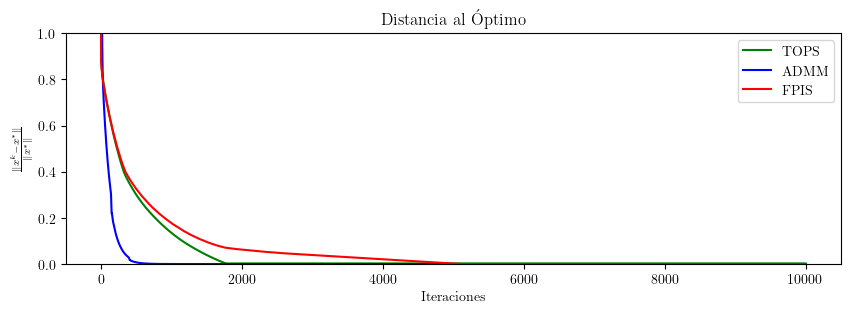

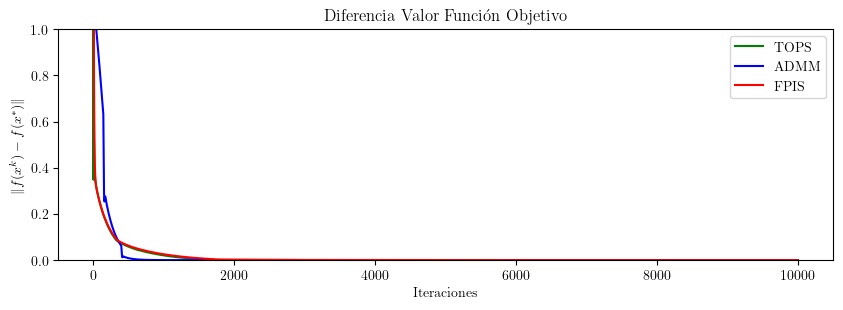

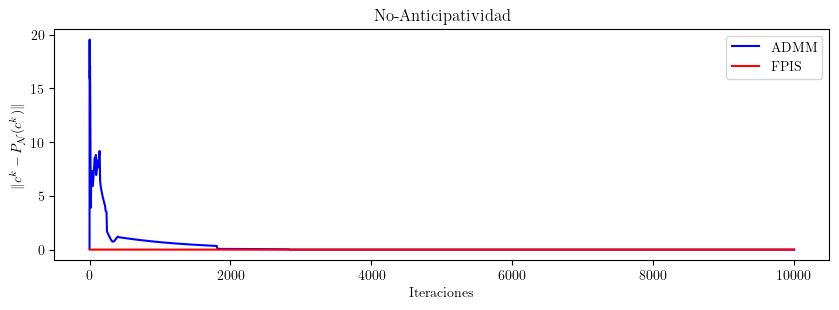

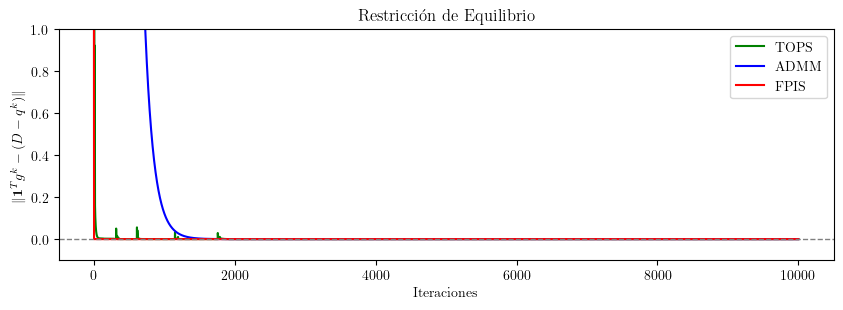

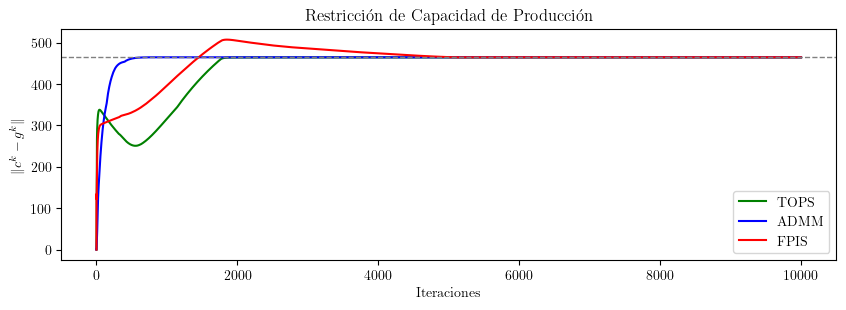

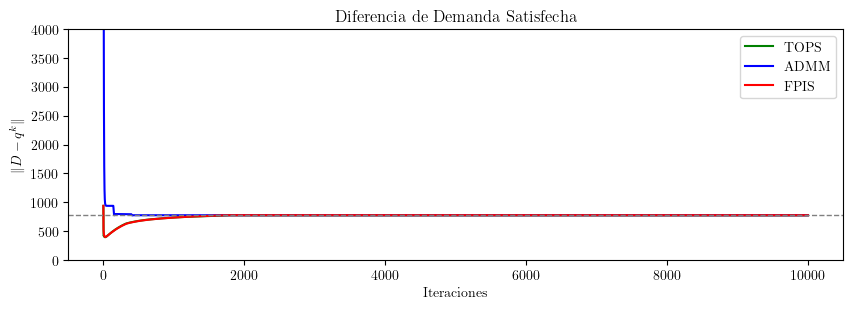

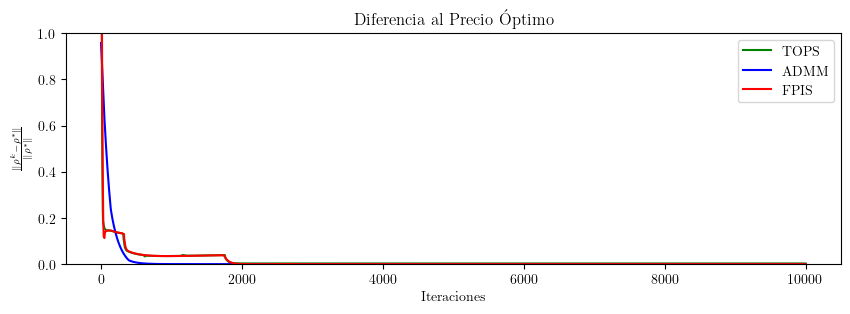

In [16]:
# Crear un rango de iteraciones para las gráficas
k = 0
l = int(max_iters_list / 1) + 1

zero_1 = np.zeros((N,1))
zero_2 = np.zeros((N,M))
zero_3 = np.zeros((1,M))
zeroo = (zero_1, zero_2, zero_3)

# Definir los niveles teóricos según tu solución teórica
nivel_teorico_equilibrio = norm_adjusted((zero_1,zero_2,x2.sum(axis=0) - (D - x3)), zeroo, Sigma)
nivel_teorico_capacidad = norm_adjusted((zero_1,x1 - x2,zero_3), zeroo, Sigma)
nivel_teorico_demanda = norm_adjusted((zero_1,zero_2,D - x3), zeroo, Sigma)

# Variable de sufijo para los nombres de archivo
suffix = "_1"

# Función para configurar y guardar cada gráfico
def configurar_grafico(ax, x_data, y_data, labels, colors, title, y_label, width, height, y_lim=None, nivel_teorico=None):
    for x, y, label, color in zip(x_data, y_data, labels, colors):
        ax.plot(x[k:l], y[k:l], '-', linewidth=1.5, label=label, color=color)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Iteraciones')
    ax.legend()
    if y_lim:
        ax.set_ylim(y_lim)
    if nivel_teorico is not None:
        ax.axhline(y=nivel_teorico, color='gray', linestyle='--', linewidth=1)
    ax.figure.set_figwidth(width)
    ax.figure.set_figheight(height)

# Datos para los gráficos
iter_data = [iter_DY, iter_ADMM, iter_BA]
labels = ['TOPS', 'ADMM', 'FPIS']
colors = ['green', 'blue', 'red']

# Definir la altura y el ancho deseado para cada gráfico
width = 10  # Ajusta esta variable según sea necesario
height = 3  # Ajusta esta variable según sea necesario

# Crear y guardar cada figura individualmente
fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [x_DY_sol, x_ADMM_sol, x_BA_sol], labels, colors, 'Distancia al Óptimo', 
                   r'$\frac{\|x^{k} - x^{*}\|}{\|x^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/distancia_al_optimo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [Fx_DY_sol, Fx_ADMM_sol, Fx_BA_sol], labels, colors, 'Diferencia Valor Función Objetivo', 
                   r'$\|f(x^{k})-f(x^{*})\|$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_valor_funcion_objetivo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data[1:], [Non_anti_DY, Non_anti_ADMM, Non_anti_BA][1:], labels[1:], colors[1:], 'No-Anticipatividad', 
                   r'$\|c^{k}-P_{\mathcal{N}}(c^{k})\|$', width, height)#, y_lim=(0, 25))
plt.savefig(f'images/caso{suffix}/no_anticipatividad{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [equili_DY_solu, equili_ADMM_solu, equili_BA_solu], labels, colors, 'Restricción de Equilibrio', 
                   r'$\|\textbf{1}^{T}g^{k}-(D-q^{k})\|$', width, height, y_lim=(-0.1, 1.0), nivel_teorico=nivel_teorico_equilibrio)
plt.savefig(f'images/caso{suffix}/restriccion_de_equilibrio{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [capacity_DY_solu, capacity_ADMM_solu, capacity_BA_solu], labels, colors, 'Restricción de Capacidad de Producción', 
                   r'$\|c^{k} - g^{k}\|$', width, height, nivel_teorico=nivel_teorico_capacidad)
plt.savefig(f'images/caso{suffix}/restriccion_de_capacidad_de_produccion{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [demand_DY_sol, demand_ADMM_sol, demand_BA_sol], labels, colors, 'Diferencia de Demanda Satisfecha', 
                   r'$\|D-q^{k}\|$', width, height, y_lim=(0, 4000), nivel_teorico=nivel_teorico_demanda)
plt.savefig(f'images/caso{suffix}/diferencia_de_demanda_satisfecha{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [dual_DY_sol, dual_ADMM_sol, BA_dual_sol], labels, colors, 'Diferencia al Precio Óptimo', 
                   r'$\frac{\|\rho^{k}-\rho^{*}\|}{\|\rho^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_al_precio_optimo{suffix}.png', bbox_inches='tight')
plt.show()


In [17]:
Times

{'CP': 0.21850204467773438,
 'DY': 1190.7133128643036,
 'BA': 629.5290949344635,
 'ADMM': 601.9758615493774}

In [18]:
iter_DY[-1], x_DY_sol[-1], Fx_DY_sol[-1], Non_anti_DY[-1], equili_DY_solu[-1], capacity_DY_solu[-1], demand_DY_sol[-1], dual_DY_sol[-1]

(9999,
 0.003097221600233452,
 0.00013854712864954226,
 0.0,
 9.391435861516586e-06,
 464.2596049813523,
 775.6655535991703,
 0.002810432893130672)

In [19]:
iter_BA[-1], x_BA_sol[-1], Fx_BA_sol[-1], Non_anti_BA[-1], equili_BA_solu[-1], capacity_BA_solu[-1], demand_BA_sol[-1], BA_dual_sol[-1]

(9999,
 2.438746827678754e-09,
 1.1436660878588725e-11,
 0.0,
 9.391314188178513e-06,
 464.5878350997092,
 777.3599568808092,
 2.7022146753616922e-11)

In [20]:
iter_ADMM[-1], x_ADMM_sol[-1], Fx_ADMM_sol[-1], Non_anti_ADMM[-1], equili_ADMM_solu[-1], capacity_ADMM_solu[-1], demand_ADMM_sol[-1], dual_ADMM_sol[-1]

(9999,
 3.8454743304016674e-11,
 1.6132027363332004e-12,
 4.5474735088646414e-14,
 9.394005041940546e-06,
 464.58783155365506,
 777.3599568381936,
 1.8358130691611741e-13)

In [21]:
nivel_teorico_equilibrio, nivel_teorico_capacidad, nivel_teorico_demanda

(9.393999260964846e-06, 464.5878315116832, 777.3599568385031)